In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

# Load datasets
#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TRAIN_DATA_PARIS.csv'
#full_train_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/Train_model_Paris_Vince.csv'
full_train_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_VALID_DATA_PARIS.csv'
#full_valid_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/Valid_model_Paris_Vince.csv'
full_valid_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TEST_DATA_PARIS.csv'
#full_test_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/Test_model_Paris_Vince.csv'
full_test_data = pd.read_csv(file_path)

Functie om een sample uit de volledige dataset te nemen. De functie neemt een x aantal gespecifieerde unieke id's en haalt alle rijen van die id's uit de dataset. Dit is gedaan om vereiste rekenkracht van de modellen iets naar beneden te halen. Deze functie is niet meer nodig aangezien de dataset al is aangepast maar ik hou het er nog even in just in case

In [4]:



# Sampling function
def sample_locations(data, num_locations):
    unique_ids = data[['id']].drop_duplicates()
    sampled_ids = unique_ids.sample(n=num_locations, random_state=42)
    return data.merge(sampled_ids, on=['id'])

# Sample locations
#train_num_locations = 600
#val_num_locations = 200
#test_num_locations = 200

#train_data = sample_locations(full_train_data, train_num_locations)
#val_data = sample_locations(full_valid_data, val_num_locations)
#test_data = sample_locations(full_test_data, test_num_locations)

train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Clear memory
#del full_train_data, full_valid_data, full_test_data
#gc.collect()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)


In [59]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53952 entries, 7440 to 37583
Columns: 138 entries, id to kitchen_amenities
dtypes: bool(98), datetime64[ns](1), float64(15), int64(24)
memory usage: 21.9 MB


LSTM model
Hier wordt het LSTM model gemaakt. Enkel de 'id', 'date' en 'price' kolommen worden hier gebruikt. Het model creëert dan sequences van de historische prijzen om zo temporal features te leren die kunnen bijdragen aan de predictive performance. Het model wordt ook gehyperparameter tuned met Optuna. Twee extra variabelen die mee getuned worden, naast de hyperparameters van het LSTM model zelf, zijn 'sequence_length' en 'max_instances_per_location'. De sequence length bepaald hoe groot de price sequences zijn om features uit te leren. De max_instances_per_location neemt een x aantal random historische prijzen per unieke locatie, aangezien alle historische prijzen gebruiken wederom teveel computerkracht vereiste. De geleerde features worden gextraheerd en het model wordt opgeslagen om later hergebruikt te kunnen worden. De max instances per location wordt op 100 vastgezet aangezien dit ook al is aangepast in de dataset maar wordt wederom nog even bijgehouden just in case

In [64]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = RobustScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i]
            sequences.append(seq)
            labels.append(group.iloc[i]['price'])  # Correct label
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 7, 14)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 100, 100, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values for seq in train_sequences])
    y_train = np.array(train_labels)
    X_val = np.array([seq[['price']].values for seq in val_sequences])
    y_val = np.array(val_labels)
    X_test = np.array([seq[['price']].values for seq in test_sequences])
    y_test = np.array(test_labels)

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, 1)))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32), return_sequences=False))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(16))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True)(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2, return_sequences=False)(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
dense_layer = Dense(16)(dropout_layer_2)
output_layer = Dense(1)(dense_layer)

feature_extraction_model = Model(inputs=input_layer, outputs=dense_layer)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
                         loss='mean_squared_error',
                         metrics=['mae'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_PARIS_2.h5')
prediction_model.save(final_model_path)

feature_model_path = os.path.join(drive_path, 'LSTM_FEATURES_PARIS_2.h5')
feature_extraction_model.save(feature_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_2.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


[I 2024-08-05 15:58:46,165] A new study created in memory with name: no-name-8c977516-ae08-4f5e-b84e-e41c548d0bb7
Creating sequences: 100%|██████████| 2000/2000 [00:07<00:00, 263.78it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-64-aa87512eb60a>:68: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-08-05 16:10:11,759] Trial 0 finished with value: 0.029541898518800735 and parameters: {'sequence_length': 7, 'max_instances_per_location': 100, 'units1': 32, 'dropout1': 0.4, 'units2': 64, 'dropout2': 0.300

Epoch 1/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 0.1230 - mae: 0.1230 - val_loss: 0.0501 - val_mae: 0.0501
Epoch 2/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.1086 - mae: 0.1086 - val_loss: 0.0552 - val_mae: 0.0552
Epoch 3/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.1044 - mae: 0.1044 - val_loss: 0.0307 - val_mae: 0.0307
Epoch 4/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 0.1031 - mae: 0.1031 - val_loss: 0.0354 - val_mae: 0.0354
Epoch 5/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 0.1031 - mae: 0.1031 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 6/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.1033 - mae: 0.1033 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 7/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.1012 - mae: 0.1012 - val_loss: 0.0362 - val_mae: 0.0362
Epoch 8/25
14990/14990 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 0.1013 - mae: 0.1013 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 9/25
14990

14990/14990 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


LSTM Model
Het LSTM model kan hier terug ingeladen worden

In [ ]:
import os
from tensorflow.keras.models import load_model
import joblib
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
from google.colab import drive
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Custom LSTM without the 'time_major' argument
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        # Remove time_major if it exists in kwargs
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Mapping the custom class
custom_objects = {'LSTM': CustomLSTM}

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_FEATURES_PARIS_2.h5')
study_path = os.path.join(drive_path, 'optuna_study_LSTM_PARIS_2.pkl')

# Load the model
#loaded_model = load_model(final_model_path)
loaded_model = load_model(feature_model_path, custom_objects=custom_objects)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values for seq in train_sequences])
y_train = np.array(train_labels)
X_val = np.array([seq[['price']].values for seq in val_sequences])
y_val = np.array(val_labels)
X_test = np.array([seq[['price']].values for seq in test_sequences])
y_test = np.array(test_labels)

# Assuming the loaded model is the feature extraction model
train_features_lstm = loaded_model.predict(X_train)
val_features_lstm = loaded_model.predict(X_val)
test_features_lstm = loaded_model.predict(X_test)

# Now you can use train_features_lstm, val_features_lstm, and test_features_lstm




Creating sequences: 100%|██████████| 2000/2000 [00:09<00:00, 211.42it/s]


15553/15553 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


code om de lstm features juist te kunnen mergen met de originele data

In [67]:
train_features_lstm = scaler.inverse_transform(train_features_lstm)
val_features_lstm = scaler.inverse_transform(val_features_lstm)
test_features_lstm = scaler.inverse_transform(test_features_lstm)

In [68]:
# Convert the extracted features and IDs into DataFrames with clean integer IDs
train_features_with_ids = pd.DataFrame(train_features_lstm)
train_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_ids]

val_features_with_ids = pd.DataFrame(val_features_lstm)
val_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_ids]

test_features_with_ids = pd.DataFrame(test_features_lstm)
test_features_with_ids['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_ids]

# Now train_features_with_ids, val_features_with_ids, and test_features_with_ids contain the LSTM features and their associated integer IDs


In [69]:
train_features_with_ids.head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,id
0,91.115593,90.569977,90.886589,91.037292,65.139191,90.856339,55.627460,109.466484,90.938980,90.749275,91.051651,91.034210,91.096176,90.543724,91.107033,90.611496,11798
1,91.115791,90.574753,90.889648,91.031952,65.306206,90.856651,55.845085,109.354050,90.938011,90.751495,91.051674,91.034958,91.097977,90.555511,91.112488,90.609810,11798
2,91.111275,90.574692,90.901703,91.030663,65.774445,90.855598,56.404957,109.003746,90.950470,90.761581,91.044930,91.030731,91.103912,90.554176,91.115250,90.614792,11798
3,91.110115,90.576546,90.900215,91.028000,65.918976,90.856567,56.591377,108.897461,90.947449,90.761177,91.045898,91.030212,91.104057,90.559700,91.116829,90.615387,11798
4,91.111671,90.578636,90.901627,91.025871,66.054184,90.855286,56.774902,108.794090,90.944786,90.763451,91.048225,91.032585,91.102478,90.566566,91.118126,90.613518,11798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,91.162720,90.835541,91.093948,90.905052,100.127129,90.782471,100.027115,82.308151,90.974770,91.123688,91.033134,91.120361,90.993309,91.055374,91.110451,90.847786,16455
96,91.162766,90.835815,91.094322,90.904900,100.163895,90.781952,100.075485,82.279266,90.974617,91.124321,91.033386,91.120659,90.992867,91.056419,91.110619,90.847992,16455
97,91.162788,90.835968,91.094429,90.904655,100.191353,90.781471,100.112701,82.257759,90.974358,91.124886,91.033554,91.121063,90.992409,91.057526,91.110672,90.847939,16455
98,91.161758,90.835976,91.095406,90.904587,100.226974,90.781715,100.151749,82.232796,90.975723,91.125214,91.032646,91.120354,90.993507,91.056839,91.111168,90.848610,16455


In [70]:
# Extract the last occurrence of each ID's features
def extract_last_features(features, ids):
    last_features_map = {}
    for idx, id in enumerate(ids):
        last_features_map[id] = features[idx]
    unique_ids = list(last_features_map.keys())
    last_features = np.array([last_features_map[id] for id in unique_ids])
    return last_features, unique_ids

# Apply extraction of the last features
train_last_features, train_unique_ids = extract_last_features(train_features_lstm, train_ids)
val_last_features, val_unique_ids = extract_last_features(val_features_lstm, val_ids)
test_last_features, test_unique_ids = extract_last_features(test_features_lstm, test_ids)

# Convert to DataFrames
train_features_with_ids_last = pd.DataFrame(train_last_features)
train_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in train_unique_ids]

val_features_with_ids_last = pd.DataFrame(val_last_features)
val_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in val_unique_ids]

test_features_with_ids_last = pd.DataFrame(test_last_features)
test_features_with_ids_last['id'] = [int(id[0]) if isinstance(id, tuple) else int(id) for id in test_unique_ids]

# Now train_features_with_ids, val_features_with_ids, and test_features_with_ids contain the LSTM features
# of the last instance for each unique ID and their associated integer IDs

In [71]:
train_features_with_ids_last.head(1000)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,id
0,91.107430,90.554337,90.858429,91.049614,64.095177,90.866341,54.277828,110.252090,90.934792,90.721680,91.050346,91.024391,91.100349,90.512596,91.098373,90.615891,11798
1,91.157822,90.835983,91.100372,90.903191,100.175583,90.783142,100.073120,82.283134,90.981079,91.126999,91.028854,91.117889,90.998268,91.054283,91.113152,90.848495,16455
2,90.808342,90.484474,91.027130,91.326096,52.189362,90.780464,37.984760,119.464745,91.189972,90.511703,90.850044,90.790733,91.256447,90.065636,91.068619,90.710388,19306
3,91.179832,90.931145,91.170204,90.873123,111.510696,90.733223,114.489609,73.431747,90.979828,91.262772,91.046082,91.172562,90.936615,91.235687,91.107590,90.935295,23441
4,91.154221,90.804504,91.071465,90.916519,96.511139,90.795074,95.424789,85.130890,90.974846,91.080864,91.028114,91.105118,91.010681,90.998238,91.111961,90.821495,39948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,91.168419,90.874191,91.126999,90.891205,104.767738,90.764671,105.912430,78.695435,90.979523,91.180031,91.036507,91.138443,90.973740,91.125984,91.110626,90.883560,6885204
996,91.103401,90.586044,90.916878,91.018524,67.980133,90.857651,59.167503,107.320915,90.961540,90.781174,91.035057,91.026215,91.110146,90.579140,91.120407,90.630173,6888694
997,91.168419,90.874191,91.126999,90.891205,104.767738,90.764671,105.912430,78.695435,90.979523,91.180031,91.036507,91.138443,90.973740,91.125984,91.110626,90.883560,6889306
998,91.192078,91.054787,91.235519,90.844269,127.227295,90.619072,134.583374,61.112011,90.957428,91.458717,91.082527,91.295914,90.808609,91.517532,91.090424,91.062500,6891821


In [72]:
train_features_with_ids_last.shape

(6000, 17)

Hier wordt de data gepreprocessed voor het PE-GNN model. Aangezien we de historische prijzen niet meer nodig hebben wordt van elke unieke Airbnb maar een data entry bijgehouden. Daarna worden de coordinaten eruit gehaald om te gebruiken in de position encoder en worden de andere hedonische features samengevoegd met de geleerde LSTM features om toe te voegen aan de nodes van het GNN. Ook word nog zeker gemaakt dat de spatiale en temporele features, die voor de baseline modellen worden gebruikt, hier uit de data worden verwijderd

In [78]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())


import pandas as pd

# Assume train_data_pegnn, val_data_pegnn, and test_data_pegnn are already loaded and contain the 'id' column

# Ensure IDs are consistent and merge the datasets
train_data_pegnn['id'] = train_data_pegnn['id'].astype(int)
val_data_pegnn['id'] = val_data_pegnn['id'].astype(int)
test_data_pegnn['id'] = test_data_pegnn['id'].astype(int)

train_features_with_ids_last['id'] = train_features_with_ids_last['id'].astype(int)
val_features_with_ids_last['id'] = val_features_with_ids_last['id'].astype(int)
test_features_with_ids_last['id'] = test_features_with_ids_last['id'].astype(int)

# Merge the LSTM features with the original data
train_data_pegnn = pd.merge(train_data_pegnn, train_features_with_ids_last, on='id', how='left')
val_data_pegnn = pd.merge(val_data_pegnn, val_features_with_ids_last, on='id', how='left')
test_data_pegnn = pd.merge(test_data_pegnn, test_features_with_ids_last, on='id', how='left')


In [79]:
train_data_pegnn.shape

(6000, 154)

In [84]:
train_data_pegnn.head()

,id,date,available,price,weekday,season_Autumn,season_Winter,year,month,day,...,6,7,8,9,10,11,12,13,14,15
0,11798,2024-01-12,True,140.0,4,False,True,2024,1,12,...,54.277828,110.252090,90.934792,90.721680,91.050346,91.024391,91.100349,90.512596,91.098373,90.615891
1,16455,2024-01-12,False,85.0,4,False,True,2024,1,12,...,100.073120,82.283134,90.981079,91.126999,91.028854,91.117889,90.998268,91.054283,91.113152,90.848495
2,19306,2024-01-12,False,140.0,4,False,True,2024,1,12,...,37.984760,119.464745,91.189972,90.511703,90.850044,90.790733,91.256447,90.065636,91.068619,90.710388
3,23441,2024-01-12,False,70.0,4,False,True,2024,1,12,...,114.489609,73.431747,90.979828,91.262772,91.046082,91.172562,90.936615,91.235687,91.107590,90.935295
4,39948,2024-01-12,False,90.0,4,False,True,2024,1,12,...,95.424789,85.130890,90.974846,91.080864,91.028114,91.105118,91.010681,90.998238,91.111961,90.821495


In [85]:
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id', 'weekday',
    'month', 'day', 'is_holiday', 'is_school_holiday', 'season_Autumn', 'season_Winter', 'neighbourhood_Batignolles-Monceau',
    'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
    'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville',
    'neighbourhood_Louvre', 'neighbourhood_Luxembourg', 'neighbourhood_Ménilmontant',
    'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon',
    'neighbourhood_Panthéon', 'neighbourhood_Passy', 'neighbourhood_Popincourt',
    'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard',
    'neighbourhood_Élysée', 'Eiffel Tower Distance', 'Louvre Museum Distance',
    'Notre-Dame Cathedral Distance', 'Sacré-Cœur Basilica Distance', 'Arc de Triomphe Distance',
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors'
    ])

    #features = data.drop(columns=['latitude', 'longitude', 'date', 'id', 'host_id'])
    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)
    scaler = StandardScaler()
    #features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
        # Convert all column names to strings
    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)


# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Extract and scale prices
train_prices_pegnn = train_features_pegnn['price']
val_prices_pegnn = val_features_pegnn['price']
test_prices_pegnn = test_features_pegnn['price']

<ipython-input-85-ebe6196619ab>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-85-ebe6196619ab>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
<ipython-input-85-ebe6196619ab>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [86]:
train_features_pegnn.shape

(6000, 113)

In [87]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_paris_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_paris_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_paris_FINAL.csv', index=False)

PE-GNN model
Hier word het PE-GNN model gecreëerd. Ook wordt het hier terug mogelijk gemaakt om het model op te slaan en terug te hergebruiken. De edges van de GNN worden gemaakt via een k-nearest neighbours aanpak. Tussen de x aantal dichtste neighbours, dichtst in termen van fysieke afstand, worden edges gemaakt. De hoeveelheid nearest neighbours wordt net zoals een aantal andere variabelen gehyperparameter tuned via Optuna. De position encoder leert door gebruik te maken van de coordinaten van de nodes en voegt deze informatie toe aan de nodes. Zo hebben de nodes informatie over het spatiale aspect via de PE, over het temporele aspect via de LSTM, en over de hedonische features. Dit model heeft dan ook verscheidene performance metrics die die men onderaan kan zien, als ook verscheidene plots om de evolutie van de metrics te kunnen volgen doorheen het leerproces.

[I 2024-08-05 18:58:13,726] A new study created in memory with name: no-name-995793bf-e5da-4faf-a293-2074d9ddd0b0
Training PEGNN: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
[I 2024-08-05 18:59:17,443] Trial 0 finished with value: 0.6313968300819397 and parameters: {'hidden_channels': 87, 'lr': 0.0001712858326192247, 'k': 52, 'dropout_rate': 0.1333676672402481}. Best is trial 0 with value: 0.6313968300819397.


Best parameters:  {'hidden_channels': 87, 'lr': 0.0001712858326192247, 'k': 52, 'dropout_rate': 0.1333676672402481}


Final training:   0%|          | 1/500 [00:01<11:45,  1.41s/it]

Epoch 1, Training Loss: 4.984235763549805, Training R-squared: -0.8058804693638257, Training MAE: 0.9151570796966553, Training MSE: 4.984235763549805
Epoch 1, Validation Loss: 5.608160495758057, Validation R-squared: -0.9626032796397073, Validation MAE: 0.9472060203552246, Validation MSE: 5.608160495758057


Final training:   0%|          | 2/500 [00:02<11:52,  1.43s/it]

Epoch 2, Training Loss: 4.582160949707031, Training R-squared: -0.6602013187669367, Training MAE: 0.8981770277023315, Training MSE: 4.582160949707031
Epoch 2, Validation Loss: 5.242611408233643, Validation R-squared: -0.8346774061209605, Validation MAE: 0.923742413520813, Validation MSE: 5.242611408233643
Epoch 3, Training Loss: 4.382317066192627, Training R-squared: -0.587794265334125, Training MAE: 0.882097601890564, Training MSE: 4.382317066192627


Final training:   1%|          | 3/500 [00:04<12:26,  1.50s/it]

Epoch 3, Validation Loss: 4.896387577056885, Validation R-squared: -0.7135147202523444, Validation MAE: 0.9026245474815369, Validation MSE: 4.896387100219727


Final training:   1%|          | 4/500 [00:05<12:17,  1.49s/it]

Epoch 4, Training Loss: 4.105322360992432, Training R-squared: -0.4874339254971223, Training MAE: 0.8648701310157776, Training MSE: 4.105322360992432
Epoch 4, Validation Loss: 4.569006443023682, Validation R-squared: -0.598946211692331, Validation MAE: 0.8838152885437012, Validation MSE: 4.56900691986084


Final training:   1%|          | 5/500 [00:07<12:04,  1.46s/it]

Epoch 5, Training Loss: 3.9452288150787354, Training R-squared: -0.4294290773075513, Training MAE: 0.8566957712173462, Training MSE: 3.9452285766601562
Epoch 5, Validation Loss: 4.259215831756592, Validation R-squared: -0.4905333619829455, Validation MAE: 0.8668039441108704, Validation MSE: 4.259215831756592


Final training:   1%|          | 6/500 [00:08<11:57,  1.45s/it]

Epoch 6, Training Loss: 3.7954089641571045, Training R-squared: -0.3751465592657033, Training MAE: 0.8452296257019043, Training MSE: 3.7954089641571045
Epoch 6, Validation Loss: 3.9670209884643555, Validation R-squared: -0.38827841891012294, Validation MAE: 0.8521815538406372, Validation MSE: 3.9670209884643555


Final training:   1%|▏         | 7/500 [00:10<11:52,  1.44s/it]

Epoch 7, Training Loss: 3.490283489227295, Training R-squared: -0.26459415779529505, Training MAE: 0.8304277062416077, Training MSE: 3.490283966064453
Epoch 7, Validation Loss: 3.6919305324554443, Validation R-squared: -0.2920091875117845, Validation MAE: 0.8394247889518738, Validation MSE: 3.6919307708740234


Final training:   2%|▏         | 8/500 [00:11<11:47,  1.44s/it]

Epoch 8, Training Loss: 3.5118565559387207, Training R-squared: -0.2724103411996637, Training MAE: 0.8307822942733765, Training MSE: 3.5118565559387207
Epoch 8, Validation Loss: 3.4355061054229736, Validation R-squared: -0.20227221131192885, Validation MAE: 0.8286923766136169, Validation MSE: 3.4355061054229736


Final training:   2%|▏         | 9/500 [00:13<11:47,  1.44s/it]

Epoch 9, Training Loss: 3.188127040863037, Training R-squared: -0.15511715328631115, Training MAE: 0.8179327845573425, Training MSE: 3.188127040863037
Epoch 9, Validation Loss: 3.196960210800171, Validation R-squared: -0.11879186369977579, Validation MAE: 0.8201198577880859, Validation MSE: 3.196960210800171


Final training:   2%|▏         | 10/500 [00:14<11:39,  1.43s/it]

Epoch 10, Training Loss: 3.1139514446258545, Training R-squared: -0.12824213100362414, Training MAE: 0.8114902973175049, Training MSE: 3.1139519214630127
Epoch 10, Validation Loss: 2.973389148712158, Validation R-squared: -0.040552038433345095, Validation MAE: 0.8130456209182739, Validation MSE: 2.973389148712158


Final training:   2%|▏         | 11/500 [00:15<11:48,  1.45s/it]

Epoch 11, Training Loss: 2.8046953678131104, Training R-squared: -0.016192895682162423, Training MAE: 0.8017784953117371, Training MSE: 2.8046953678131104
Epoch 11, Validation Loss: 2.76591420173645, Validation R-squared: 0.03205474799383434, Validation MAE: 0.8072752952575684, Validation MSE: 2.7659144401550293


Final training:   2%|▏         | 12/500 [00:17<12:07,  1.49s/it]

Epoch 12, Training Loss: 2.7846779823303223, Training R-squared: -0.008940179143867466, Training MAE: 0.806311845779419, Training MSE: 2.7846779823303223
Epoch 12, Validation Loss: 2.5747573375701904, Validation R-squared: 0.09895107177650497, Validation MAE: 0.8030623197555542, Validation MSE: 2.5747573375701904


Final training:   3%|▎         | 13/500 [00:18<11:57,  1.47s/it]

Epoch 13, Training Loss: 2.6172194480895996, Training R-squared: 0.0517331149929664, Training MAE: 0.7977671027183533, Training MSE: 2.6172194480895996
Epoch 13, Validation Loss: 2.3973987102508545, Validation R-squared: 0.16101855204332283, Validation MAE: 0.7998970150947571, Validation MSE: 2.3973989486694336


Final training:   3%|▎         | 14/500 [00:20<11:50,  1.46s/it]

Epoch 14, Training Loss: 2.44677734375, Training R-squared: 0.11348738956553983, Training MAE: 0.7930036783218384, Training MSE: 2.446777582168579
Epoch 14, Validation Loss: 2.2319560050964355, Validation R-squared: 0.21891606858563628, Validation MAE: 0.7978488206863403, Validation MSE: 2.2319560050964355


Final training:   3%|▎         | 15/500 [00:21<11:51,  1.47s/it]

Epoch 15, Training Loss: 2.3626039028167725, Training R-squared: 0.14398501418515863, Training MAE: 0.7976350784301758, Training MSE: 2.3626039028167725
Epoch 15, Validation Loss: 2.078355550765991, Validation R-squared: 0.27266932789282605, Validation MAE: 0.7966691255569458, Validation MSE: 2.078355550765991


Final training:   3%|▎         | 16/500 [00:23<12:01,  1.49s/it]

Epoch 16, Training Loss: 2.3205599784851074, Training R-squared: 0.15921831758020766, Training MAE: 0.7980893850326538, Training MSE: 2.3205599784851074
Epoch 16, Validation Loss: 1.9348925352096558, Validation R-squared: 0.3228749495362694, Validation MAE: 0.7962280511856079, Validation MSE: 1.9348924160003662


Final training:   3%|▎         | 17/500 [00:24<11:48,  1.47s/it]

Epoch 17, Training Loss: 2.142395257949829, Training R-squared: 0.22377062159283678, Training MAE: 0.7928950786590576, Training MSE: 2.142395257949829
Epoch 17, Validation Loss: 1.8028210401535034, Validation R-squared: 0.3690939594485717, Validation MAE: 0.7962641716003418, Validation MSE: 1.8028210401535034


Final training:   4%|▎         | 18/500 [00:26<11:38,  1.45s/it]

Epoch 18, Training Loss: 2.1895129680633545, Training R-squared: 0.20669916103875896, Training MAE: 0.798972487449646, Training MSE: 2.1895127296447754
Epoch 18, Validation Loss: 1.6819934844970703, Validation R-squared: 0.41137815199229544, Validation MAE: 0.7966657876968384, Validation MSE: 1.6819934844970703


Final training:   4%|▍         | 19/500 [00:27<11:36,  1.45s/it]

Epoch 19, Training Loss: 1.9807196855545044, Training R-squared: 0.28234870424287517, Training MAE: 0.7933251857757568, Training MSE: 1.9807196855545044
Epoch 19, Validation Loss: 1.5734021663665771, Validation R-squared: 0.44938019151327147, Validation MAE: 0.7973366975784302, Validation MSE: 1.5734021663665771


Final training:   4%|▍         | 20/500 [00:29<11:53,  1.49s/it]

Epoch 20, Training Loss: 1.928118348121643, Training R-squared: 0.3014071492395769, Training MAE: 0.7921383380889893, Training MSE: 1.9281184673309326
Epoch 20, Validation Loss: 1.4773846864700317, Validation R-squared: 0.48298205196372423, Validation MAE: 0.798112154006958, Validation MSE: 1.4773845672607422


Final training:   4%|▍         | 21/500 [00:30<11:46,  1.48s/it]

Epoch 21, Training Loss: 1.8504596948623657, Training R-squared: 0.3295443784921396, Training MAE: 0.7962161302566528, Training MSE: 1.8504596948623657
Epoch 21, Validation Loss: 1.392850399017334, Validation R-squared: 0.5125651975986021, Validation MAE: 0.7989787459373474, Validation MSE: 1.392850399017334


Final training:   4%|▍         | 22/500 [00:32<11:35,  1.45s/it]

Epoch 22, Training Loss: 1.8168413639068604, Training R-squared: 0.341724832559246, Training MAE: 0.7973104119300842, Training MSE: 1.81684148311615
Epoch 22, Validation Loss: 1.3184597492218018, Validation R-squared: 0.5385985375716126, Validation MAE: 0.7997674345970154, Validation MSE: 1.3184597492218018


Final training:   5%|▍         | 23/500 [00:33<11:27,  1.44s/it]

Epoch 23, Training Loss: 1.714321494102478, Training R-squared: 0.3788697014300133, Training MAE: 0.7941455245018005, Training MSE: 1.714321494102478
Epoch 23, Validation Loss: 1.2535253763198853, Validation R-squared: 0.5613226900198405, Validation MAE: 0.8002897500991821, Validation MSE: 1.2535252571105957


Final training:   5%|▍         | 24/500 [00:34<11:21,  1.43s/it]

Epoch 24, Training Loss: 1.7212961912155151, Training R-squared: 0.37634262316909783, Training MAE: 0.8014349937438965, Training MSE: 1.7212961912155151
Epoch 24, Validation Loss: 1.1965265274047852, Validation R-squared: 0.5812696961774151, Validation MAE: 0.8001986742019653, Validation MSE: 1.1965265274047852


Final training:   5%|▌         | 25/500 [00:36<11:17,  1.43s/it]

Epoch 25, Training Loss: 1.6943999528884888, Training R-squared: 0.3860876966718717, Training MAE: 0.8050679564476013, Training MSE: 1.6943997144699097
Epoch 25, Validation Loss: 1.1467012166976929, Validation R-squared: 0.5987063062044545, Validation MAE: 0.7992883324623108, Validation MSE: 1.1467012166976929


Final training:   5%|▌         | 26/500 [00:37<11:12,  1.42s/it]

Epoch 26, Training Loss: 1.6091994047164917, Training R-squared: 0.41695738818414074, Training MAE: 0.797798752784729, Training MSE: 1.6091994047164917
Epoch 26, Validation Loss: 1.1035840511322021, Validation R-squared: 0.6137953463103764, Validation MAE: 0.7973374128341675, Validation MSE: 1.1035840511322021


Final training:   5%|▌         | 27/500 [00:39<11:09,  1.42s/it]

Epoch 27, Training Loss: 1.5834331512451172, Training R-squared: 0.42629297774366215, Training MAE: 0.7987613677978516, Training MSE: 1.5834332704544067
Epoch 27, Validation Loss: 1.0665476322174072, Validation R-squared: 0.6267564631940563, Validation MAE: 0.7946269512176514, Validation MSE: 1.0665476322174072
Epoch 28, Training Loss: 1.4927781820297241, Training R-squared: 0.4591389756799841, Training MAE: 0.7901514768600464, Training MSE: 1.4927781820297241
Epoch 28, Validation Loss: 1.0347198247909546, Validation R-squared: 0.6378947320443984, Validation MAE: 0.7916070818901062, Validation MSE: 1.034719705581665


Final training:   6%|▌         | 29/500 [00:42<11:31,  1.47s/it]

Epoch 29, Training Loss: 1.5176116228103638, Training R-squared: 0.45014132357239844, Training MAE: 0.7951800227165222, Training MSE: 1.5176116228103638
Epoch 29, Validation Loss: 1.007155179977417, Validation R-squared: 0.6475411078807871, Validation MAE: 0.7881212830543518, Validation MSE: 1.007155179977417


Final training:   6%|▌         | 30/500 [00:43<11:26,  1.46s/it]

Epoch 30, Training Loss: 1.4606451988220215, Training R-squared: 0.4707813710820705, Training MAE: 0.7886788845062256, Training MSE: 1.4606449604034424
Epoch 30, Validation Loss: 0.9831576943397522, Validation R-squared: 0.6559391518527931, Validation MAE: 0.7834362983703613, Validation MSE: 0.9831576943397522


Final training:   6%|▌         | 31/500 [00:45<11:19,  1.45s/it]

Epoch 31, Training Loss: 1.4116419553756714, Training R-squared: 0.4885361428187618, Training MAE: 0.7818863987922668, Training MSE: 1.4116419553756714
Epoch 31, Validation Loss: 0.9621082544326782, Validation R-squared: 0.6633054786831531, Validation MAE: 0.7775152325630188, Validation MSE: 0.962108314037323


Final training:   6%|▋         | 32/500 [00:46<11:15,  1.44s/it]

Epoch 32, Training Loss: 1.391185998916626, Training R-squared: 0.4959476501957538, Training MAE: 0.7812537550926208, Training MSE: 1.391185998916626
Epoch 32, Validation Loss: 0.9429793357849121, Validation R-squared: 0.6699997634103192, Validation MAE: 0.7702860236167908, Validation MSE: 0.9429793953895569


Final training:   7%|▋         | 33/500 [00:47<11:09,  1.43s/it]

Epoch 33, Training Loss: 1.3859672546386719, Training R-squared: 0.4978384702130362, Training MAE: 0.7771990299224854, Training MSE: 1.3859672546386719
Epoch 33, Validation Loss: 0.9254859685897827, Validation R-squared: 0.6761216534762238, Validation MAE: 0.7620635032653809, Validation MSE: 0.9254859685897827


Final training:   7%|▋         | 34/500 [00:49<11:06,  1.43s/it]

Epoch 34, Training Loss: 1.3944001197814941, Training R-squared: 0.49478321102055167, Training MAE: 0.7731547951698303, Training MSE: 1.394399881362915
Epoch 34, Validation Loss: 0.9090853929519653, Validation R-squared: 0.6818611115126341, Validation MAE: 0.7532992959022522, Validation MSE: 0.9090854525566101


Final training:   7%|▋         | 35/500 [00:50<11:05,  1.43s/it]

Epoch 35, Training Loss: 1.3303495645523071, Training R-squared: 0.5179898152533413, Training MAE: 0.7597066760063171, Training MSE: 1.3303495645523071
Epoch 35, Validation Loss: 0.8938007354736328, Validation R-squared: 0.6872100724070818, Validation MAE: 0.7439590692520142, Validation MSE: 0.893800675868988


Final training:   7%|▋         | 36/500 [00:52<11:00,  1.42s/it]

Epoch 36, Training Loss: 1.3633476495742798, Training R-squared: 0.5060339836075818, Training MAE: 0.7577037811279297, Training MSE: 1.3633477687835693
Epoch 36, Validation Loss: 0.8789055347442627, Validation R-squared: 0.6924226700730907, Validation MAE: 0.7342782616615295, Validation MSE: 0.8789056539535522


Final training:   7%|▋         | 37/500 [00:53<11:09,  1.45s/it]

Epoch 37, Training Loss: 1.2808459997177124, Training R-squared: 0.5359258968282196, Training MAE: 0.7474664449691772, Training MSE: 1.2808458805084229
Epoch 37, Validation Loss: 0.8643695116043091, Validation R-squared: 0.6975096588504837, Validation MAE: 0.7239624857902527, Validation MSE: 0.8643695116043091


Final training:   8%|▊         | 38/500 [00:55<11:18,  1.47s/it]

Epoch 38, Training Loss: 1.2962671518325806, Training R-squared: 0.5303384791717711, Training MAE: 0.7384257912635803, Training MSE: 1.2962672710418701
Epoch 38, Validation Loss: 0.850029706954956, Validation R-squared: 0.7025279362015453, Validation MAE: 0.7134172320365906, Validation MSE: 0.8500297665596008


Final training:   8%|▊         | 39/500 [00:56<11:07,  1.45s/it]

Epoch 39, Training Loss: 1.2421129941940308, Training R-squared: 0.549959574093292, Training MAE: 0.7280923128128052, Training MSE: 1.2421129941940308
Epoch 39, Validation Loss: 0.8355058431625366, Validation R-squared: 0.7076106254968948, Validation MAE: 0.7025308012962341, Validation MSE: 0.8355059027671814


Final training:   8%|▊         | 40/500 [00:58<11:01,  1.44s/it]

Epoch 40, Training Loss: 1.206161618232727, Training R-squared: 0.5629853893429565, Training MAE: 0.7160720825195312, Training MSE: 1.206161618232727
Epoch 40, Validation Loss: 0.8210034370422363, Validation R-squared: 0.712685854680208, Validation MAE: 0.6913942694664001, Validation MSE: 0.8210033774375916


Final training:   8%|▊         | 41/500 [00:59<10:58,  1.44s/it]

Epoch 41, Training Loss: 1.2220665216445923, Training R-squared: 0.5572227478951703, Training MAE: 0.7063910961151123, Training MSE: 1.2220665216445923
Epoch 41, Validation Loss: 0.8062647581100464, Validation R-squared: 0.7178436993062496, Validation MAE: 0.6800649166107178, Validation MSE: 0.8062647581100464


Final training:   8%|▊         | 42/500 [01:00<10:55,  1.43s/it]

Epoch 42, Training Loss: 1.2063180208206177, Training R-squared: 0.5629287205311708, Training MAE: 0.6980841755867004, Training MSE: 1.2063181400299072
Epoch 42, Validation Loss: 0.7911423444747925, Validation R-squared: 0.7231358358112532, Validation MAE: 0.6686208248138428, Validation MSE: 0.791142463684082


Final training:   9%|▊         | 43/500 [01:02<10:51,  1.43s/it]

Epoch 43, Training Loss: 1.2079087495803833, Training R-squared: 0.5623524217593201, Training MAE: 0.6880611181259155, Training MSE: 1.2079086303710938
Epoch 43, Validation Loss: 0.7758519053459167, Validation R-squared: 0.7284868136337838, Validation MAE: 0.6571680307388306, Validation MSE: 0.7758519053459167


Final training:   9%|▉         | 44/500 [01:03<10:45,  1.41s/it]

Epoch 44, Training Loss: 1.1704193353652954, Training R-squared: 0.5759355005699436, Training MAE: 0.6771356463432312, Training MSE: 1.1704192161560059
Epoch 44, Validation Loss: 0.7601383328437805, Validation R-squared: 0.7339858749772926, Validation MAE: 0.6455734372138977, Validation MSE: 0.7601383328437805


Final training:   9%|▉         | 45/500 [01:05<10:43,  1.42s/it]

Epoch 45, Training Loss: 1.1402066946029663, Training R-squared: 0.586882090432586, Training MAE: 0.6717113256454468, Training MSE: 1.1402066946029663
Epoch 45, Validation Loss: 0.7438191175460815, Validation R-squared: 0.7396968456708674, Validation MAE: 0.6338430047035217, Validation MSE: 0.7438191771507263


Final training:   9%|▉         | 46/500 [01:06<10:59,  1.45s/it]

Epoch 46, Training Loss: 1.197163462638855, Training R-squared: 0.5662456247399354, Training MAE: 0.6620763540267944, Training MSE: 1.197163462638855
Epoch 46, Validation Loss: 0.7271561026573181, Validation R-squared: 0.7455281362591102, Validation MAE: 0.6223741173744202, Validation MSE: 0.7271561622619629


Final training:   9%|▉         | 47/500 [01:08<11:07,  1.47s/it]

Epoch 47, Training Loss: 1.1204948425292969, Training R-squared: 0.5940240000913066, Training MAE: 0.6525484919548035, Training MSE: 1.120495080947876
Epoch 47, Validation Loss: 0.7103183269500732, Validation R-squared: 0.751420632859099, Validation MAE: 0.6112216711044312, Validation MSE: 0.7103183269500732


Final training:  10%|▉         | 48/500 [01:09<10:59,  1.46s/it]

Epoch 48, Training Loss: 1.1594161987304688, Training R-squared: 0.5799221313817755, Training MAE: 0.6456565856933594, Training MSE: 1.1594161987304688
Epoch 48, Validation Loss: 0.6928575038909912, Validation R-squared: 0.7575311172198318, Validation MAE: 0.6002132296562195, Validation MSE: 0.692857563495636


Final training:  10%|▉         | 49/500 [01:10<10:51,  1.44s/it]

Epoch 49, Training Loss: 1.101836085319519, Training R-squared: 0.6007844517242615, Training MAE: 0.6311973333358765, Training MSE: 1.1018362045288086
Epoch 49, Validation Loss: 0.675538957118988, Validation R-squared: 0.7635918352987223, Validation MAE: 0.5894808173179626, Validation MSE: 0.675538957118988


Final training:  10%|█         | 50/500 [01:12<10:47,  1.44s/it]

Epoch 50, Training Loss: 1.1069475412368774, Training R-squared: 0.5989324982771098, Training MAE: 0.6231079697608948, Training MSE: 1.1069475412368774
Epoch 50, Validation Loss: 0.6580982804298401, Validation R-squared: 0.7696952987868517, Validation MAE: 0.5790555477142334, Validation MSE: 0.6580982804298401


Final training:  10%|█         | 51/500 [01:13<10:44,  1.44s/it]

Epoch 51, Training Loss: 1.1060799360275269, Training R-squared: 0.5992468531454351, Training MAE: 0.6140682697296143, Training MSE: 1.1060799360275269
Epoch 51, Validation Loss: 0.6405767202377319, Validation R-squared: 0.7758270377319767, Validation MAE: 0.5690557956695557, Validation MSE: 0.6405767202377319


Final training:  10%|█         | 52/500 [01:15<10:41,  1.43s/it]

Epoch 52, Training Loss: 1.0374466180801392, Training R-squared: 0.6241139733966111, Training MAE: 0.6031498312950134, Training MSE: 1.0374466180801392
Epoch 52, Validation Loss: 0.6238260269165039, Validation R-squared: 0.7816890261168599, Validation MAE: 0.5594735145568848, Validation MSE: 0.6238260269165039


Final training:  11%|█         | 53/500 [01:16<10:37,  1.43s/it]

Epoch 53, Training Loss: 1.0137314796447754, Training R-squared: 0.6327064087499501, Training MAE: 0.5954155325889587, Training MSE: 1.0137314796447754
Epoch 53, Validation Loss: 0.6076156497001648, Validation R-squared: 0.787361920948352, Validation MAE: 0.5503042936325073, Validation MSE: 0.6076156497001648
Epoch 54, Training Loss: 1.013887643814087, Training R-squared: 0.6326498237670317, Training MAE: 0.5895622372627258, Training MSE: 1.0138875246047974
Epoch 54, Validation Loss: 0.5919560790061951, Validation R-squared: 0.7928420925197145, Validation MAE: 0.541537344455719, Validation MSE: 0.5919560790061951


Final training:  11%|█         | 55/500 [01:19<11:02,  1.49s/it]

Epoch 55, Training Loss: 0.9954060912132263, Training R-squared: 0.6393460009592857, Training MAE: 0.580010175704956, Training MSE: 0.9954060912132263
Epoch 55, Validation Loss: 0.5768697261810303, Validation R-squared: 0.7981216065501499, Validation MAE: 0.533261775970459, Validation MSE: 0.5768697261810303


Final training:  11%|█         | 56/500 [01:21<10:51,  1.47s/it]

Epoch 56, Training Loss: 1.0099221467971802, Training R-squared: 0.6340865797089805, Training MAE: 0.5805734992027283, Training MSE: 1.0099221467971802
Epoch 56, Validation Loss: 0.5619969367980957, Validation R-squared: 0.8033264182568751, Validation MAE: 0.5252884030342102, Validation MSE: 0.5619969367980957


Final training:  11%|█▏        | 57/500 [01:22<10:42,  1.45s/it]

Epoch 57, Training Loss: 1.0478510856628418, Training R-squared: 0.6203442365881575, Training MAE: 0.5723212957382202, Training MSE: 1.0478510856628418
Epoch 57, Validation Loss: 0.5471546053886414, Validation R-squared: 0.8085205645895794, Validation MAE: 0.5176787376403809, Validation MSE: 0.5471545457839966


Final training:  12%|█▏        | 58/500 [01:23<10:35,  1.44s/it]

Epoch 58, Training Loss: 1.0150548219680786, Training R-squared: 0.6322269310481783, Training MAE: 0.5667598247528076, Training MSE: 1.0150548219680786
Epoch 58, Validation Loss: 0.5319182872772217, Validation R-squared: 0.8138526022716093, Validation MAE: 0.51017165184021, Validation MSE: 0.5319182276725769


Final training:  12%|█▏        | 59/500 [01:25<10:29,  1.43s/it]

Epoch 59, Training Loss: 0.9798911809921265, Training R-squared: 0.6449673484858292, Training MAE: 0.5580940842628479, Training MSE: 0.979891300201416
Epoch 59, Validation Loss: 0.5168853402137756, Validation R-squared: 0.8191134447350488, Validation MAE: 0.5029377341270447, Validation MSE: 0.5168853402137756


Final training:  12%|█▏        | 60/500 [01:26<10:25,  1.42s/it]

Epoch 60, Training Loss: 0.9349032640457153, Training R-squared: 0.6612673011270804, Training MAE: 0.5503961443901062, Training MSE: 0.9349033236503601
Epoch 60, Validation Loss: 0.5024109482765198, Validation R-squared: 0.8241788379159902, Validation MAE: 0.4960288107395172, Validation MSE: 0.502410888671875


Final training:  12%|█▏        | 61/500 [01:28<10:23,  1.42s/it]

Epoch 61, Training Loss: 0.9426180720329285, Training R-squared: 0.6584720847758345, Training MAE: 0.5461561679840088, Training MSE: 0.942618191242218
Epoch 61, Validation Loss: 0.48855459690093994, Validation R-squared: 0.8290279381528056, Validation MAE: 0.48942428827285767, Validation MSE: 0.48855456709861755


Final training:  12%|█▏        | 62/500 [01:29<10:21,  1.42s/it]

Epoch 62, Training Loss: 0.8900469541549683, Training R-squared: 0.677519585566619, Training MAE: 0.5363393425941467, Training MSE: 0.8900469541549683
Epoch 62, Validation Loss: 0.47581207752227783, Validation R-squared: 0.833487234489275, Validation MAE: 0.4832291901111603, Validation MSE: 0.47581207752227783


Final training:  13%|█▎        | 63/500 [01:31<10:28,  1.44s/it]

Epoch 63, Training Loss: 0.8593676686286926, Training R-squared: 0.6886352423230274, Training MAE: 0.5287303924560547, Training MSE: 0.8593676686286926
Epoch 63, Validation Loss: 0.46374934911727905, Validation R-squared: 0.837708644599696, Validation MAE: 0.4773373305797577, Validation MSE: 0.46374931931495667


Final training:  13%|█▎        | 64/500 [01:32<10:39,  1.47s/it]

Epoch 64, Training Loss: 0.8795319199562073, Training R-squared: 0.6813293835544818, Training MAE: 0.5270498991012573, Training MSE: 0.8795319199562073
Epoch 64, Validation Loss: 0.4519396424293518, Validation R-squared: 0.841841529489505, Validation MAE: 0.4715562164783478, Validation MSE: 0.45193958282470703


Final training:  13%|█▎        | 65/500 [01:34<10:30,  1.45s/it]

Epoch 65, Training Loss: 0.8549311757087708, Training R-squared: 0.6902427156890321, Training MAE: 0.5199321508407593, Training MSE: 0.8549309968948364
Epoch 65, Validation Loss: 0.44056883454322815, Validation R-squared: 0.845820796057096, Validation MAE: 0.4658975303173065, Validation MSE: 0.4405687749385834


Final training:  13%|█▎        | 66/500 [01:35<10:23,  1.44s/it]

Epoch 66, Training Loss: 0.8855640292167664, Training R-squared: 0.6791438116280635, Training MAE: 0.51824551820755, Training MSE: 0.8855640292167664
Epoch 66, Validation Loss: 0.4292968213558197, Validation R-squared: 0.849765476745567, Validation MAE: 0.46026116609573364, Validation MSE: 0.4292968213558197


Final training:  13%|█▎        | 67/500 [01:36<10:19,  1.43s/it]

Epoch 67, Training Loss: 0.866761326789856, Training R-squared: 0.6859564198382238, Training MAE: 0.5178049206733704, Training MSE: 0.8667612075805664
Epoch 67, Validation Loss: 0.4179648756980896, Validation R-squared: 0.8537311412813693, Validation MAE: 0.4545597732067108, Validation MSE: 0.417964905500412


Final training:  14%|█▎        | 68/500 [01:38<10:17,  1.43s/it]

Epoch 68, Training Loss: 0.7906155586242676, Training R-squared: 0.7135453725613703, Training MAE: 0.5057199597358704, Training MSE: 0.7906157374382019
Epoch 68, Validation Loss: 0.4073762893676758, Validation R-squared: 0.8574366696089577, Validation MAE: 0.4488733410835266, Validation MSE: 0.4073762893676758


Final training:  14%|█▍        | 69/500 [01:39<10:12,  1.42s/it]

Epoch 69, Training Loss: 0.7909222841262817, Training R-squared: 0.7134342626066515, Training MAE: 0.4998719096183777, Training MSE: 0.7909223437309265
Epoch 69, Validation Loss: 0.39715030789375305, Validation R-squared: 0.8610153100274419, Validation MAE: 0.44315624237060547, Validation MSE: 0.39715030789375305


Final training:  14%|█▍        | 70/500 [01:41<10:11,  1.42s/it]

Epoch 70, Training Loss: 0.7871189713478088, Training R-squared: 0.714812276037954, Training MAE: 0.4988049864768982, Training MSE: 0.7871189713478088
Epoch 70, Validation Loss: 0.387446790933609, Validation R-squared: 0.8644111029595807, Validation MAE: 0.4374486804008484, Validation MSE: 0.3874467611312866


Final training:  14%|█▍        | 71/500 [01:42<10:10,  1.42s/it]

Epoch 71, Training Loss: 0.763247549533844, Training R-squared: 0.7234613546038795, Training MAE: 0.4907768964767456, Training MSE: 0.7632474899291992
Epoch 71, Validation Loss: 0.37756526470184326, Validation R-squared: 0.8678691757958001, Validation MAE: 0.43147143721580505, Validation MSE: 0.37756526470184326


Final training:  14%|█▍        | 72/500 [01:44<10:23,  1.46s/it]

Epoch 72, Training Loss: 0.7772693037986755, Training R-squared: 0.7183809786460511, Training MAE: 0.4923938512802124, Training MSE: 0.7772693634033203
Epoch 72, Validation Loss: 0.36781632900238037, Validation R-squared: 0.8712808848331167, Validation MAE: 0.42525914311408997, Validation MSE: 0.36781632900238037


Final training:  15%|█▍        | 73/500 [01:45<10:29,  1.47s/it]

Epoch 73, Training Loss: 0.7542800903320312, Training R-squared: 0.7267103952213081, Training MAE: 0.4835961163043976, Training MSE: 0.7542800903320312
Epoch 73, Validation Loss: 0.35792484879493713, Validation R-squared: 0.8747424477884318, Validation MAE: 0.41868308186531067, Validation MSE: 0.35792484879493713


Final training:  15%|█▍        | 74/500 [01:47<10:22,  1.46s/it]

Epoch 74, Training Loss: 0.7553340792655945, Training R-squared: 0.7263285344258772, Training MAE: 0.47676801681518555, Training MSE: 0.7553340792655945
Epoch 74, Validation Loss: 0.3479340076446533, Validation R-squared: 0.8782387864414506, Validation MAE: 0.4118048846721649, Validation MSE: 0.3479340076446533


Final training:  15%|█▌        | 75/500 [01:48<10:23,  1.47s/it]

Epoch 75, Training Loss: 0.7137549519538879, Training R-squared: 0.7413933996089174, Training MAE: 0.4687458574771881, Training MSE: 0.7137549519538879
Epoch 75, Validation Loss: 0.3379455506801605, Validation R-squared: 0.8817342991133421, Validation MAE: 0.40457049012184143, Validation MSE: 0.33794552087783813


Final training:  15%|█▌        | 76/500 [01:49<10:14,  1.45s/it]

Epoch 76, Training Loss: 0.7578707933425903, Training R-squared: 0.7254094341070292, Training MAE: 0.4673830568790436, Training MSE: 0.7578707933425903
Epoch 76, Validation Loss: 0.3271007835865021, Validation R-squared: 0.8855294809186935, Validation MAE: 0.39670392870903015, Validation MSE: 0.3271007835865021


Final training:  15%|█▌        | 77/500 [01:51<10:08,  1.44s/it]

Epoch 77, Training Loss: 0.6960155367851257, Training R-squared: 0.747820763815989, Training MAE: 0.45795679092407227, Training MSE: 0.6960155367851257
Epoch 77, Validation Loss: 0.3164820969104767, Validation R-squared: 0.8892455438140704, Validation MAE: 0.38873928785324097, Validation MSE: 0.3164820969104767


Final training:  16%|█▌        | 78/500 [01:52<10:02,  1.43s/it]

Epoch 78, Training Loss: 0.6798896789550781, Training R-squared: 0.7536634262863325, Training MAE: 0.447959303855896, Training MSE: 0.6798896789550781
Epoch 78, Validation Loss: 0.3058604896068573, Validation R-squared: 0.8929626234427841, Validation MAE: 0.3805781304836273, Validation MSE: 0.3058604598045349


Final training:  16%|█▌        | 79/500 [01:54<09:59,  1.42s/it]

Epoch 79, Training Loss: 0.679145872592926, Training R-squared: 0.7539329350328907, Training MAE: 0.4416992962360382, Training MSE: 0.6791458129882812
Epoch 79, Validation Loss: 0.29526686668395996, Validation R-squared: 0.8966699157109792, Validation MAE: 0.3722725808620453, Validation MSE: 0.29526686668395996


Final training:  16%|█▌        | 80/500 [01:55<10:01,  1.43s/it]

Epoch 80, Training Loss: 0.6531925797462463, Training R-squared: 0.7633362720368483, Training MAE: 0.4330957531929016, Training MSE: 0.6531926393508911
Epoch 80, Validation Loss: 0.28474220633506775, Validation R-squared: 0.9003530707145709, Validation MAE: 0.3638679087162018, Validation MSE: 0.28474217653274536


Final training:  16%|█▌        | 81/500 [01:57<10:15,  1.47s/it]

Epoch 81, Training Loss: 0.6582093238830566, Training R-squared: 0.7615186159990928, Training MAE: 0.4314156770706177, Training MSE: 0.6582093238830566
Epoch 81, Validation Loss: 0.27467530965805054, Validation R-squared: 0.9038760322066662, Validation MAE: 0.3554815948009491, Validation MSE: 0.27467527985572815


Final training:  16%|█▋        | 82/500 [01:58<10:12,  1.47s/it]

Epoch 82, Training Loss: 0.6664385199546814, Training R-squared: 0.7585370429199828, Training MAE: 0.4251878261566162, Training MSE: 0.6664385199546814
Epoch 82, Validation Loss: 0.26469334959983826, Validation R-squared: 0.9073692667171638, Validation MAE: 0.3470971882343292, Validation MSE: 0.26469334959983826


Final training:  17%|█▋        | 83/500 [02:00<10:04,  1.45s/it]

Epoch 83, Training Loss: 0.6682097315788269, Training R-squared: 0.7578953114692486, Training MAE: 0.4227394163608551, Training MSE: 0.6682096123695374
Epoch 83, Validation Loss: 0.25505754351615906, Validation R-squared: 0.9107413720640758, Validation MAE: 0.33888596296310425, Validation MSE: 0.25505751371383667


Final training:  17%|█▋        | 84/500 [02:01<09:58,  1.44s/it]

Epoch 84, Training Loss: 0.6187080144882202, Training R-squared: 0.7758306950694568, Training MAE: 0.4078858196735382, Training MSE: 0.6187080144882202
Epoch 84, Validation Loss: 0.24587203562259674, Validation R-squared: 0.9139558802072165, Validation MAE: 0.3308939039707184, Validation MSE: 0.24587200582027435


Final training:  17%|█▋        | 85/500 [02:02<09:57,  1.44s/it]

Epoch 85, Training Loss: 0.6243866086006165, Training R-squared: 0.7737732285970489, Training MAE: 0.4062986671924591, Training MSE: 0.6243865489959717
Epoch 85, Validation Loss: 0.23742704093456268, Validation R-squared: 0.9169112432914583, Validation MAE: 0.3232819437980652, Validation MSE: 0.23742704093456268


Final training:  17%|█▋        | 86/500 [02:04<09:52,  1.43s/it]

Epoch 86, Training Loss: 0.6195932030677795, Training R-squared: 0.7755099663376361, Training MAE: 0.39808323979377747, Training MSE: 0.6195932030677795
Epoch 86, Validation Loss: 0.22982601821422577, Validation R-squared: 0.9195712624087257, Validation MAE: 0.31620171666145325, Validation MSE: 0.22982600331306458


Final training:  17%|█▋        | 87/500 [02:05<09:48,  1.43s/it]

Epoch 87, Training Loss: 0.6104302406311035, Training R-squared: 0.778829876392702, Training MAE: 0.3919141888618469, Training MSE: 0.6104302406311035
Epoch 87, Validation Loss: 0.2226034551858902, Validation R-squared: 0.9220988306746569, Validation MAE: 0.3095223903656006, Validation MSE: 0.2226034551858902


Final training:  18%|█▊        | 88/500 [02:07<09:46,  1.42s/it]

Epoch 88, Training Loss: 0.5795265436172485, Training R-squared: 0.7900268446246419, Training MAE: 0.3873228430747986, Training MSE: 0.5795265436172485
Epoch 88, Validation Loss: 0.21589839458465576, Validation R-squared: 0.9244453051886676, Validation MAE: 0.30329781770706177, Validation MSE: 0.21589837968349457


Final training:  18%|█▊        | 89/500 [02:08<09:53,  1.44s/it]

Epoch 89, Training Loss: 0.615482747554779, Training R-squared: 0.7769992700159012, Training MAE: 0.38697949051856995, Training MSE: 0.6154826879501343
Epoch 89, Validation Loss: 0.20982962846755981, Validation R-squared: 0.9265690908013038, Validation MAE: 0.29753997921943665, Validation MSE: 0.2098296582698822


Final training:  18%|█▊        | 90/500 [02:10<10:01,  1.47s/it]

Epoch 90, Training Loss: 0.5647481679916382, Training R-squared: 0.7953813094075921, Training MAE: 0.37610095739364624, Training MSE: 0.564748227596283
Epoch 90, Validation Loss: 0.20412176847457886, Validation R-squared: 0.9285665898557591, Validation MAE: 0.29204580187797546, Validation MSE: 0.20412176847457886


Final training:  18%|█▊        | 91/500 [02:11<09:53,  1.45s/it]

Epoch 91, Training Loss: 0.5989563465118408, Training R-squared: 0.782987075287876, Training MAE: 0.37756723165512085, Training MSE: 0.598956286907196
Epoch 91, Validation Loss: 0.19874459505081177, Validation R-squared: 0.9304483582909343, Validation MAE: 0.28686487674713135, Validation MSE: 0.19874458014965057


Final training:  18%|█▊        | 92/500 [02:12<09:46,  1.44s/it]

Epoch 92, Training Loss: 0.568069577217102, Training R-squared: 0.7941779111413082, Training MAE: 0.3683684766292572, Training MSE: 0.568069577217102
Epoch 92, Validation Loss: 0.19418443739414215, Validation R-squared: 0.9320442090261569, Validation MAE: 0.2819925546646118, Validation MSE: 0.19418443739414215


Final training:  19%|█▊        | 93/500 [02:14<09:41,  1.43s/it]

Epoch 93, Training Loss: 0.5603204965591431, Training R-squared: 0.7969855619633959, Training MAE: 0.3630847930908203, Training MSE: 0.5603204965591431
Epoch 93, Validation Loss: 0.18979929387569427, Validation R-squared: 0.9335788068866541, Validation MAE: 0.27726197242736816, Validation MSE: 0.18979927897453308


Final training:  19%|█▉        | 94/500 [02:15<09:37,  1.42s/it]

Epoch 94, Training Loss: 0.5456600785255432, Training R-squared: 0.8022972905092015, Training MAE: 0.3592436611652374, Training MSE: 0.5456600785255432
Epoch 94, Validation Loss: 0.18565762042999268, Validation R-squared: 0.9350282088846662, Validation MAE: 0.2727365791797638, Validation MSE: 0.18565762042999268


Final training:  19%|█▉        | 95/500 [02:17<09:36,  1.42s/it]

Epoch 95, Training Loss: 0.5212036371231079, Training R-squared: 0.8111583114152692, Training MAE: 0.35642480850219727, Training MSE: 0.5212036371231079
Epoch 95, Validation Loss: 0.18187901377677917, Validation R-squared: 0.9363505491682441, Validation MAE: 0.26852092146873474, Validation MSE: 0.18187902867794037


Final training:  19%|█▉        | 96/500 [02:18<09:35,  1.42s/it]

Epoch 96, Training Loss: 0.5385327339172363, Training R-squared: 0.8048796432474665, Training MAE: 0.35129785537719727, Training MSE: 0.5385327935218811
Epoch 96, Validation Loss: 0.17837285995483398, Validation R-squared: 0.9375775451867477, Validation MAE: 0.26460525393486023, Validation MSE: 0.1783728450536728
Epoch 97, Training Loss: 0.5494616627693176, Training R-squared: 0.800919900846934, Training MAE: 0.35374537110328674, Training MSE: 0.5494616627693176


Final training:  19%|█▉        | 97/500 [02:20<09:47,  1.46s/it]

Epoch 97, Validation Loss: 0.17468053102493286, Validation R-squared: 0.9388696933884615, Validation MAE: 0.26055610179901123, Validation MSE: 0.17468053102493286


Final training:  20%|█▉        | 98/500 [02:21<09:57,  1.49s/it]

Epoch 98, Training Loss: 0.5257803797721863, Training R-squared: 0.8095000668260937, Training MAE: 0.3459024727344513, Training MSE: 0.5257803797721863
Epoch 98, Validation Loss: 0.17084676027297974, Validation R-squared: 0.9402113398370165, Validation MAE: 0.25653716921806335, Validation MSE: 0.17084677517414093


Final training:  20%|█▉        | 99/500 [02:23<09:57,  1.49s/it]

Epoch 99, Training Loss: 0.5318460464477539, Training R-squared: 0.8073023678654695, Training MAE: 0.34395426511764526, Training MSE: 0.5318460464477539
Epoch 99, Validation Loss: 0.1670989692211151, Validation R-squared: 0.9415228950044036, Validation MAE: 0.2524822950363159, Validation MSE: 0.1670989841222763


Final training:  20%|██        | 100/500 [02:24<09:49,  1.47s/it]

Epoch 100, Training Loss: 0.4932386577129364, Training R-squared: 0.8212905463036502, Training MAE: 0.336986780166626, Training MSE: 0.4932386875152588
Epoch 100, Validation Loss: 0.16314859688282013, Validation R-squared: 0.9429053515364998, Validation MAE: 0.2481888085603714, Validation MSE: 0.16314859688282013


Final training:  20%|██        | 101/500 [02:26<09:42,  1.46s/it]

Epoch 101, Training Loss: 0.5240054726600647, Training R-squared: 0.8101431594537575, Training MAE: 0.3373985290527344, Training MSE: 0.5240054726600647
Epoch 101, Validation Loss: 0.159603089094162, Validation R-squared: 0.9441461191361724, Validation MAE: 0.2442445605993271, Validation MSE: 0.159603089094162


Final training:  20%|██        | 102/500 [02:27<09:38,  1.45s/it]

Epoch 102, Training Loss: 0.4968797564506531, Training R-squared: 0.8199713064564043, Training MAE: 0.33459770679473877, Training MSE: 0.4968797266483307
Epoch 102, Validation Loss: 0.15633657574653625, Validation R-squared: 0.9452892466881648, Validation MAE: 0.24055257439613342, Validation MSE: 0.15633657574653625


Final training:  21%|██        | 103/500 [02:28<09:35,  1.45s/it]

Epoch 103, Training Loss: 0.5478795170783997, Training R-squared: 0.8014931588865277, Training MAE: 0.3359781801700592, Training MSE: 0.5478794574737549
Epoch 103, Validation Loss: 0.15239888429641724, Validation R-squared: 0.9466672690590582, Validation MAE: 0.23665475845336914, Validation MSE: 0.15239886939525604


Final training:  21%|██        | 104/500 [02:30<09:28,  1.43s/it]

Epoch 104, Training Loss: 0.46692830324172974, Training R-squared: 0.830823262992556, Training MAE: 0.3243691027164459, Training MSE: 0.46692830324172974
Epoch 104, Validation Loss: 0.14824146032333374, Validation R-squared: 0.9481221801903231, Validation MAE: 0.23273223638534546, Validation MSE: 0.14824144542217255


Final training:  21%|██        | 105/500 [02:31<09:24,  1.43s/it]

Epoch 105, Training Loss: 0.46969807147979736, Training R-squared: 0.829819736544734, Training MAE: 0.3239920139312744, Training MSE: 0.469698041677475
Epoch 105, Validation Loss: 0.1442825198173523, Validation R-squared: 0.9495076251806717, Validation MAE: 0.22910872101783752, Validation MSE: 0.1442825198173523


Final training:  21%|██        | 106/500 [02:33<09:26,  1.44s/it]

Epoch 106, Training Loss: 0.45885169506073, Training R-squared: 0.8337495829403826, Training MAE: 0.3193226456642151, Training MSE: 0.4588516354560852
Epoch 106, Validation Loss: 0.14048774540424347, Validation R-squared: 0.9508356231790401, Validation MAE: 0.22571885585784912, Validation MSE: 0.14048776030540466


Final training:  21%|██▏       | 107/500 [02:34<09:42,  1.48s/it]

Epoch 107, Training Loss: 0.4769953489303589, Training R-squared: 0.8271758028876515, Training MAE: 0.32392406463623047, Training MSE: 0.4769953191280365
Epoch 107, Validation Loss: 0.13667890429496765, Validation R-squared: 0.9521685471486765, Validation MAE: 0.22241708636283875, Validation MSE: 0.13667890429496765


Final training:  22%|██▏       | 108/500 [02:36<09:34,  1.47s/it]

Epoch 108, Training Loss: 0.45895716547966003, Training R-squared: 0.8337113502014424, Training MAE: 0.31696924567222595, Training MSE: 0.45895716547966003
Epoch 108, Validation Loss: 0.1332656741142273, Validation R-squared: 0.9533630274061425, Validation MAE: 0.21939848363399506, Validation MSE: 0.1332656592130661


Final training:  22%|██▏       | 109/500 [02:37<09:28,  1.45s/it]

Epoch 109, Training Loss: 0.4568074643611908, Training R-squared: 0.8344902243878434, Training MAE: 0.3129812479019165, Training MSE: 0.4568074643611908
Epoch 109, Validation Loss: 0.13004714250564575, Validation R-squared: 0.9544893679809962, Validation MAE: 0.21664807200431824, Validation MSE: 0.13004714250564575


Final training:  22%|██▏       | 110/500 [02:39<09:26,  1.45s/it]

Epoch 110, Training Loss: 0.44149380922317505, Training R-squared: 0.8400386535640848, Training MAE: 0.3105558454990387, Training MSE: 0.44149380922317505
Epoch 110, Validation Loss: 0.12729407846927643, Validation R-squared: 0.955452810595665, Validation MAE: 0.21415850520133972, Validation MSE: 0.12729407846927643


Final training:  22%|██▏       | 111/500 [02:40<09:21,  1.44s/it]

Epoch 111, Training Loss: 0.45227348804473877, Training R-squared: 0.8361329724777652, Training MAE: 0.31229671835899353, Training MSE: 0.45227348804473877
Epoch 111, Validation Loss: 0.12490735948085785, Validation R-squared: 0.9562880581477765, Validation MAE: 0.21186645328998566, Validation MSE: 0.12490736693143845


Final training:  22%|██▏       | 112/500 [02:41<09:20,  1.44s/it]

Epoch 112, Training Loss: 0.4744980037212372, Training R-squared: 0.828080618792939, Training MAE: 0.31160685420036316, Training MSE: 0.4744980037212372
Epoch 112, Validation Loss: 0.12244261801242828, Validation R-squared: 0.9571506078448911, Validation MAE: 0.20964401960372925, Validation MSE: 0.12244261056184769


Final training:  23%|██▎       | 113/500 [02:43<09:17,  1.44s/it]

Epoch 113, Training Loss: 0.44901683926582336, Training R-squared: 0.8373129132532859, Training MAE: 0.3067357540130615, Training MSE: 0.44901683926582336
Epoch 113, Validation Loss: 0.12068650126457214, Validation R-squared: 0.9577651692256297, Validation MAE: 0.20775848627090454, Validation MSE: 0.12068649381399155


Final training:  23%|██▎       | 114/500 [02:44<09:15,  1.44s/it]

Epoch 114, Training Loss: 0.47906291484832764, Training R-squared: 0.8264266832726831, Training MAE: 0.3054488003253937, Training MSE: 0.47906291484832764
Epoch 114, Validation Loss: 0.11918600648641586, Validation R-squared: 0.9582902713970551, Validation MAE: 0.2060854285955429, Validation MSE: 0.11918601393699646


Final training:  23%|██▎       | 115/500 [02:46<09:28,  1.48s/it]

Epoch 115, Training Loss: 0.43123218417167664, Training R-squared: 0.8437566157725671, Training MAE: 0.300957053899765, Training MSE: 0.431232213973999
Epoch 115, Validation Loss: 0.11799638718366623, Validation R-squared: 0.9587065848682434, Validation MAE: 0.2046961933374405, Validation MSE: 0.11799639463424683


Final training:  23%|██▎       | 116/500 [02:47<09:27,  1.48s/it]

Epoch 116, Training Loss: 0.4528176784515381, Training R-squared: 0.8359358194108886, Training MAE: 0.30324870347976685, Training MSE: 0.4528176784515381
Epoch 116, Validation Loss: 0.11728726327419281, Validation R-squared: 0.9589547496284399, Validation MAE: 0.2035563439130783, Validation MSE: 0.11728725582361221


Final training:  23%|██▎       | 117/500 [02:49<09:20,  1.46s/it]

Epoch 117, Training Loss: 0.4236755669116974, Training R-squared: 0.8464945111083211, Training MAE: 0.29813653230667114, Training MSE: 0.42367562651634216
Epoch 117, Validation Loss: 0.11649156361818314, Validation R-squared: 0.9592332068344541, Validation MAE: 0.20247206091880798, Validation MSE: 0.11649156361818314


Final training:  24%|██▎       | 118/500 [02:50<09:13,  1.45s/it]

Epoch 118, Training Loss: 0.4345601797103882, Training R-squared: 0.8425508271773907, Training MAE: 0.2981756925582886, Training MSE: 0.4345601797103882
Epoch 118, Validation Loss: 0.1154308170080185, Validation R-squared: 0.9596044225368147, Validation MAE: 0.20116382837295532, Validation MSE: 0.1154308095574379


Final training:  24%|██▍       | 119/500 [02:52<09:07,  1.44s/it]

Epoch 119, Training Loss: 0.41880059242248535, Training R-squared: 0.8482608311576247, Training MAE: 0.2946448028087616, Training MSE: 0.41880059242248535
Epoch 119, Validation Loss: 0.11420805007219315, Validation R-squared: 0.9600323308798734, Validation MAE: 0.1996181309223175, Validation MSE: 0.11420805752277374


Final training:  24%|██▍       | 120/500 [02:53<09:01,  1.43s/it]

Epoch 120, Training Loss: 0.4579158425331116, Training R-squared: 0.8340886485840322, Training MAE: 0.29845374822616577, Training MSE: 0.4579158425331116
Epoch 120, Validation Loss: 0.11287917196750641, Validation R-squared: 0.9604973848172809, Validation MAE: 0.1978389322757721, Validation MSE: 0.11287916451692581


Final training:  24%|██▍       | 121/500 [02:54<08:56,  1.42s/it]

Epoch 121, Training Loss: 0.42650383710861206, Training R-squared: 0.8454698110419658, Training MAE: 0.29155728220939636, Training MSE: 0.4265037775039673
Epoch 121, Validation Loss: 0.11157750338315964, Validation R-squared: 0.9609529071547124, Validation MAE: 0.19596292078495026, Validation MSE: 0.11157750338315964


Final training:  24%|██▍       | 122/500 [02:56<08:55,  1.42s/it]

Epoch 122, Training Loss: 0.4220553934574127, Training R-squared: 0.8470815548137667, Training MAE: 0.28831613063812256, Training MSE: 0.42205533385276794
Epoch 122, Validation Loss: 0.11015350371599197, Validation R-squared: 0.9614512396123103, Validation MAE: 0.19400562345981598, Validation MSE: 0.11015351861715317


Final training:  25%|██▍       | 123/500 [02:57<09:00,  1.43s/it]

Epoch 123, Training Loss: 0.43138954043388367, Training R-squared: 0.8436996180550932, Training MAE: 0.2950423061847687, Training MSE: 0.4313894808292389
Epoch 123, Validation Loss: 0.10871022194623947, Validation R-squared: 0.9619563214939779, Validation MAE: 0.1921634078025818, Validation MSE: 0.10871023684740067
Epoch 124, Training Loss: 0.42143404483795166, Training R-squared: 0.8473066712235029, Training MAE: 0.2866399884223938, Training MSE: 0.42143404483795166
Epoch 124, Validation Loss: 0.107064388692379, Validation R-squared: 0.9625322903807756, Validation MAE: 0.19025863707065582, Validation MSE: 0.107064388692379


Final training:  25%|██▌       | 125/500 [03:00<09:04,  1.45s/it]

Epoch 125, Training Loss: 0.3853553533554077, Training R-squared: 0.8603786537473916, Training MAE: 0.28548845648765564, Training MSE: 0.3853553533554077
Epoch 125, Validation Loss: 0.10552453249692917, Validation R-squared: 0.9630711729587266, Validation MAE: 0.18848590552806854, Validation MSE: 0.10552452504634857


Final training:  25%|██▌       | 126/500 [03:02<09:03,  1.45s/it]

Epoch 126, Training Loss: 0.4221992492675781, Training R-squared: 0.8470294131221903, Training MAE: 0.28764331340789795, Training MSE: 0.4221993088722229
Epoch 126, Validation Loss: 0.10393106937408447, Validation R-squared: 0.9636288142574385, Validation MAE: 0.18672387301921844, Validation MSE: 0.10393106937408447


Final training:  25%|██▌       | 127/500 [03:03<08:57,  1.44s/it]

Epoch 127, Training Loss: 0.3999435305595398, Training R-squared: 0.8550930822738042, Training MAE: 0.278952956199646, Training MSE: 0.3999435305595398
Epoch 127, Validation Loss: 0.10242335498332977, Validation R-squared: 0.964156446192266, Validation MAE: 0.18501821160316467, Validation MSE: 0.10242335498332977


Final training:  26%|██▌       | 128/500 [03:05<08:53,  1.44s/it]

Epoch 128, Training Loss: 0.4234161078929901, Training R-squared: 0.8465885403328957, Training MAE: 0.28074613213539124, Training MSE: 0.4234161078929901
Epoch 128, Validation Loss: 0.10135732591152191, Validation R-squared: 0.9645295088787937, Validation MAE: 0.18354040384292603, Validation MSE: 0.10135731846094131


Final training:  26%|██▌       | 129/500 [03:06<08:50,  1.43s/it]

Epoch 129, Training Loss: 0.3940044641494751, Training R-squared: 0.8572449285136546, Training MAE: 0.281070351600647, Training MSE: 0.3940044343471527
Epoch 129, Validation Loss: 0.10041025280952454, Validation R-squared: 0.9648609397413375, Validation MAE: 0.18209701776504517, Validation MSE: 0.10041024535894394


Final training:  26%|██▌       | 130/500 [03:07<08:48,  1.43s/it]

Epoch 130, Training Loss: 0.38244447112083435, Training R-squared: 0.8614333238200629, Training MAE: 0.27519693970680237, Training MSE: 0.38244447112083435
Epoch 130, Validation Loss: 0.09987448155879974, Validation R-squared: 0.9650484350153603, Validation MAE: 0.18074917793273926, Validation MSE: 0.09987448900938034


Final training:  26%|██▌       | 131/500 [03:09<08:43,  1.42s/it]

Epoch 131, Training Loss: 0.38518187403678894, Training R-squared: 0.8604415011332912, Training MAE: 0.2737881541252136, Training MSE: 0.38518187403678894
Epoch 131, Validation Loss: 0.09963356703519821, Validation R-squared: 0.9651327451005461, Validation MAE: 0.17953088879585266, Validation MSE: 0.09963355958461761


Final training:  26%|██▋       | 132/500 [03:10<08:50,  1.44s/it]

Epoch 132, Training Loss: 0.3846456706523895, Training R-squared: 0.8606357953585531, Training MAE: 0.27440693974494934, Training MSE: 0.38464564085006714
Epoch 132, Validation Loss: 0.09981011599302292, Validation R-squared: 0.9650709594216512, Validation MAE: 0.1786220371723175, Validation MSE: 0.09981013089418411


Final training:  27%|██▋       | 133/500 [03:12<09:00,  1.47s/it]

Epoch 133, Training Loss: 0.3834628760814667, Training R-squared: 0.8610643346382756, Training MAE: 0.27638524770736694, Training MSE: 0.3834628164768219
Epoch 133, Validation Loss: 0.1000889465212822, Validation R-squared: 0.9649733850472544, Validation MAE: 0.17788682878017426, Validation MSE: 0.1000889465212822


Final training:  27%|██▋       | 134/500 [03:13<08:53,  1.46s/it]

Epoch 134, Training Loss: 0.38298550248146057, Training R-squared: 0.8612372880640037, Training MAE: 0.27298998832702637, Training MSE: 0.38298550248146057
Epoch 134, Validation Loss: 0.10041224211454391, Validation R-squared: 0.9648602451216697, Validation MAE: 0.1773948073387146, Validation MSE: 0.10041224211454391


Final training:  27%|██▋       | 135/500 [03:15<08:45,  1.44s/it]

Epoch 135, Training Loss: 0.39834269881248474, Training R-squared: 0.8556730933006246, Training MAE: 0.28032752871513367, Training MSE: 0.39834269881248474
Epoch 135, Validation Loss: 0.09977941960096359, Validation R-squared: 0.9650817045600625, Validation MAE: 0.17623543739318848, Validation MSE: 0.09977941960096359


Final training:  27%|██▋       | 136/500 [03:16<08:42,  1.43s/it]

Epoch 136, Training Loss: 0.4152176082134247, Training R-squared: 0.8495590057734785, Training MAE: 0.2774530351161957, Training MSE: 0.4152175784111023
Epoch 136, Validation Loss: 0.09846464544534683, Validation R-squared: 0.9655418159194885, Validation MAE: 0.17462609708309174, Validation MSE: 0.09846463799476624


Final training:  27%|██▋       | 137/500 [03:18<08:38,  1.43s/it]

Epoch 137, Training Loss: 0.39207327365875244, Training R-squared: 0.8579446184247751, Training MAE: 0.2737271785736084, Training MSE: 0.39207327365875244
Epoch 137, Validation Loss: 0.09740348905324936, Validation R-squared: 0.9659131733704065, Validation MAE: 0.1731465458869934, Validation MSE: 0.09740348905324936


Final training:  28%|██▊       | 138/500 [03:19<08:35,  1.42s/it]

Epoch 138, Training Loss: 0.377560555934906, Training R-squared: 0.8632028702270259, Training MAE: 0.271765798330307, Training MSE: 0.37756046652793884
Epoch 138, Validation Loss: 0.09633230417966843, Validation R-squared: 0.9662880376545862, Validation MAE: 0.1716451793909073, Validation MSE: 0.09633230417966843


Final training:  28%|██▊       | 139/500 [03:20<08:40,  1.44s/it]

Epoch 139, Training Loss: 0.38088276982307434, Training R-squared: 0.8619991529273306, Training MAE: 0.2712031602859497, Training MSE: 0.38088276982307434
Epoch 139, Validation Loss: 0.09512986242771149, Validation R-squared: 0.9667088409284562, Validation MAE: 0.17006465792655945, Validation MSE: 0.09512985497713089


Final training:  28%|██▊       | 140/500 [03:22<08:40,  1.45s/it]

Epoch 140, Training Loss: 0.3958457410335541, Training R-squared: 0.8565777897312337, Training MAE: 0.27305760979652405, Training MSE: 0.3958457112312317
Epoch 140, Validation Loss: 0.09349081665277481, Validation R-squared: 0.9672824331813704, Validation MAE: 0.16829875111579895, Validation MSE: 0.09349081665277481
Epoch 141, Training Loss: 0.37234655022621155, Training R-squared: 0.8650919755889891, Training MAE: 0.2693108022212982, Training MSE: 0.37234655022621155


Final training:  28%|██▊       | 141/500 [03:23<08:50,  1.48s/it]

Epoch 141, Validation Loss: 0.09184462577104568, Validation R-squared: 0.9678585235278225, Validation MAE: 0.16661733388900757, Validation MSE: 0.09184462577104568


Final training:  28%|██▊       | 142/500 [03:25<08:48,  1.48s/it]

Epoch 142, Training Loss: 0.36767563223838806, Training R-squared: 0.8667843369997816, Training MAE: 0.2681228816509247, Training MSE: 0.36767563223838806
Epoch 142, Validation Loss: 0.0905129685997963, Validation R-squared: 0.968324540778436, Validation MAE: 0.1651902049779892, Validation MSE: 0.09051297605037689


Final training:  29%|██▊       | 143/500 [03:26<08:39,  1.46s/it]

Epoch 143, Training Loss: 0.39643415808677673, Training R-squared: 0.8563645925994542, Training MAE: 0.26770567893981934, Training MSE: 0.39643415808677673
Epoch 143, Validation Loss: 0.089566670358181, Validation R-squared: 0.968655704081269, Validation MAE: 0.16395479440689087, Validation MSE: 0.0895666629076004


Final training:  29%|██▉       | 144/500 [03:28<08:39,  1.46s/it]

Epoch 144, Training Loss: 0.36377301812171936, Training R-squared: 0.8681982996998003, Training MAE: 0.26216086745262146, Training MSE: 0.3637731075286865
Epoch 144, Validation Loss: 0.08865618705749512, Validation R-squared: 0.9689743315221332, Validation MAE: 0.1627667397260666, Validation MSE: 0.08865618705749512


Final training:  29%|██▉       | 145/500 [03:29<08:47,  1.49s/it]

Epoch 145, Training Loss: 0.3690149188041687, Training R-squared: 0.866299079906311, Training MAE: 0.2673990726470947, Training MSE: 0.3690149784088135
Epoch 145, Validation Loss: 0.08782144635915756, Validation R-squared: 0.9692664550031148, Validation MAE: 0.16165781021118164, Validation MSE: 0.08782143890857697


Final training:  29%|██▉       | 146/500 [03:31<08:42,  1.48s/it]

Epoch 146, Training Loss: 0.3746965229511261, Training R-squared: 0.8642405261599321, Training MAE: 0.2653205692768097, Training MSE: 0.3746965229511261
Epoch 146, Validation Loss: 0.08689431846141815, Validation R-squared: 0.9695909063091851, Validation MAE: 0.16059307754039764, Validation MSE: 0.08689431846141815


Final training:  29%|██▉       | 147/500 [03:32<08:36,  1.46s/it]

Epoch 147, Training Loss: 0.40539273619651794, Training R-squared: 0.8531187329110698, Training MAE: 0.27025383710861206, Training MSE: 0.40539273619651794
Epoch 147, Validation Loss: 0.08623287826776505, Validation R-squared: 0.9698223793051327, Validation MAE: 0.15960519015789032, Validation MSE: 0.08623289316892624


Final training:  30%|██▉       | 148/500 [03:34<08:31,  1.45s/it]

Epoch 148, Training Loss: 0.3686894178390503, Training R-squared: 0.8664170244183825, Training MAE: 0.2645506262779236, Training MSE: 0.3686894178390503
Epoch 148, Validation Loss: 0.08571544289588928, Validation R-squared: 0.9700034586219713, Validation MAE: 0.15873438119888306, Validation MSE: 0.08571545779705048


Final training:  30%|██▉       | 149/500 [03:35<08:40,  1.48s/it]

Epoch 149, Training Loss: 0.37213239073753357, Training R-squared: 0.8651695579709301, Training MAE: 0.2627638876438141, Training MSE: 0.37213239073753357
Epoch 149, Validation Loss: 0.08511470258235931, Validation R-squared: 0.9702136948925845, Validation MAE: 0.1577645242214203, Validation MSE: 0.08511469513177872


Final training:  30%|███       | 150/500 [03:37<08:44,  1.50s/it]

Epoch 150, Training Loss: 0.3889786899089813, Training R-squared: 0.8590658495476289, Training MAE: 0.2632485032081604, Training MSE: 0.3889786899089813
Epoch 150, Validation Loss: 0.08446846157312393, Validation R-squared: 0.9704398474442216, Validation MAE: 0.15677545964717865, Validation MSE: 0.08446846902370453


Final training:  30%|███       | 151/500 [03:38<08:34,  1.47s/it]

Epoch 151, Training Loss: 0.3623499274253845, Training R-squared: 0.8687139282285931, Training MAE: 0.2610573470592499, Training MSE: 0.3623499274253845
Epoch 151, Validation Loss: 0.08386707305908203, Validation R-squared: 0.970650305645386, Validation MAE: 0.1558658480644226, Validation MSE: 0.08386708050966263


Final training:  30%|███       | 152/500 [03:40<08:26,  1.46s/it]

Epoch 152, Training Loss: 0.36962491273880005, Training R-squared: 0.8660780829049228, Training MAE: 0.255764901638031, Training MSE: 0.36962491273880005
Epoch 152, Validation Loss: 0.08351975679397583, Validation R-squared: 0.9707718521032344, Validation MAE: 0.15514974296092987, Validation MSE: 0.08351975679397583


Final training:  31%|███       | 153/500 [03:41<08:22,  1.45s/it]

Epoch 153, Training Loss: 0.3569740056991577, Training R-squared: 0.870661739100401, Training MAE: 0.260699063539505, Training MSE: 0.3569740056991577
Epoch 153, Validation Loss: 0.08346797525882721, Validation R-squared: 0.9707899738123374, Validation MAE: 0.1544981151819229, Validation MSE: 0.0834679827094078


Final training:  31%|███       | 154/500 [03:42<08:19,  1.44s/it]

Epoch 154, Training Loss: 0.3767123222351074, Training R-squared: 0.8635101779337876, Training MAE: 0.25673407316207886, Training MSE: 0.3767123222351074
Epoch 154, Validation Loss: 0.08331438153982162, Validation R-squared: 0.9708437238775609, Validation MAE: 0.15371538698673248, Validation MSE: 0.08331438153982162


Final training:  31%|███       | 155/500 [03:44<08:16,  1.44s/it]

Epoch 155, Training Loss: 0.3700663149356842, Training R-squared: 0.8659181414924367, Training MAE: 0.2603472173213959, Training MSE: 0.3700663149356842
Epoch 155, Validation Loss: 0.08321627229452133, Validation R-squared: 0.9708780610865857, Validation MAE: 0.15305107831954956, Validation MSE: 0.08321627229452133


Final training:  31%|███       | 156/500 [03:45<08:13,  1.44s/it]

Epoch 156, Training Loss: 0.3650151491165161, Training R-squared: 0.8677482776137603, Training MAE: 0.2645963430404663, Training MSE: 0.3650151789188385
Epoch 156, Validation Loss: 0.08292098343372345, Validation R-squared: 0.9709813982269349, Validation MAE: 0.15219463407993317, Validation MSE: 0.08292097598314285
Epoch 157, Training Loss: 0.3503951132297516, Training R-squared: 0.8730453917656693, Training MAE: 0.25320982933044434, Training MSE: 0.3503951132297516
Epoch 157, Validation Loss: 0.08252672851085663, Validation R-squared: 0.9711193671607079, Validation MAE: 0.15133696794509888, Validation MSE: 0.08252672851085663


Final training:  31%|███▏      | 157/500 [03:47<08:16,  1.45s/it]

Epoch 158, Training Loss: 0.3704873025417328, Training R-squared: 0.8657656249447019, Training MAE: 0.25849294662475586, Training MSE: 0.3704872727394104


Final training:  32%|███▏      | 158/500 [03:48<08:32,  1.50s/it]

Epoch 158, Validation Loss: 0.08210456371307373, Validation R-squared: 0.9712671093674136, Validation MAE: 0.1503082513809204, Validation MSE: 0.08210455626249313


Final training:  32%|███▏      | 159/500 [03:50<08:29,  1.49s/it]

Epoch 159, Training Loss: 0.358821302652359, Training R-squared: 0.8699924344938741, Training MAE: 0.25469231605529785, Training MSE: 0.358821302652359
Epoch 159, Validation Loss: 0.08176562190055847, Validation R-squared: 0.9713857222089916, Validation MAE: 0.1493196189403534, Validation MSE: 0.08176561444997787


Final training:  32%|███▏      | 160/500 [03:51<08:25,  1.49s/it]

Epoch 160, Training Loss: 0.34125176072120667, Training R-squared: 0.8763582005859758, Training MAE: 0.2524533271789551, Training MSE: 0.34125176072120667
Epoch 160, Validation Loss: 0.08139094710350037, Validation R-squared: 0.9715168391512427, Validation MAE: 0.1484338343143463, Validation MSE: 0.08139094710350037


Final training:  32%|███▏      | 161/500 [03:53<08:21,  1.48s/it]

Epoch 161, Training Loss: 0.3657396733760834, Training R-squared: 0.8674857800323099, Training MAE: 0.2557583749294281, Training MSE: 0.3657396733760834
Epoch 161, Validation Loss: 0.08101150393486023, Validation R-squared: 0.9716496289731897, Validation MAE: 0.14763180911540985, Validation MSE: 0.08101149648427963


Final training:  32%|███▏      | 162/500 [03:54<08:17,  1.47s/it]

Epoch 162, Training Loss: 0.37655502557754517, Training R-squared: 0.8635671697600439, Training MAE: 0.25344613194465637, Training MSE: 0.37655505537986755
Epoch 162, Validation Loss: 0.08084597438573837, Validation R-squared: 0.9717075523617424, Validation MAE: 0.1469791829586029, Validation MSE: 0.08084597438573837


Final training:  33%|███▎      | 163/500 [03:56<08:13,  1.47s/it]

Epoch 163, Training Loss: 0.35099437832832336, Training R-squared: 0.8728282549144595, Training MAE: 0.25247618556022644, Training MSE: 0.35099443793296814
Epoch 163, Validation Loss: 0.08070342987775803, Validation R-squared: 0.971757436975218, Validation MAE: 0.14625512063503265, Validation MSE: 0.08070344477891922


Final training:  33%|███▎      | 164/500 [03:57<08:06,  1.45s/it]

Epoch 164, Training Loss: 0.36825138330459595, Training R-squared: 0.8665757237539176, Training MAE: 0.2550417184829712, Training MSE: 0.36825141310691833
Epoch 164, Validation Loss: 0.0807628184556961, Validation R-squared: 0.9717366581551982, Validation MAE: 0.1454656720161438, Validation MSE: 0.0807628184556961


Final training:  33%|███▎      | 165/500 [03:59<08:01,  1.44s/it]

Epoch 165, Training Loss: 0.36026355624198914, Training R-squared: 0.8694698667757138, Training MAE: 0.25388506054878235, Training MSE: 0.36026355624198914
Epoch 165, Validation Loss: 0.08078557252883911, Validation R-squared: 0.9717286924472186, Validation MAE: 0.14473164081573486, Validation MSE: 0.08078556507825851


Final training:  33%|███▎      | 166/500 [04:00<08:09,  1.47s/it]

Epoch 166, Training Loss: 0.35514673590660095, Training R-squared: 0.871323806828566, Training MAE: 0.25156378746032715, Training MSE: 0.3551466763019562
Epoch 166, Validation Loss: 0.08104319870471954, Validation R-squared: 0.9716385367055174, Validation MAE: 0.14420615136623383, Validation MSE: 0.08104319870471954


Final training:  33%|███▎      | 167/500 [04:02<08:11,  1.47s/it]

Epoch 167, Training Loss: 0.33826544880867004, Training R-squared: 0.8774402024114696, Training MAE: 0.24911154806613922, Training MSE: 0.33826541900634766
Epoch 167, Validation Loss: 0.08133639395236969, Validation R-squared: 0.9715359310908069, Validation MAE: 0.14381013810634613, Validation MSE: 0.08133639395236969


Final training:  34%|███▎      | 168/500 [04:03<08:02,  1.45s/it]

Epoch 168, Training Loss: 0.3352648913860321, Training R-squared: 0.8785273482540096, Training MAE: 0.2515287399291992, Training MSE: 0.3352648913860321
Epoch 168, Validation Loss: 0.08185242116451263, Validation R-squared: 0.9713553439741036, Validation MAE: 0.14367832243442535, Validation MSE: 0.08185241371393204


Final training:  34%|███▍      | 169/500 [04:04<07:58,  1.44s/it]

Epoch 169, Training Loss: 0.34186848998069763, Training R-squared: 0.8761347492202273, Training MAE: 0.24737271666526794, Training MSE: 0.34186848998069763
Epoch 169, Validation Loss: 0.08282000571489334, Validation R-squared: 0.9710167314760639, Validation MAE: 0.14399656653404236, Validation MSE: 0.08282000571489334


Final training:  34%|███▍      | 170/500 [04:06<07:53,  1.44s/it]

Epoch 170, Training Loss: 0.342581182718277, Training R-squared: 0.8758765155190968, Training MAE: 0.24928638339042664, Training MSE: 0.34258121252059937
Epoch 170, Validation Loss: 0.08418659120798111, Validation R-squared: 0.9705384908890706, Validation MAE: 0.1445075124502182, Validation MSE: 0.08418659120798111


Final training:  34%|███▍      | 171/500 [04:07<07:49,  1.43s/it]

Epoch 171, Training Loss: 0.3698398470878601, Training R-squared: 0.8660001948461381, Training MAE: 0.25120800733566284, Training MSE: 0.3698398470878601
Epoch 171, Validation Loss: 0.08414335548877716, Validation R-squared: 0.9705536201541359, Validation MAE: 0.14398038387298584, Validation MSE: 0.08414335548877716


Final training:  34%|███▍      | 172/500 [04:09<07:45,  1.42s/it]

Epoch 172, Training Loss: 0.34489205479621887, Training R-squared: 0.8750392446883704, Training MAE: 0.2503189146518707, Training MSE: 0.34489205479621887
Epoch 172, Validation Loss: 0.0832594558596611, Validation R-squared: 0.970862947566794, Validation MAE: 0.14294053614139557, Validation MSE: 0.0832594558596611


Final training:  35%|███▍      | 173/500 [04:10<07:41,  1.41s/it]

Epoch 173, Training Loss: 0.35826846957206726, Training R-squared: 0.8701927330861425, Training MAE: 0.25096601247787476, Training MSE: 0.3582684397697449
Epoch 173, Validation Loss: 0.08204640448093414, Validation R-squared: 0.9712874603506161, Validation MAE: 0.14160297811031342, Validation MSE: 0.08204640448093414


Final training:  35%|███▍      | 174/500 [04:11<07:45,  1.43s/it]

Epoch 174, Training Loss: 0.33473777770996094, Training R-squared: 0.8787183307561247, Training MAE: 0.2483443170785904, Training MSE: 0.3347378075122833
Epoch 174, Validation Loss: 0.08087360858917236, Validation R-squared: 0.9716978830891747, Validation MAE: 0.1402551233768463, Validation MSE: 0.08087360858917236


Final training:  35%|███▌      | 175/500 [04:13<07:55,  1.46s/it]

Epoch 175, Training Loss: 0.3464331030845642, Training R-squared: 0.8744808988064791, Training MAE: 0.24772928655147552, Training MSE: 0.3464331030845642
Epoch 175, Validation Loss: 0.07970301061868668, Validation R-squared: 0.972107538176654, Validation MAE: 0.13887615501880646, Validation MSE: 0.07970301806926727


Final training:  35%|███▌      | 176/500 [04:14<07:49,  1.45s/it]

Epoch 176, Training Loss: 0.33110156655311584, Training R-squared: 0.8800357969113036, Training MAE: 0.24531415104866028, Training MSE: 0.33110159635543823
Epoch 176, Validation Loss: 0.07886355370283127, Validation R-squared: 0.9724013129204833, Validation MAE: 0.138023242354393, Validation MSE: 0.07886355370283127


Final training:  35%|███▌      | 177/500 [04:16<07:45,  1.44s/it]

Epoch 177, Training Loss: 0.3422373831272125, Training R-squared: 0.8760010908668867, Training MAE: 0.24800479412078857, Training MSE: 0.34223735332489014
Epoch 177, Validation Loss: 0.07856165617704391, Validation R-squared: 0.9725069647495477, Validation MAE: 0.13769912719726562, Validation MSE: 0.07856165617704391


Final training:  36%|███▌      | 178/500 [04:17<07:41,  1.43s/it]

Epoch 178, Training Loss: 0.3337216377258301, Training R-squared: 0.8790864913058191, Training MAE: 0.24668574333190918, Training MSE: 0.33372166752815247
Epoch 178, Validation Loss: 0.07856087386608124, Validation R-squared: 0.9725072318487133, Validation MAE: 0.1378023773431778, Validation MSE: 0.07856088876724243


Final training:  36%|███▌      | 179/500 [04:19<07:38,  1.43s/it]

Epoch 179, Training Loss: 0.3390694856643677, Training R-squared: 0.877148861871471, Training MAE: 0.2461325228214264, Training MSE: 0.33906951546669006
Epoch 179, Validation Loss: 0.07876183092594147, Validation R-squared: 0.9724369125285401, Validation MAE: 0.13808971643447876, Validation MSE: 0.07876182347536087


Final training:  36%|███▌      | 180/500 [04:20<07:35,  1.42s/it]

Epoch 180, Training Loss: 0.316489040851593, Training R-squared: 0.8853301908528579, Training MAE: 0.24192020297050476, Training MSE: 0.31648901104927063
Epoch 180, Validation Loss: 0.07910428196191788, Validation R-squared: 0.9723170703719117, Validation MAE: 0.1384899765253067, Validation MSE: 0.07910428196191788


Final training:  36%|███▌      | 181/500 [04:22<07:33,  1.42s/it]

Epoch 181, Training Loss: 0.34518179297447205, Training R-squared: 0.874934266036598, Training MAE: 0.24560359120368958, Training MSE: 0.34518179297447205
Epoch 181, Validation Loss: 0.07924416661262512, Validation R-squared: 0.972268118128687, Validation MAE: 0.13842090964317322, Validation MSE: 0.07924416661262512


Final training:  36%|███▋      | 182/500 [04:23<07:37,  1.44s/it]

Epoch 182, Training Loss: 0.3341095447540283, Training R-squared: 0.878945950239651, Training MAE: 0.24515104293823242, Training MSE: 0.3341095447540283
Epoch 182, Validation Loss: 0.0795895978808403, Validation R-squared: 0.9721472301993862, Validation MAE: 0.13837632536888123, Validation MSE: 0.0795895978808403


Final training:  37%|███▋      | 183/500 [04:24<07:43,  1.46s/it]

Epoch 183, Training Loss: 0.3309288024902344, Training R-squared: 0.8800983858309598, Training MAE: 0.24205584824085236, Training MSE: 0.3309288024902344
Epoch 183, Validation Loss: 0.07989029586315155, Validation R-squared: 0.97204200150464, Validation MAE: 0.1382683366537094, Validation MSE: 0.07989028841257095


Final training:  37%|███▋      | 184/500 [04:26<07:45,  1.47s/it]

Epoch 184, Training Loss: 0.32352331280708313, Training R-squared: 0.8827815247441997, Training MAE: 0.2415955364704132, Training MSE: 0.3235233426094055
Epoch 184, Validation Loss: 0.08007878065109253, Validation R-squared: 0.9719760399263827, Validation MAE: 0.13801752030849457, Validation MSE: 0.08007877320051193


Final training:  37%|███▋      | 185/500 [04:27<07:37,  1.45s/it]

Epoch 185, Training Loss: 0.3385315239429474, Training R-squared: 0.877343772978486, Training MAE: 0.2426181584596634, Training MSE: 0.3385315239429474
Epoch 185, Validation Loss: 0.07999874651432037, Validation R-squared: 0.9720040443910574, Validation MAE: 0.13759469985961914, Validation MSE: 0.07999874651432037


Final training:  37%|███▋      | 186/500 [04:29<07:31,  1.44s/it]

Epoch 186, Training Loss: 0.3243688941001892, Training R-squared: 0.8824751753849689, Training MAE: 0.23645071685314178, Training MSE: 0.3243688642978668
Epoch 186, Validation Loss: 0.08005650341510773, Validation R-squared: 0.9719838348559335, Validation MAE: 0.13732804358005524, Validation MSE: 0.08005650341510773


Final training:  37%|███▋      | 187/500 [04:30<07:28,  1.43s/it]

Epoch 187, Training Loss: 0.32467955350875854, Training R-squared: 0.8823626080676961, Training MAE: 0.23968282341957092, Training MSE: 0.32467955350875854
Epoch 187, Validation Loss: 0.07985185086727142, Validation R-squared: 0.9720554528917568, Validation MAE: 0.13682964444160461, Validation MSE: 0.07985185086727142


Final training:  38%|███▊      | 188/500 [04:32<07:25,  1.43s/it]

Epoch 188, Training Loss: 0.3191210925579071, Training R-squared: 0.8843765432771008, Training MAE: 0.2402622103691101, Training MSE: 0.3191211223602295
Epoch 188, Validation Loss: 0.07970263808965683, Validation R-squared: 0.9721076712573933, Validation MAE: 0.13649220764636993, Validation MSE: 0.07970263808965683


Final training:  38%|███▊      | 189/500 [04:33<07:22,  1.42s/it]

Epoch 189, Training Loss: 0.29598483443260193, Training R-squared: 0.8927592441363317, Training MAE: 0.2354402244091034, Training MSE: 0.29598483443260193
Epoch 189, Validation Loss: 0.07940439134836197, Validation R-squared: 0.9722120439815223, Validation MAE: 0.13588792085647583, Validation MSE: 0.07940439134836197


Final training:  38%|███▊      | 190/500 [04:34<07:23,  1.43s/it]

Epoch 190, Training Loss: 0.33193013072013855, Training R-squared: 0.8797355820920718, Training MAE: 0.23787930607795715, Training MSE: 0.33193016052246094
Epoch 190, Validation Loss: 0.07895851880311966, Validation R-squared: 0.9723680801293317, Validation MAE: 0.13490048050880432, Validation MSE: 0.07895851880311966


Final training:  38%|███▊      | 191/500 [04:36<07:24,  1.44s/it]

Epoch 191, Training Loss: 0.35806411504745483, Training R-squared: 0.870266760816685, Training MAE: 0.2467373013496399, Training MSE: 0.35806411504745483
Epoch 191, Validation Loss: 0.07817859202623367, Validation R-squared: 0.9726410167428098, Validation MAE: 0.13352070748806, Validation MSE: 0.07817860692739487


Final training:  38%|███▊      | 192/500 [04:38<07:33,  1.47s/it]

Epoch 192, Training Loss: 0.3235121965408325, Training R-squared: 0.8827855674488769, Training MAE: 0.2408883422613144, Training MSE: 0.3235121965408325
Epoch 192, Validation Loss: 0.07742895931005478, Validation R-squared: 0.9729033576071061, Validation MAE: 0.132259339094162, Validation MSE: 0.07742895185947418


Final training:  39%|███▊      | 193/500 [04:39<07:27,  1.46s/it]

Epoch 193, Training Loss: 0.34419894218444824, Training R-squared: 0.8752903761749525, Training MAE: 0.24124279618263245, Training MSE: 0.34419894218444824
Epoch 193, Validation Loss: 0.0769205167889595, Validation R-squared: 0.9730812857086466, Validation MAE: 0.13140912353992462, Validation MSE: 0.0769205316901207


Final training:  39%|███▉      | 194/500 [04:40<07:21,  1.44s/it]

Epoch 194, Training Loss: 0.3258160352706909, Training R-squared: 0.8819508387408033, Training MAE: 0.24102140963077545, Training MSE: 0.3258160352706909
Epoch 194, Validation Loss: 0.0767483338713646, Validation R-squared: 0.9731415435237589, Validation MAE: 0.13096317648887634, Validation MSE: 0.0767483338713646


Final training:  39%|███▉      | 195/500 [04:42<07:18,  1.44s/it]

Epoch 195, Training Loss: 0.3105452358722687, Training R-squared: 0.8874837299762395, Training MAE: 0.23336754739284515, Training MSE: 0.3105452358722687
Epoch 195, Validation Loss: 0.076814666390419, Validation R-squared: 0.9731183318349578, Validation MAE: 0.13071230053901672, Validation MSE: 0.076814666390419


Final training:  39%|███▉      | 196/500 [04:43<07:15,  1.43s/it]

Epoch 196, Training Loss: 0.33681720495224, Training R-squared: 0.8779649120502498, Training MAE: 0.23889046907424927, Training MSE: 0.3368172347545624
Epoch 196, Validation Loss: 0.07654495537281036, Validation R-squared: 0.9732127196979238, Validation MAE: 0.13043203949928284, Validation MSE: 0.07654495537281036


Final training:  39%|███▉      | 197/500 [04:45<07:11,  1.43s/it]

Epoch 197, Training Loss: 0.31931719183921814, Training R-squared: 0.8843054931862282, Training MAE: 0.23913173377513885, Training MSE: 0.31931719183921814
Epoch 197, Validation Loss: 0.07632428407669067, Validation R-squared: 0.9732899418908068, Validation MAE: 0.1302040070295334, Validation MSE: 0.07632428407669067


Final training:  40%|███▉      | 198/500 [04:46<07:07,  1.42s/it]

Epoch 198, Training Loss: 0.3050869405269623, Training R-squared: 0.8894613700878033, Training MAE: 0.23505590856075287, Training MSE: 0.3050869405269623
Epoch 198, Validation Loss: 0.07612838596105576, Validation R-squared: 0.9733585019886256, Validation MAE: 0.13005630671977997, Validation MSE: 0.07612837851047516


Final training:  40%|███▉      | 199/500 [04:47<07:07,  1.42s/it]

Epoch 199, Training Loss: 0.3258451521396637, Training R-squared: 0.8819402902998092, Training MAE: 0.2371598780155182, Training MSE: 0.3258451819419861
Epoch 199, Validation Loss: 0.07606600970029831, Validation R-squared: 0.9733803307193838, Validation MAE: 0.12994332611560822, Validation MSE: 0.07606600224971771


Final training:  40%|████      | 200/500 [04:49<07:13,  1.44s/it]

Epoch 200, Training Loss: 0.3084244728088379, Training R-squared: 0.8882521251534841, Training MAE: 0.2374187409877777, Training MSE: 0.3084244728088379
Epoch 200, Validation Loss: 0.07611006498336792, Validation R-squared: 0.9733649095214785, Validation MAE: 0.12976466119289398, Validation MSE: 0.07611006498336792


Final training:  40%|████      | 201/500 [04:50<07:20,  1.47s/it]

Epoch 201, Training Loss: 0.3283577859401703, Training R-squared: 0.8810299202905993, Training MAE: 0.23721081018447876, Training MSE: 0.3283577859401703
Epoch 201, Validation Loss: 0.0763016790151596, Validation R-squared: 0.9732978540605923, Validation MAE: 0.12953491508960724, Validation MSE: 0.07630167156457901


Final training:  40%|████      | 202/500 [04:52<07:13,  1.46s/it]

Epoch 202, Training Loss: 0.3040734827518463, Training R-squared: 0.8898285712998893, Training MAE: 0.23557478189468384, Training MSE: 0.3040734827518463
Epoch 202, Validation Loss: 0.07668979465961456, Validation R-squared: 0.9731620314302568, Validation MAE: 0.1296001374721527, Validation MSE: 0.07668979465961456


Final training:  41%|████      | 203/500 [04:53<07:07,  1.44s/it]

Epoch 203, Training Loss: 0.34300509095191956, Training R-squared: 0.8757229377074327, Training MAE: 0.2386898547410965, Training MSE: 0.34300509095191956
Epoch 203, Validation Loss: 0.07714994251728058, Validation R-squared: 0.9730009994385331, Validation MAE: 0.12986020743846893, Validation MSE: 0.07714994996786118


Final training:  41%|████      | 204/500 [04:55<07:01,  1.43s/it]

Epoch 204, Training Loss: 0.29883116483688354, Training R-squared: 0.8917279453299336, Training MAE: 0.2366562932729721, Training MSE: 0.29883119463920593
Epoch 204, Validation Loss: 0.07798223942518234, Validation R-squared: 0.9727097318369355, Validation MAE: 0.1304902881383896, Validation MSE: 0.07798223942518234


Final training:  41%|████      | 205/500 [04:56<06:59,  1.42s/it]

Epoch 205, Training Loss: 0.3140614628791809, Training R-squared: 0.8862097452811059, Training MAE: 0.2374439239501953, Training MSE: 0.3140614330768585
Epoch 205, Validation Loss: 0.07877549529075623, Validation R-squared: 0.972432131039404, Validation MAE: 0.13097107410430908, Validation MSE: 0.07877549529075623


Final training:  41%|████      | 206/500 [04:57<06:57,  1.42s/it]

Epoch 206, Training Loss: 0.32820382714271545, Training R-squared: 0.8810856956929816, Training MAE: 0.23484790325164795, Training MSE: 0.32820382714271545
Epoch 206, Validation Loss: 0.07961121946573257, Validation R-squared: 0.9721396645771352, Validation MAE: 0.13157643377780914, Validation MSE: 0.07961121946573257


Final training:  41%|████▏     | 207/500 [04:59<06:55,  1.42s/it]

Epoch 207, Training Loss: 0.31245821714401245, Training R-squared: 0.8867906228456577, Training MAE: 0.23261922597885132, Training MSE: 0.31245821714401245
Epoch 207, Validation Loss: 0.08034207671880722, Validation R-squared: 0.9718838967082885, Validation MAE: 0.13211040198802948, Validation MSE: 0.08034207671880722


Final training:  42%|████▏     | 208/500 [05:00<06:56,  1.43s/it]

Epoch 208, Training Loss: 0.310350239276886, Training R-squared: 0.8875543819669183, Training MAE: 0.23297041654586792, Training MSE: 0.3103502690792084
Epoch 208, Validation Loss: 0.08050749450922012, Validation R-squared: 0.9718260102829905, Validation MAE: 0.1321498155593872, Validation MSE: 0.08050748705863953


Final training:  42%|████▏     | 209/500 [05:02<07:06,  1.47s/it]

Epoch 209, Training Loss: 0.3208814561367035, Training R-squared: 0.8837387305074293, Training MAE: 0.2341829389333725, Training MSE: 0.3208814561367035
Epoch 209, Validation Loss: 0.08076509088277817, Validation R-squared: 0.9717358639860231, Validation MAE: 0.13223816454410553, Validation MSE: 0.08076507598161697


Final training:  42%|████▏     | 210/500 [05:03<07:02,  1.46s/it]

Epoch 210, Training Loss: 0.3060683012008667, Training R-squared: 0.889105811676038, Training MAE: 0.23436443507671356, Training MSE: 0.3060682713985443
Epoch 210, Validation Loss: 0.08066185563802719, Validation R-squared: 0.9717719858031049, Validation MAE: 0.13192543387413025, Validation MSE: 0.08066186308860779


Final training:  42%|████▏     | 211/500 [05:05<06:58,  1.45s/it]

Epoch 211, Training Loss: 0.30472061038017273, Training R-squared: 0.8895941005926843, Training MAE: 0.2293965220451355, Training MSE: 0.30472061038017273
Epoch 211, Validation Loss: 0.08058498054742813, Validation R-squared: 0.9717988902124651, Validation MAE: 0.13160592317581177, Validation MSE: 0.08058498054742813


Final training:  42%|████▏     | 212/500 [05:06<06:53,  1.43s/it]

Epoch 212, Training Loss: 0.29682621359825134, Training R-squared: 0.8924543880339698, Training MAE: 0.22926464676856995, Training MSE: 0.29682621359825134
Epoch 212, Validation Loss: 0.08015945553779602, Validation R-squared: 0.9719478089817956, Validation MAE: 0.13088805973529816, Validation MSE: 0.08015945553779602


Final training:  43%|████▎     | 213/500 [05:08<06:50,  1.43s/it]

Epoch 213, Training Loss: 0.3213868737220764, Training R-squared: 0.8835556176880632, Training MAE: 0.23116543889045715, Training MSE: 0.32138684391975403
Epoch 213, Validation Loss: 0.07952740043401718, Validation R-squared: 0.9721689953710313, Validation MAE: 0.13000118732452393, Validation MSE: 0.07952740788459778


Final training:  43%|████▎     | 214/500 [05:09<06:47,  1.42s/it]

Epoch 214, Training Loss: 0.29774779081344604, Training R-squared: 0.8921204822716333, Training MAE: 0.2295408695936203, Training MSE: 0.29774779081344604
Epoch 214, Validation Loss: 0.07907784730195999, Validation R-squared: 0.9723263198708437, Validation MAE: 0.12926223874092102, Validation MSE: 0.07907784730195999


Final training:  43%|████▎     | 215/500 [05:10<06:46,  1.43s/it]

Epoch 215, Training Loss: 0.28846651315689087, Training R-squared: 0.8954832588842627, Training MAE: 0.23068131506443024, Training MSE: 0.28846651315689087
Epoch 215, Validation Loss: 0.07874156534671783, Validation R-squared: 0.972444003230208, Validation MAE: 0.12862899899482727, Validation MSE: 0.07874156534671783


Final training:  43%|████▎     | 216/500 [05:12<06:43,  1.42s/it]

Epoch 216, Training Loss: 0.3048630952835083, Training R-squared: 0.8895424736706014, Training MAE: 0.23147700726985931, Training MSE: 0.3048631250858307
Epoch 216, Validation Loss: 0.07834943383932114, Validation R-squared: 0.9725812318689667, Validation MAE: 0.12782660126686096, Validation MSE: 0.07834944128990173


Final training:  43%|████▎     | 217/500 [05:13<06:46,  1.44s/it]

Epoch 217, Training Loss: 0.3006754517555237, Training R-squared: 0.8910597423896311, Training MAE: 0.22966325283050537, Training MSE: 0.3006754517555237
Epoch 217, Validation Loss: 0.07811003178358078, Validation R-squared: 0.9726650114906704, Validation MAE: 0.12691138684749603, Validation MSE: 0.07811003923416138
Epoch 218, Training Loss: 0.3028884828090668, Training R-squared: 0.8902579279078978, Training MAE: 0.23342683911323547, Training MSE: 0.302888423204422


Final training:  44%|████▎     | 218/500 [05:15<06:55,  1.47s/it]

Epoch 218, Validation Loss: 0.07824653387069702, Validation R-squared: 0.9726172415945012, Validation MAE: 0.12647302448749542, Validation MSE: 0.07824653387069702


Final training:  44%|████▍     | 219/500 [05:16<06:48,  1.45s/it]

Epoch 219, Training Loss: 0.31213733553886414, Training R-squared: 0.8869068817944392, Training MAE: 0.23342683911323547, Training MSE: 0.31213733553886414
Epoch 219, Validation Loss: 0.07875233888626099, Validation R-squared: 0.9724402326728684, Validation MAE: 0.12639068067073822, Validation MSE: 0.07875233888626099


Final training:  44%|████▍     | 220/500 [05:18<06:44,  1.44s/it]

Epoch 220, Training Loss: 0.31261178851127625, Training R-squared: 0.8867349858452434, Training MAE: 0.23035754263401031, Training MSE: 0.31261178851127625
Epoch 220, Validation Loss: 0.0796118825674057, Validation R-squared: 0.9721394314348627, Validation MAE: 0.12679217755794525, Validation MSE: 0.0796118825674057


Final training:  44%|████▍     | 221/500 [05:19<06:40,  1.44s/it]

Epoch 221, Training Loss: 0.32408806681632996, Training R-squared: 0.8825769240581007, Training MAE: 0.23067614436149597, Training MSE: 0.32408806681632996
Epoch 221, Validation Loss: 0.08041758090257645, Validation R-squared: 0.9718574737593321, Validation MAE: 0.12720178067684174, Validation MSE: 0.08041757345199585


Final training:  44%|████▍     | 222/500 [05:21<06:36,  1.43s/it]

Epoch 222, Training Loss: 0.29474788904190063, Training R-squared: 0.893207406687368, Training MAE: 0.22973807156085968, Training MSE: 0.29474788904190063
Epoch 222, Validation Loss: 0.08054890483617783, Validation R-squared: 0.9718115190402755, Validation MAE: 0.12706589698791504, Validation MSE: 0.08054888993501663


Final training:  45%|████▍     | 223/500 [05:22<06:33,  1.42s/it]

Epoch 223, Training Loss: 0.3130589723587036, Training R-squared: 0.8865729554757972, Training MAE: 0.22941064834594727, Training MSE: 0.3130589723587036
Epoch 223, Validation Loss: 0.0798940435051918, Validation R-squared: 0.9720406869324056, Validation MAE: 0.12626813352108002, Validation MSE: 0.0798940509557724


Final training:  45%|████▍     | 224/500 [05:23<06:35,  1.43s/it]

Epoch 224, Training Loss: 0.29011812806129456, Training R-squared: 0.8948848596451318, Training MAE: 0.22697924077510834, Training MSE: 0.29011812806129456
Epoch 224, Validation Loss: 0.07927943021059036, Validation R-squared: 0.9722557770232808, Validation MAE: 0.12553492188453674, Validation MSE: 0.07927943021059036


Final training:  45%|████▌     | 225/500 [05:25<06:32,  1.43s/it]

Epoch 225, Training Loss: 0.29597049951553345, Training R-squared: 0.8927644263812917, Training MAE: 0.22556722164154053, Training MSE: 0.29597052931785583
Epoch 225, Validation Loss: 0.07858240604400635, Validation R-squared: 0.972499702315538, Validation MAE: 0.12485063076019287, Validation MSE: 0.07858240604400635


Final training:  45%|████▌     | 226/500 [05:26<06:42,  1.47s/it]

Epoch 226, Training Loss: 0.28854772448539734, Training R-squared: 0.895453844112639, Training MAE: 0.22939249873161316, Training MSE: 0.28854769468307495
Epoch 226, Validation Loss: 0.07786644995212555, Validation R-squared: 0.9727502549419065, Validation MAE: 0.12442943453788757, Validation MSE: 0.07786645740270615


Final training:  45%|████▌     | 227/500 [05:28<06:44,  1.48s/it]

Epoch 227, Training Loss: 0.3128786087036133, Training R-squared: 0.8866383038026635, Training MAE: 0.23027710616588593, Training MSE: 0.31287866830825806
Epoch 227, Validation Loss: 0.07725141942501068, Validation R-squared: 0.9729654856129137, Validation MAE: 0.12438672035932541, Validation MSE: 0.07725143432617188


Final training:  46%|████▌     | 228/500 [05:29<06:37,  1.46s/it]

Epoch 228, Training Loss: 0.3044736683368683, Training R-squared: 0.889683574634124, Training MAE: 0.22783812880516052, Training MSE: 0.3044736683368683
Epoch 228, Validation Loss: 0.07732696086168289, Validation R-squared: 0.9729390509137812, Validation MAE: 0.12493827193975449, Validation MSE: 0.07732696831226349


Final training:  46%|████▌     | 228/500 [05:31<06:35,  1.45s/it]

Epoch 229, Training Loss: 0.301184743642807, Training R-squared: 0.8908752217540263, Training MAE: 0.22728489339351654, Training MSE: 0.3011847138404846
Epoch 229, Validation Loss: 0.07775551080703735, Validation R-squared: 0.9727890766108526, Validation MAE: 0.12541602551937103, Validation MSE: 0.07775551825761795
Early stopping at epoch 229


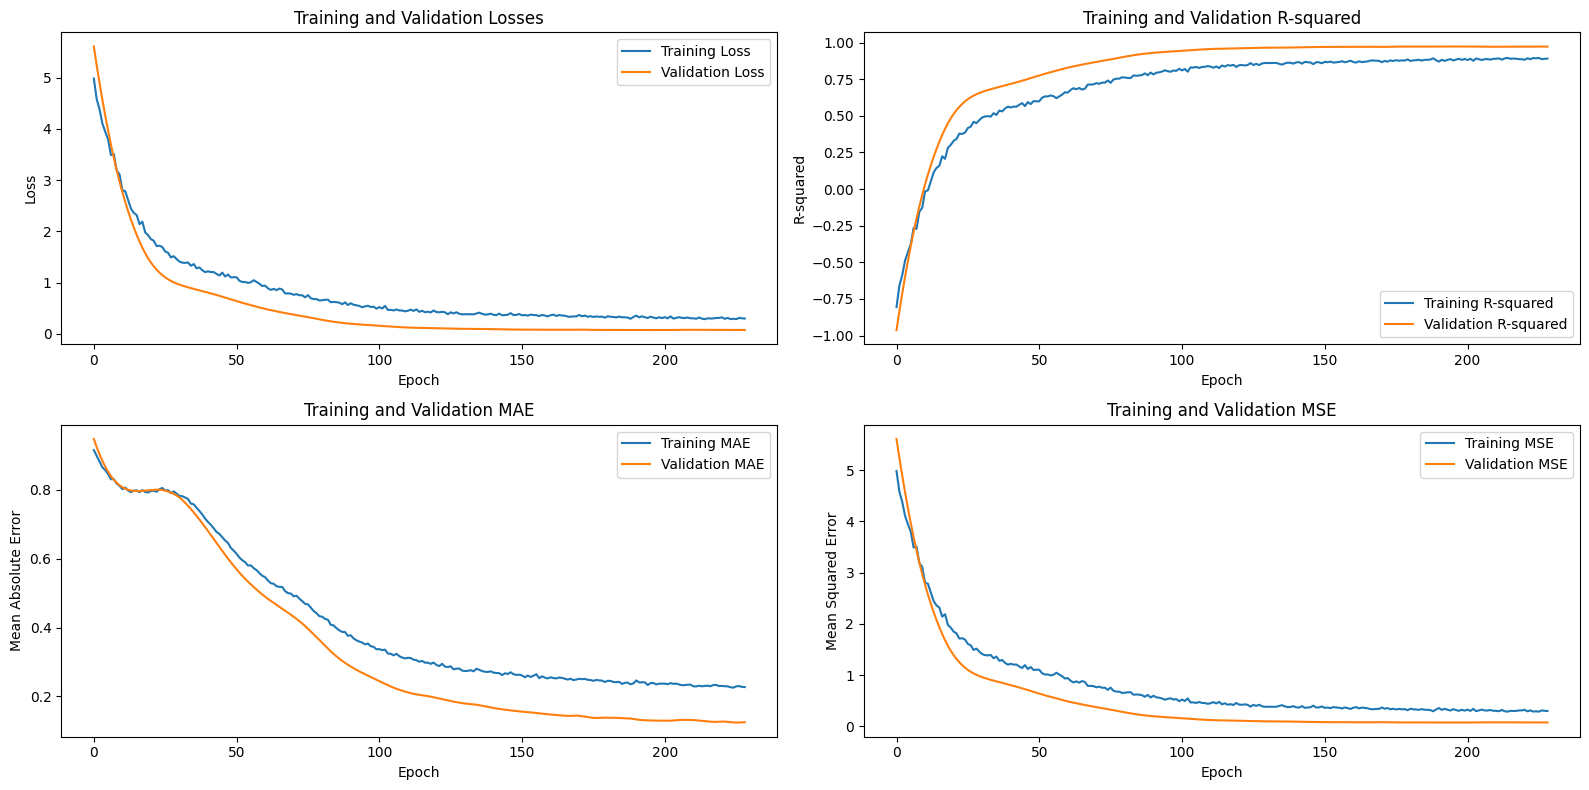

Test Loss: 0.09898356348276138, Test R-squared: 0.9605978572309665, Test MAE: 0.11511142551898956, Test MSE: 0.09898356348276138


In [89]:
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_LONDON.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_LONDON.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_LONDON.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)

    # !!! de prijs wordt nog bijgehoud als feature maar de node zijn eigen prijs wordt telkens gemasked zodat de nodes van de
    # prijzen van hun neighbours kunnen leren maar niet hun eigen prijs gebruiken
    def forward(self, x, edge_index):
        # Assuming 'price' is the second feature in the input tensor x
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Second convolutional layer with dropout
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Third convolutional layer
        x = self.conv3(x, edge_index)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 50, 60)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, out_channels=1, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    y_train_t = torch.tensor(train_prices_pegnn, dtype=torch.float).view(-1, 1)
    y_val_t = torch.tensor(val_prices_pegnn, dtype=torch.float).view(-1, 1)

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train_t)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val_t)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], out_channels=1, dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

y_train = torch.tensor(train_prices_pegnn, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn, dtype=torch.float).view(-1, 1)

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')



PE-GNN model
Hier kan het model terug ingeladen worden indien er een versie is opgeslagen.

Best parameters:  {'hidden_channels': 92, 'lr': 0.009525877655075697, 'k': 6}


Final training:   0%|          | 2/500 [00:00<00:38, 13.08it/s]

Epoch 1, Training Loss: 15.917579650878906, Training R-squared: 0.9994395210528413, Training MAE: 2.8471717834472656, Training MSE: 15.917580604553223
Epoch 1, Validation Loss: 22693.396484375, Validation R-squared: 0.6094890337510126, Validation MAE: 121.41632080078125, Validation MSE: 22693.39453125
Epoch 2, Training Loss: 6871.4814453125, Training R-squared: 0.7580460902077482, Training MAE: 79.67977905273438, Training MSE: 6871.4814453125
Epoch 2, Validation Loss: 9684.5712890625, Validation R-squared: 0.8333466042763171, Validation MAE: 63.06240463256836, Validation MSE: 9684.5703125
Epoch 3, Training Loss: 524.8209838867188, Training R-squared: 0.9815203632855962, Training MAE: 21.517683029174805, Training MSE: 524.8209838867188
Epoch 3, Validation Loss: 4495.3310546875, Validation R-squared: 0.9226437420421464, Validation MAE: 42.32233428955078, Validation MSE: 4495.3310546875


Final training:   1%|          | 6/500 [00:00<00:35, 13.87it/s]

Epoch 4, Training Loss: 1893.279296875, Training R-squared: 0.9333351392805946, Training MAE: 41.78708267211914, Training MSE: 1893.279296875
Epoch 4, Validation Loss: 4748.19677734375, Validation R-squared: 0.9182923849116003, Validation MAE: 52.67501449584961, Validation MSE: 4748.19677734375
Epoch 5, Training Loss: 3907.028564453125, Training R-squared: 0.8624283576425282, Training MAE: 60.267852783203125, Training MSE: 3907.029052734375
Epoch 5, Validation Loss: 4643.91064453125, Validation R-squared: 0.9200869677115345, Validation MAE: 43.90647888183594, Validation MSE: 4643.91064453125
Epoch 6, Training Loss: 2100.20556640625, Training R-squared: 0.926048995256976, Training MAE: 43.82090759277344, Training MSE: 2100.20556640625
Epoch 6, Validation Loss: 5973.09765625, Validation R-squared: 0.8972141432113674, Validation MAE: 37.603668212890625, Validation MSE: 5973.09716796875


Final training:   2%|▏         | 8/500 [00:00<00:36, 13.49it/s]

Epoch 7, Training Loss: 232.7820281982422, Training R-squared: 0.9918034386609749, Training MAE: 13.536966323852539, Training MSE: 232.78199768066406
Epoch 7, Validation Loss: 9347.7578125, Validation R-squared: 0.83914252324162, Validation MAE: 58.74917984008789, Validation MSE: 9347.7587890625
Epoch 8, Training Loss: 323.6675720214844, Training R-squared: 0.9886032373688644, Training MAE: 16.77066993713379, Training MSE: 323.6675720214844
Epoch 8, Validation Loss: 12648.4736328125, Validation R-squared: 0.7823433610699306, Validation MAE: 77.94081115722656, Validation MSE: 12648.4736328125
Epoch 9, Training Loss: 1425.1346435546875, Training R-squared: 0.9498191296097261, Training MAE: 36.084495544433594, Training MSE: 1425.1346435546875
Epoch 9, Validation Loss: 13740.8515625, Validation R-squared: 0.7635455875784486, Validation MAE: 83.16178131103516, Validation MSE: 13740.8515625


Final training:   2%|▏         | 12/500 [00:00<00:35, 13.73it/s]

Epoch 10, Training Loss: 1889.964111328125, Training R-squared: 0.9334518760351296, Training MAE: 41.43059158325195, Training MSE: 1889.9639892578125
Epoch 10, Validation Loss: 12449.0283203125, Validation R-squared: 0.7857754436870821, Validation MAE: 76.37670135498047, Validation MSE: 12449.029296875
Epoch 11, Training Loss: 1358.7474365234375, Training R-squared: 0.9521567156711964, Training MAE: 34.798702239990234, Training MSE: 1358.747314453125
Epoch 11, Validation Loss: 9878.9501953125, Validation R-squared: 0.8300016883648573, Validation MAE: 61.55228042602539, Validation MSE: 9878.951171875
Epoch 12, Training Loss: 483.8902893066406, Training R-squared: 0.9829615851598182, Training MAE: 19.990863800048828, Training MSE: 483.8902587890625
Epoch 12, Validation Loss: 7369.6904296875, Validation R-squared: 0.8731813866360014, Validation MAE: 45.05942916870117, Validation MSE: 7369.68994140625


Final training:   3%|▎         | 14/500 [00:01<00:34, 13.97it/s]

Epoch 13, Training Loss: 54.35941696166992, Training R-squared: 0.998085933312505, Training MAE: 5.730947971343994, Training MSE: 54.35941696166992
Epoch 13, Validation Loss: 5777.29541015625, Validation R-squared: 0.900583526093972, Validation MAE: 37.959564208984375, Validation MSE: 5777.29541015625
Epoch 14, Training Loss: 329.4663391113281, Training R-squared: 0.9883990564821168, Training MAE: 16.43259048461914, Training MSE: 329.4663391113281
Epoch 14, Validation Loss: 5156.52978515625, Validation R-squared: 0.9112657326871346, Validation MAE: 38.9520149230957, Validation MSE: 5156.5302734375
Epoch 15, Training Loss: 840.8353881835938, Training R-squared: 0.9703930778540862, Training MAE: 27.46747589111328, Training MSE: 840.8353881835938
Epoch 15, Validation Loss: 5134.04931640625, Validation R-squared: 0.9116525890554776, Validation MAE: 39.75910949707031, Validation MSE: 5134.04931640625


Final training:   4%|▎         | 18/500 [00:01<00:33, 14.25it/s]

Epoch 16, Training Loss: 962.6277465820312, Training R-squared: 0.9661046096236453, Training MAE: 29.439083099365234, Training MSE: 962.627685546875
Epoch 16, Validation Loss: 5542.3759765625, Validation R-squared: 0.9046260500425719, Validation MAE: 39.08417510986328, Validation MSE: 5542.3759765625
Epoch 17, Training Loss: 610.7822875976562, Training R-squared: 0.9784935511052151, Training MAE: 22.992908477783203, Training MSE: 610.7823486328125
Epoch 17, Validation Loss: 6471.076171875, Validation R-squared: 0.8886448544510929, Validation MAE: 40.54080581665039, Validation MSE: 6471.076171875
Epoch 18, Training Loss: 188.9099578857422, Training R-squared: 0.9933482316218591, Training MAE: 11.628174781799316, Training MSE: 188.9099578857422
Epoch 18, Validation Loss: 7874.48583984375, Validation R-squared: 0.8644947826196485, Validation MAE: 47.192710876464844, Validation MSE: 7874.486328125


Final training:   4%|▍         | 20/500 [00:01<00:34, 13.96it/s]

Epoch 19, Training Loss: 68.87515258789062, Training R-squared: 0.9975748150920515, Training MAE: 6.5905938148498535, Training MSE: 68.87515258789062
Epoch 19, Validation Loss: 9344.685546875, Validation R-squared: 0.839195380957922, Validation MAE: 55.95717239379883, Validation MSE: 9344.6865234375
Epoch 20, Training Loss: 258.23992919921875, Training R-squared: 0.990907032308828, Training MAE: 13.953140258789062, Training MSE: 258.23992919921875
Epoch 20, Validation Loss: 10304.7265625, Validation R-squared: 0.8226748729291393, Validation MAE: 61.69927215576172, Validation MSE: 10304.7265625
Epoch 21, Training Loss: 485.96942138671875, Training R-squared: 0.982888375283791, Training MAE: 19.878177642822266, Training MSE: 485.9694519042969
Epoch 21, Validation Loss: 10392.0693359375, Validation R-squared: 0.8211718873562524, Validation MAE: 62.255680084228516, Validation MSE: 10392.068359375


Final training:   5%|▍         | 24/500 [00:01<00:35, 13.36it/s]

Epoch 22, Training Loss: 514.002685546875, Training R-squared: 0.981901289992129, Training MAE: 20.54091453552246, Training MSE: 514.0026245117188
Epoch 22, Validation Loss: 9654.8681640625, Validation R-squared: 0.8338577645103912, Validation MAE: 57.91336441040039, Validation MSE: 9654.8662109375
Epoch 23, Training Loss: 334.7552795410156, Training R-squared: 0.9882128264317573, Training MAE: 16.162734985351562, Training MSE: 334.7552490234375
Epoch 23, Validation Loss: 8463.6181640625, Validation R-squared: 0.8543569190675819, Validation MAE: 50.65342330932617, Validation MSE: 8463.619140625
Epoch 24, Training Loss: 125.48320007324219, Training R-squared: 0.9955815714579922, Training MAE: 9.141181945800781, Training MSE: 125.48320007324219
Epoch 24, Validation Loss: 7274.17578125, Validation R-squared: 0.8748250054137988, Validation MAE: 43.7454833984375, Validation MSE: 7274.17529296875


Final training:   5%|▌         | 26/500 [00:01<00:34, 13.70it/s]

Epoch 25, Training Loss: 63.20061111450195, Training R-squared: 0.9977746233944425, Training MAE: 6.037639141082764, Training MSE: 63.20061111450195
Epoch 25, Validation Loss: 6407.55859375, Validation R-squared: 0.8897378731884026, Validation MAE: 39.823143005371094, Validation MSE: 6407.55859375
Epoch 26, Training Loss: 164.90777587890625, Training R-squared: 0.9941933807110005, Training MAE: 10.542959213256836, Training MSE: 164.90774536132812
Epoch 26, Validation Loss: 5969.59033203125, Validation R-squared: 0.8972744739223212, Validation MAE: 38.50592803955078, Validation MSE: 5969.5908203125
Epoch 27, Training Loss: 287.3383483886719, Training R-squared: 0.9898824391168362, Training MAE: 14.845039367675781, Training MSE: 287.3383483886719
Epoch 27, Validation Loss: 5938.83447265625, Validation R-squared: 0.8978037374586085, Validation MAE: 38.34989547729492, Validation MSE: 5938.83447265625


Final training:   6%|▌         | 30/500 [00:02<00:33, 14.02it/s]

Epoch 28, Training Loss: 288.5320739746094, Training R-squared: 0.989840405173107, Training MAE: 15.078268051147461, Training MSE: 288.5320739746094
Epoch 28, Validation Loss: 6282.6337890625, Validation R-squared: 0.8918875831577976, Validation MAE: 39.28594207763672, Validation MSE: 6282.63427734375
Epoch 29, Training Loss: 173.1842498779297, Training R-squared: 0.9939019550465521, Training MAE: 11.310808181762695, Training MSE: 173.18421936035156
Epoch 29, Validation Loss: 6953.16796875, Validation R-squared: 0.880348954897743, Validation MAE: 42.3487663269043, Validation MSE: 6953.16796875
Epoch 30, Training Loss: 63.51634979248047, Training R-squared: 0.9977635055514237, Training MAE: 6.13461971282959, Training MSE: 63.516353607177734
Epoch 30, Validation Loss: 7802.51904296875, Validation R-squared: 0.8657332048790557, Validation MAE: 47.08926010131836, Validation MSE: 7802.51904296875


Final training:   6%|▋         | 32/500 [00:02<00:34, 13.41it/s]

Epoch 31, Training Loss: 54.939579010009766, Training R-squared: 0.9980655050066639, Training MAE: 5.916208267211914, Training MSE: 54.93958282470703
Epoch 31, Validation Loss: 8565.880859375, Validation R-squared: 0.852597177171434, Validation MAE: 51.57127380371094, Validation MSE: 8565.880859375
Epoch 32, Training Loss: 126.99552154541016, Training R-squared: 0.9955283202736956, Training MAE: 9.404043197631836, Training MSE: 126.99552154541016
Epoch 32, Validation Loss: 8971.4560546875, Validation R-squared: 0.8456179701274509, Validation MAE: 53.85279083251953, Validation MSE: 8971.4560546875
Epoch 33, Training Loss: 185.32337951660156, Training R-squared: 0.9934745205498162, Training MAE: 11.552667617797852, Training MSE: 185.32337951660156
Epoch 33, Validation Loss: 8887.3134765625, Validation R-squared: 0.8470659328654495, Validation MAE: 53.204341888427734, Validation MSE: 8887.3134765625


Final training:   7%|▋         | 36/500 [00:02<00:35, 13.25it/s]

Epoch 34, Training Loss: 166.05105590820312, Training R-squared: 0.994153123256045, Training MAE: 10.861541748046875, Training MSE: 166.05105590820312
Epoch 34, Validation Loss: 8384.66015625, Validation R-squared: 0.8557156466804172, Validation MAE: 50.101356506347656, Validation MSE: 8384.6611328125
Epoch 35, Training Loss: 91.73041534423828, Training R-squared: 0.9967700515246539, Training MAE: 7.776834011077881, Training MSE: 91.73041534423828
Epoch 35, Validation Loss: 7681.609375, Validation R-squared: 0.8678138279089115, Validation MAE: 45.938446044921875, Validation MSE: 7681.60986328125
Epoch 36, Training Loss: 36.66448211669922, Training R-squared: 0.9987089951922759, Training MAE: 4.640765190124512, Training MSE: 36.664485931396484
Epoch 36, Validation Loss: 7021.0087890625, Validation R-squared: 0.8791815349564207, Validation MAE: 42.42705154418945, Validation MSE: 7021.0087890625


Final training:   8%|▊         | 38/500 [00:02<00:35, 13.07it/s]

Epoch 37, Training Loss: 46.6035041809082, Training R-squared: 0.9983590293932469, Training MAE: 5.333884239196777, Training MSE: 46.60350036621094
Epoch 37, Validation Loss: 6569.8310546875, Validation R-squared: 0.886945465392484, Validation MAE: 40.36614990234375, Validation MSE: 6569.8310546875
Epoch 38, Training Loss: 94.61339569091797, Training R-squared: 0.9966685380057072, Training MAE: 8.0286865234375, Training MSE: 94.61338806152344
Epoch 38, Validation Loss: 6397.05126953125, Validation R-squared: 0.889918675849726, Validation MAE: 39.66617965698242, Validation MSE: 6397.0517578125
Epoch 39, Training Loss: 117.6800765991211, Training R-squared: 0.9958563299297881, Training MAE: 9.007392883300781, Training MSE: 117.68006134033203
Epoch 39, Validation Loss: 6506.77001953125, Validation R-squared: 0.8880306325190868, Validation MAE: 40.160057067871094, Validation MSE: 6506.77001953125


Final training:   8%|▊         | 42/500 [00:03<00:34, 13.45it/s]

Epoch 40, Training Loss: 89.68746948242188, Training R-squared: 0.9968419861704062, Training MAE: 7.611365795135498, Training MSE: 89.68746948242188
Epoch 40, Validation Loss: 6858.5595703125, Validation R-squared: 0.8819769900709524, Validation MAE: 42.04957580566406, Validation MSE: 6858.5595703125
Epoch 41, Training Loss: 44.34648513793945, Training R-squared: 0.9984385017722507, Training MAE: 5.087131977081299, Training MSE: 44.34648895263672
Epoch 41, Validation Loss: 7351.9306640625, Validation R-squared: 0.8734869920988684, Validation MAE: 44.98152160644531, Validation MSE: 7351.93017578125
Epoch 42, Training Loss: 28.35784912109375, Training R-squared: 0.9990014828188288, Training MAE: 4.156811714172363, Training MSE: 28.35784912109375
Epoch 42, Validation Loss: 7824.73486328125, Validation R-squared: 0.8653509011199285, Validation MAE: 47.83908462524414, Validation MSE: 7824.73583984375


Final training:   9%|▉         | 44/500 [00:03<00:33, 13.45it/s]

Epoch 43, Training Loss: 48.47416687011719, Training R-squared: 0.9982931606752831, Training MAE: 5.77118444442749, Training MSE: 48.47416687011719
Epoch 43, Validation Loss: 8107.12646484375, Validation R-squared: 0.8604914833835807, Validation MAE: 49.397830963134766, Validation MSE: 8107.1259765625
Epoch 44, Training Loss: 71.74594116210938, Training R-squared: 0.9974737308991746, Training MAE: 7.137589931488037, Training MSE: 71.74594116210938
Epoch 44, Validation Loss: 8103.94091796875, Validation R-squared: 0.8605462978059781, Validation MAE: 49.10663986206055, Validation MSE: 8103.94091796875
Epoch 45, Training Loss: 68.52863311767578, Training R-squared: 0.9975870163285449, Training MAE: 6.821102142333984, Training MSE: 68.52864074707031
Epoch 45, Validation Loss: 7840.65283203125, Validation R-squared: 0.8650769844169366, Validation MAE: 47.28672409057617, Validation MSE: 7840.65283203125


Final training:  10%|▉         | 48/500 [00:03<00:32, 13.72it/s]

Epoch 46, Training Loss: 43.984989166259766, Training R-squared: 0.9984512305287301, Training MAE: 5.231081962585449, Training MSE: 43.984989166259766
Epoch 46, Validation Loss: 7439.45751953125, Validation R-squared: 0.8719808159735767, Validation MAE: 44.8250617980957, Validation MSE: 7439.45751953125
Epoch 47, Training Loss: 26.360410690307617, Training R-squared: 0.9990718152111158, Training MAE: 3.953195571899414, Training MSE: 26.360410690307617
Epoch 47, Validation Loss: 7050.18359375, Validation R-squared: 0.8786795031258474, Validation MAE: 42.701637268066406, Validation MSE: 7050.18359375
Epoch 48, Training Loss: 31.435880661010742, Training R-squared: 0.998893101326396, Training MAE: 4.36080265045166, Training MSE: 31.435876846313477
Epoch 48, Validation Loss: 6788.04833984375, Validation R-squared: 0.8831903500430204, Validation MAE: 41.3896369934082, Validation MSE: 6788.048828125


Final training:  10%|█         | 50/500 [00:03<00:32, 13.90it/s]

Epoch 49, Training Loss: 46.05990982055664, Training R-squared: 0.9983781698758744, Training MAE: 5.523073673248291, Training MSE: 46.059906005859375
Epoch 49, Validation Loss: 6710.17236328125, Validation R-squared: 0.8845304519761181, Validation MAE: 41.068851470947266, Validation MSE: 6710.171875
Epoch 50, Training Loss: 48.166229248046875, Training R-squared: 0.998304003682338, Training MAE: 5.608381748199463, Training MSE: 48.166229248046875
Epoch 50, Validation Loss: 6819.33740234375, Validation R-squared: 0.8826519233050224, Validation MAE: 41.77642059326172, Validation MSE: 6819.337890625
Epoch 51, Training Loss: 34.930782318115234, Training R-squared: 0.9987700412108033, Training MAE: 4.5463948249816895, Training MSE: 34.930782318115234
Epoch 51, Validation Loss: 7067.84814453125, Validation R-squared: 0.8783755286745165, Validation MAE: 43.37058639526367, Validation MSE: 7067.84814453125


Final training:  11%|█         | 54/500 [00:03<00:30, 14.60it/s]

Epoch 52, Training Loss: 23.098064422607422, Training R-squared: 0.9991866866791347, Training MAE: 3.6481738090515137, Training MSE: 23.098064422607422
Epoch 52, Validation Loss: 7362.015625, Validation R-squared: 0.8733134618048535, Validation MAE: 45.2797737121582, Validation MSE: 7362.01513671875
Epoch 53, Training Loss: 24.98278045654297, Training R-squared: 0.9991203233679057, Training MAE: 3.988128900527954, Training MSE: 24.98278045654297
Epoch 53, Validation Loss: 7588.18896484375, Validation R-squared: 0.8694214182630062, Validation MAE: 46.67139434814453, Validation MSE: 7588.18994140625
Epoch 54, Training Loss: 33.938446044921875, Training R-squared: 0.9988049826042082, Training MAE: 4.801497459411621, Training MSE: 33.938446044921875
Epoch 54, Validation Loss: 7661.3955078125, Validation R-squared: 0.8681616783869357, Validation MAE: 46.93604278564453, Validation MSE: 7661.3955078125
Epoch 55, Training Loss: 35.70585250854492, Training R-squared: 0.9987427498145189, Trainin

Final training:  12%|█▏        | 58/500 [00:04<00:30, 14.50it/s]

Epoch 56, Training Loss: 27.390056610107422, Training R-squared: 0.9990355599840911, Training MAE: 4.176353931427002, Training MSE: 27.390056610107422
Epoch 56, Validation Loss: 7357.39306640625, Validation R-squared: 0.8733929881247547, Validation MAE: 44.5908203125, Validation MSE: 7357.3935546875
Epoch 57, Training Loss: 19.46494483947754, Training R-squared: 0.9993146136960775, Training MAE: 3.3909876346588135, Training MSE: 19.46494483947754
Epoch 57, Validation Loss: 7127.658203125, Validation R-squared: 0.8773462912303085, Validation MAE: 43.164737701416016, Validation MSE: 7127.6591796875
Epoch 58, Training Loss: 20.629358291625977, Training R-squared: 0.9992736132191791, Training MAE: 3.4517722129821777, Training MSE: 20.629356384277344
Epoch 58, Validation Loss: 6960.45263671875, Validation R-squared: 0.8802236063375225, Validation MAE: 42.24296188354492, Validation MSE: 6960.4521484375


Final training:  12%|█▏        | 60/500 [00:04<00:30, 14.21it/s]

Epoch 59, Training Loss: 26.739530563354492, Training R-squared: 0.9990584658245459, Training MAE: 4.005059242248535, Training MSE: 26.739534378051758
Epoch 59, Validation Loss: 6904.892578125, Validation R-squared: 0.8811796760709151, Validation MAE: 41.98874282836914, Validation MSE: 6904.89306640625
Epoch 60, Training Loss: 27.861753463745117, Training R-squared: 0.9990189509895463, Training MAE: 4.089171409606934, Training MSE: 27.861753463745117
Epoch 60, Validation Loss: 6968.26123046875, Validation R-squared: 0.880089230857673, Validation MAE: 42.43984603881836, Validation MSE: 6968.26123046875
Epoch 61, Training Loss: 22.159971237182617, Training R-squared: 0.9992197182746866, Training MAE: 3.5611343383789062, Training MSE: 22.159969329833984
Epoch 61, Validation Loss: 7117.59130859375, Validation R-squared: 0.8775195297649471, Validation MAE: 43.461692810058594, Validation MSE: 7117.59130859375


Final training:  13%|█▎        | 64/500 [00:04<00:30, 14.40it/s]

Epoch 62, Training Loss: 17.143211364746094, Training R-squared: 0.9993963649573283, Training MAE: 3.13991641998291, Training MSE: 17.143211364746094
Epoch 62, Validation Loss: 7288.3037109375, Validation R-squared: 0.8745818844592578, Validation MAE: 44.63759231567383, Validation MSE: 7288.30419921875
Epoch 63, Training Loss: 18.25956153869629, Training R-squared: 0.9993570568228948, Training MAE: 3.3558058738708496, Training MSE: 18.259559631347656
Epoch 63, Validation Loss: 7407.490234375, Validation R-squared: 0.8725309172839104, Validation MAE: 45.42547607421875, Validation MSE: 7407.490234375
Epoch 64, Training Loss: 22.042476654052734, Training R-squared: 0.9992238554063696, Training MAE: 3.78271484375, Training MSE: 22.042476654052734
Epoch 64, Validation Loss: 7427.1123046875, Validation R-squared: 0.8721932534139945, Validation MAE: 45.4641227722168, Validation MSE: 7427.1123046875


Final training:  13%|█▎        | 66/500 [00:04<00:30, 14.33it/s]

Epoch 65, Training Loss: 22.198026657104492, Training R-squared: 0.9992183782465218, Training MAE: 3.792322874069214, Training MSE: 22.198026657104492
Epoch 65, Validation Loss: 7347.04443359375, Validation R-squared: 0.8735710826741504, Validation MAE: 44.797054290771484, Validation MSE: 7347.0439453125
Epoch 66, Training Loss: 18.42037582397461, Training R-squared: 0.9993513943598357, Training MAE: 3.3701744079589844, Training MSE: 18.42037582397461
Epoch 66, Validation Loss: 7211.27294921875, Validation R-squared: 0.8759074550470178, Validation MAE: 43.793880462646484, Validation MSE: 7211.2724609375
Epoch 67, Training Loss: 15.781100273132324, Training R-squared: 0.9994443266643586, Training MAE: 3.0272936820983887, Training MSE: 15.78110122680664
Epoch 67, Validation Loss: 7081.8701171875, Validation R-squared: 0.8781342324007235, Validation MAE: 42.91386795043945, Validation MSE: 7081.8701171875


Final training:  14%|█▍        | 70/500 [00:05<00:30, 14.15it/s]

Epoch 68, Training Loss: 16.964340209960938, Training R-squared: 0.99940266320627, Training MAE: 3.100142240524292, Training MSE: 16.964340209960938
Epoch 68, Validation Loss: 7009.9365234375, Validation R-squared: 0.8793720773372236, Validation MAE: 42.453712463378906, Validation MSE: 7009.9365234375
Epoch 69, Training Loss: 18.96339225769043, Training R-squared: 0.9993322740030788, Training MAE: 3.292194128036499, Training MSE: 18.96339225769043
Epoch 69, Validation Loss: 7018.2802734375, Validation R-squared: 0.8792285009238763, Validation MAE: 42.52096939086914, Validation MSE: 7018.27978515625
Epoch 70, Training Loss: 18.223983764648438, Training R-squared: 0.9993583094800631, Training MAE: 3.2205498218536377, Training MSE: 18.223983764648438
Epoch 70, Validation Loss: 7097.046875, Validation R-squared: 0.8778730687413164, Validation MAE: 43.05197525024414, Validation MSE: 7097.046875


Final training:  14%|█▍        | 72/500 [00:05<00:30, 14.22it/s]

Epoch 71, Training Loss: 15.752649307250977, Training R-squared: 0.9994453284952751, Training MAE: 2.9952447414398193, Training MSE: 15.75264835357666
Epoch 71, Validation Loss: 7208.68212890625, Validation R-squared: 0.8759520406880263, Validation MAE: 43.81808090209961, Validation MSE: 7208.68212890625
Epoch 72, Training Loss: 14.884933471679688, Training R-squared: 0.9994758818606944, Training MAE: 2.962412118911743, Training MSE: 14.884934425354004
Epoch 72, Validation Loss: 7302.52880859375, Validation R-squared: 0.8743371058077473, Validation MAE: 44.468936920166016, Validation MSE: 7302.52880859375
Epoch 73, Training Loss: 16.07210922241211, Training R-squared: 0.9994340798271797, Training MAE: 3.136787176132202, Training MSE: 16.07210922241211
Epoch 73, Validation Loss: 7337.30810546875, Validation R-squared: 0.8737386280770278, Validation MAE: 44.6961784362793, Validation MSE: 7337.3076171875


Final training:  15%|█▌        | 76/500 [00:05<00:29, 14.38it/s]

Epoch 74, Training Loss: 16.728187561035156, Training R-squared: 0.9994109784824708, Training MAE: 3.2218821048736572, Training MSE: 16.728187561035156
Epoch 74, Validation Loss: 7301.09130859375, Validation R-squared: 0.8743618266660005, Validation MAE: 44.41720962524414, Validation MSE: 7301.091796875
Epoch 75, Training Loss: 15.514018058776855, Training R-squared: 0.9994537309301965, Training MAE: 3.0716302394866943, Training MSE: 15.514019966125488
Epoch 75, Validation Loss: 7215.65869140625, Validation R-squared: 0.8758319756070666, Validation MAE: 43.80424499511719, Validation MSE: 7215.6591796875
Epoch 76, Training Loss: 14.106782913208008, Training R-squared: 0.9995032816234211, Training MAE: 2.873802661895752, Training MSE: 14.106782913208008
Epoch 76, Validation Loss: 7122.86865234375, Validation R-squared: 0.8774287224539181, Validation MAE: 43.166202545166016, Validation MSE: 7122.86865234375


Final training:  16%|█▌        | 78/500 [00:05<00:29, 14.38it/s]

Epoch 77, Training Loss: 14.246441841125488, Training R-squared: 0.9994983640666572, Training MAE: 2.8430826663970947, Training MSE: 14.246439933776855
Epoch 77, Validation Loss: 7063.21728515625, Validation R-squared: 0.8784552094521803, Validation MAE: 42.76601028442383, Validation MSE: 7063.21728515625
Epoch 78, Training Loss: 15.112279891967773, Training R-squared: 0.9994678767175398, Training MAE: 2.9131922721862793, Training MSE: 15.112279891967773
Epoch 78, Validation Loss: 7059.06640625, Validation R-squared: 0.8785266391583194, Validation MAE: 42.73089599609375, Validation MSE: 7059.06640625
Epoch 79, Training Loss: 14.924437522888184, Training R-squared: 0.9994744909194155, Training MAE: 2.8942041397094727, Training MSE: 14.924437522888184
Epoch 79, Validation Loss: 7107.78173828125, Validation R-squared: 0.8776883446034941, Validation MAE: 43.04386901855469, Validation MSE: 7107.78173828125


Final training:  16%|█▋        | 82/500 [00:05<00:29, 14.41it/s]

Epoch 80, Training Loss: 13.783864974975586, Training R-squared: 0.9995146520081795, Training MAE: 2.792491912841797, Training MSE: 13.783864974975586
Epoch 80, Validation Loss: 7184.32763671875, Validation R-squared: 0.876371130045395, Validation MAE: 43.54874038696289, Validation MSE: 7184.3271484375
Epoch 81, Training Loss: 13.240705490112305, Training R-squared: 0.9995337772757944, Training MAE: 2.7724714279174805, Training MSE: 13.240707397460938
Epoch 81, Validation Loss: 7252.39990234375, Validation R-squared: 0.8751997193338823, Validation MAE: 43.99650955200195, Validation MSE: 7252.400390625
Epoch 82, Training Loss: 13.713967323303223, Training R-squared: 0.9995171131437164, Training MAE: 2.8585357666015625, Training MSE: 13.713967323303223
Epoch 82, Validation Loss: 7281.25341796875, Validation R-squared: 0.8747032050378933, Validation MAE: 44.17204666137695, Validation MSE: 7281.25390625


Final training:  17%|█▋        | 84/500 [00:06<00:28, 14.45it/s]

Epoch 83, Training Loss: 14.03189468383789, Training R-squared: 0.9995059185597787, Training MAE: 2.904371738433838, Training MSE: 14.031892776489258
Epoch 83, Validation Loss: 7260.53173828125, Validation R-squared: 0.8750598031843042, Validation MAE: 44.006065368652344, Validation MSE: 7260.53076171875
Epoch 84, Training Loss: 13.468663215637207, Training R-squared: 0.9995257506149344, Training MAE: 2.8268768787384033, Training MSE: 13.468664169311523
Epoch 84, Validation Loss: 7204.12744140625, Validation R-squared: 0.8760304001882572, Validation MAE: 43.60953903198242, Validation MSE: 7204.1279296875
Epoch 85, Training Loss: 12.775768280029297, Training R-squared: 0.999550148406823, Training MAE: 2.720219612121582, Training MSE: 12.775768280029297
Epoch 85, Validation Loss: 7141.0810546875, Validation R-squared: 0.8771153267446047, Validation MAE: 43.1895866394043, Validation MSE: 7141.0810546875


Final training:  18%|█▊        | 88/500 [00:06<00:30, 13.60it/s]

Epoch 86, Training Loss: 12.783863067626953, Training R-squared: 0.9995498633436692, Training MAE: 2.6935956478118896, Training MSE: 12.783863067626953
Epoch 86, Validation Loss: 7100.13671875, Validation R-squared: 0.877819906810096, Validation MAE: 42.933292388916016, Validation MSE: 7100.13623046875
Epoch 87, Training Loss: 13.108847618103027, Training R-squared: 0.9995384202017714, Training MAE: 2.714921474456787, Training MSE: 13.108848571777344
Epoch 87, Validation Loss: 7097.0048828125, Validation R-squared: 0.8778737900749176, Validation MAE: 42.931270599365234, Validation MSE: 7097.0048828125
Epoch 88, Training Loss: 12.957110404968262, Training R-squared: 0.9995437630286209, Training MAE: 2.699251890182495, Training MSE: 12.957112312316895
Epoch 88, Validation Loss: 7128.9619140625, Validation R-squared: 0.87732385351604, Validation MAE: 43.158790588378906, Validation MSE: 7128.962890625


Final training:  18%|█▊        | 90/500 [00:06<00:29, 13.69it/s]

Epoch 89, Training Loss: 12.438502311706543, Training R-squared: 0.999562023968315, Training MAE: 2.659210205078125, Training MSE: 12.438502311706543
Epoch 89, Validation Loss: 7177.5166015625, Validation R-squared: 0.8764883333346616, Validation MAE: 43.490543365478516, Validation MSE: 7177.5166015625
Epoch 90, Training Loss: 12.227909088134766, Training R-squared: 0.9995694392054009, Training MAE: 2.6615164279937744, Training MSE: 12.227909088134766
Epoch 90, Validation Loss: 7217.75634765625, Validation R-squared: 0.8757958752533966, Validation MAE: 43.752098083496094, Validation MSE: 7217.7568359375
Epoch 91, Training Loss: 12.390571594238281, Training R-squared: 0.9995637117052554, Training MAE: 2.7016921043395996, Training MSE: 12.390570640563965
Epoch 91, Validation Loss: 7230.75390625, Validation R-squared: 0.875572217506298, Validation MAE: 43.81214141845703, Validation MSE: 7230.75390625


Final training:  19%|█▉        | 94/500 [00:06<00:32, 12.36it/s]

Epoch 92, Training Loss: 12.389406204223633, Training R-squared: 0.9995637527068901, Training MAE: 2.70283842086792, Training MSE: 12.389406204223633
Epoch 92, Validation Loss: 7212.7197265625, Validation R-squared: 0.8758825510535313, Validation MAE: 43.65460968017578, Validation MSE: 7212.72021484375
Epoch 93, Training Loss: 12.059253692626953, Training R-squared: 0.9995753777950657, Training MAE: 2.6490209102630615, Training MSE: 12.059253692626953
Epoch 93, Validation Loss: 7175.60107421875, Validation R-squared: 0.8765212967370287, Validation MAE: 43.377960205078125, Validation MSE: 7175.60107421875
Epoch 94, Training Loss: 11.81095027923584, Training R-squared: 0.9995841208788804, Training MAE: 2.6000235080718994, Training MSE: 11.81095027923584
Epoch 94, Validation Loss: 7139.27685546875, Validation R-squared: 0.8771463641569317, Validation MAE: 43.12791061401367, Validation MSE: 7139.27685546875


Final training:  19%|█▉        | 96/500 [00:07<00:33, 11.90it/s]

Epoch 95, Training Loss: 11.856963157653809, Training R-squared: 0.9995825006775305, Training MAE: 2.5892627239227295, Training MSE: 11.856963157653809
Epoch 95, Validation Loss: 7120.8388671875, Validation R-squared: 0.8774636511085385, Validation MAE: 43.017578125, Validation MSE: 7120.83837890625
Epoch 96, Training Loss: 11.890800476074219, Training R-squared: 0.9995813092241714, Training MAE: 2.587174892425537, Training MSE: 11.890802383422852
Epoch 96, Validation Loss: 7126.73876953125, Validation R-squared: 0.877362115852421, Validation MAE: 43.082454681396484, Validation MSE: 7126.73876953125
Epoch 97, Training Loss: 11.68031120300293, Training R-squared: 0.9995887208704358, Training MAE: 2.5680575370788574, Training MSE: 11.680310249328613
Epoch 97, Validation Loss: 7150.8349609375, Validation R-squared: 0.8769474723282958, Validation MAE: 43.27344512939453, Validation MSE: 7150.8349609375


Final training:  20%|██        | 100/500 [00:07<00:34, 11.71it/s]

Epoch 98, Training Loss: 11.445352554321289, Training R-squared: 0.9995969940635973, Training MAE: 2.555497646331787, Training MSE: 11.445352554321289
Epoch 98, Validation Loss: 7178.427734375, Validation R-squared: 0.8764726653339131, Validation MAE: 43.48130416870117, Validation MSE: 7178.4267578125
Epoch 99, Training Loss: 11.418187141418457, Training R-squared: 0.999597950663945, Training MAE: 2.570387363433838, Training MSE: 11.418185234069824
Epoch 99, Validation Loss: 7194.33349609375, Validation R-squared: 0.8761989484977883, Validation MAE: 43.59306335449219, Validation MSE: 7194.33349609375
Epoch 100, Training Loss: 11.450176239013672, Training R-squared: 0.9995968241749279, Training MAE: 2.5841495990753174, Training MSE: 11.450177192687988
Epoch 100, Validation Loss: 7190.9248046875, Validation R-squared: 0.8762576005799334, Validation MAE: 43.55385208129883, Validation MSE: 7190.9248046875


Final training:  20%|██        | 102/500 [00:07<00:33, 11.80it/s]

Epoch 101, Training Loss: 11.321249961853027, Training R-squared: 0.9996013638649959, Training MAE: 2.564857006072998, Training MSE: 11.321249961853027
Epoch 101, Validation Loss: 7171.65185546875, Validation R-squared: 0.8765892559309563, Validation MAE: 43.39555740356445, Validation MSE: 7171.65185546875
Epoch 102, Training Loss: 11.122169494628906, Training R-squared: 0.9996083737947675, Training MAE: 2.5270116329193115, Training MSE: 11.122169494628906
Epoch 102, Validation Loss: 7148.10791015625, Validation R-squared: 0.8769943906413755, Validation MAE: 43.210548400878906, Validation MSE: 7148.10888671875
Epoch 103, Training Loss: 11.050859451293945, Training R-squared: 0.9996108846969679, Training MAE: 2.5041067600250244, Training MSE: 11.050859451293945
Epoch 103, Validation Loss: 7132.96337890625, Validation R-squared: 0.8772550080484302, Validation MAE: 43.09436798095703, Validation MSE: 7132.9638671875


Final training:  21%|██        | 106/500 [00:07<00:33, 11.62it/s]

Epoch 104, Training Loss: 11.060554504394531, Training R-squared: 0.9996105432800195, Training MAE: 2.496675729751587, Training MSE: 11.060556411743164
Epoch 104, Validation Loss: 7133.1103515625, Validation R-squared: 0.877252472336306, Validation MAE: 43.097381591796875, Validation MSE: 7133.11083984375
Epoch 105, Training Loss: 10.979555130004883, Training R-squared: 0.9996133954430267, Training MAE: 2.487424850463867, Training MSE: 10.979555130004883
Epoch 105, Validation Loss: 7146.66455078125, Validation R-squared: 0.877019245312993, Validation MAE: 43.205013275146484, Validation MSE: 7146.66455078125
Epoch 106, Training Loss: 10.824565887451172, Training R-squared: 0.9996188527749658, Training MAE: 2.4769976139068604, Training MSE: 10.824564933776855
Epoch 106, Validation Loss: 7164.62451171875, Validation R-squared: 0.8767101783258958, Validation MAE: 43.34998321533203, Validation MSE: 7164.625


Final training:  22%|██▏       | 108/500 [00:08<00:34, 11.33it/s]

Epoch 107, Training Loss: 10.737288475036621, Training R-squared: 0.9996219259678856, Training MAE: 2.4772984981536865, Training MSE: 10.737287521362305
Epoch 107, Validation Loss: 7176.18603515625, Validation R-squared: 0.8765112227945978, Validation MAE: 43.44920349121094, Validation MSE: 7176.1865234375
Epoch 108, Training Loss: 10.718818664550781, Training R-squared: 0.9996225762764785, Training MAE: 2.484347105026245, Training MSE: 10.718818664550781
Epoch 108, Validation Loss: 7174.82177734375, Validation R-squared: 0.8765347026888138, Validation MAE: 43.449729919433594, Validation MSE: 7174.82177734375
Epoch 109, Training Loss: 10.654605865478516, Training R-squared: 0.9996248373211295, Training MAE: 2.4779255390167236, Training MSE: 10.654605865478516
Epoch 109, Validation Loss: 7161.69970703125, Validation R-squared: 0.8767605182337925, Validation MAE: 43.35734558105469, Validation MSE: 7161.69921875


Final training:  22%|██▏       | 112/500 [00:08<00:34, 11.31it/s]

Epoch 110, Training Loss: 10.534322738647461, Training R-squared: 0.9996290725900026, Training MAE: 2.456299066543579, Training MSE: 10.534324645996094
Epoch 110, Validation Loss: 7144.54345703125, Validation R-squared: 0.8770557429142093, Validation MAE: 43.228309631347656, Validation MSE: 7144.54296875
Epoch 111, Training Loss: 10.450428009033203, Training R-squared: 0.9996320266534443, Training MAE: 2.4357523918151855, Training MSE: 10.450428009033203
Epoch 111, Validation Loss: 7132.791015625, Validation R-squared: 0.8772579729389441, Validation MAE: 43.13395309448242, Validation MSE: 7132.791015625
Epoch 112, Training Loss: 10.41580867767334, Training R-squared: 0.9996332456460261, Training MAE: 2.4240386486053467, Training MSE: 10.415809631347656
Epoch 112, Validation Loss: 7132.232421875, Validation R-squared: 0.8772675905781113, Validation MAE: 43.1198844909668, Validation MSE: 7132.232421875


Final training:  23%|██▎       | 114/500 [00:08<00:34, 11.20it/s]

Epoch 113, Training Loss: 10.355440139770508, Training R-squared: 0.9996353713288958, Training MAE: 2.4152166843414307, Training MSE: 10.355439186096191
Epoch 113, Validation Loss: 7142.08935546875, Validation R-squared: 0.877097963934514, Validation MAE: 43.18439865112305, Validation MSE: 7142.08935546875
Epoch 114, Training Loss: 10.256136894226074, Training R-squared: 0.9996388678769214, Training MAE: 2.4074442386627197, Training MSE: 10.25613784790039
Epoch 114, Validation Loss: 7155.8955078125, Validation R-squared: 0.8768603894577519, Validation MAE: 43.28376388549805, Validation MSE: 7155.8955078125
Epoch 115, Training Loss: 10.179823875427246, Training R-squared: 0.999641555014611, Training MAE: 2.405501365661621, Training MSE: 10.179823875427246


Final training:  23%|██▎       | 116/500 [00:08<00:35, 10.80it/s]

Epoch 115, Validation Loss: 7165.375, Validation R-squared: 0.8766972663156434, Validation MAE: 43.357688903808594, Validation MSE: 7165.37548828125
Epoch 116, Training Loss: 10.138463020324707, Training R-squared: 0.9996430113869196, Training MAE: 2.4065871238708496, Training MSE: 10.13846206665039
Epoch 116, Validation Loss: 7165.197265625, Validation R-squared: 0.8767003293908937, Validation MAE: 43.36504364013672, Validation MSE: 7165.19677734375
Epoch 117, Training Loss: 10.08034610748291, Training R-squared: 0.9996450577143169, Training MAE: 2.400804042816162, Training MSE: 10.08034610748291
Epoch 117, Validation Loss: 7155.80078125, Validation R-squared: 0.8768620100339114, Validation MAE: 43.30560302734375, Validation MSE: 7155.80078125


Final training:  24%|██▍       | 120/500 [00:09<00:32, 11.59it/s]

Epoch 118, Training Loss: 9.994704246520996, Training R-squared: 0.99964807328203, Training MAE: 2.386295795440674, Training MSE: 9.994704246520996
Epoch 118, Validation Loss: 7142.7880859375, Validation R-squared: 0.8770859396078069, Validation MAE: 43.21684265136719, Validation MSE: 7142.78857421875
Epoch 119, Training Loss: 9.924614906311035, Training R-squared: 0.9996505412567572, Training MAE: 2.3713674545288086, Training MSE: 9.924613952636719
Epoch 119, Validation Loss: 7133.361328125, Validation R-squared: 0.8772481630055649, Validation MAE: 43.14946365356445, Validation MSE: 7133.361328125
Epoch 120, Training Loss: 9.879372596740723, Training R-squared: 0.9996521342803658, Training MAE: 2.360673189163208, Training MSE: 9.879372596740723
Epoch 120, Validation Loss: 7132.1474609375, Validation R-squared: 0.877269055990943, Validation MAE: 43.13752365112305, Validation MSE: 7132.14697265625


Final training:  24%|██▍       | 122/500 [00:09<00:30, 12.35it/s]

Epoch 121, Training Loss: 9.823013305664062, Training R-squared: 0.9996541187632562, Training MAE: 2.352719306945801, Training MSE: 9.823013305664062
Epoch 121, Validation Loss: 7138.86083984375, Validation R-squared: 0.8771535233714461, Validation MAE: 43.18082046508789, Validation MSE: 7138.8603515625
Epoch 122, Training Loss: 9.747435569763184, Training R-squared: 0.9996567799397598, Training MAE: 2.3462164402008057, Training MSE: 9.7474365234375
Epoch 122, Validation Loss: 7148.8349609375, Validation R-squared: 0.8769818958473606, Validation MAE: 43.24814987182617, Validation MSE: 7148.833984375
Epoch 123, Training Loss: 9.682332038879395, Training R-squared: 0.9996590723388261, Training MAE: 2.342982530593872, Training MSE: 9.682332038879395
Epoch 123, Validation Loss: 7155.9658203125, Validation R-squared: 0.8768591733528124, Validation MAE: 43.29701614379883, Validation MSE: 7155.96630859375


Final training:  25%|██▌       | 126/500 [00:09<00:29, 12.83it/s]

Epoch 124, Training Loss: 9.634040832519531, Training R-squared: 0.9996607727615271, Training MAE: 2.3408031463623047, Training MSE: 9.634040832519531
Epoch 124, Validation Loss: 7156.28515625, Validation R-squared: 0.8768536915917695, Validation MAE: 43.29896545410156, Validation MSE: 7156.28515625
Epoch 125, Training Loss: 9.578510284423828, Training R-squared: 0.999662728041239, Training MAE: 2.3342418670654297, Training MSE: 9.578510284423828
Epoch 125, Validation Loss: 7150.0908203125, Validation R-squared: 0.8769602842049784, Validation MAE: 43.25544357299805, Validation MSE: 7150.09033203125
Epoch 126, Training Loss: 9.511269569396973, Training R-squared: 0.9996650956947278, Training MAE: 2.3227806091308594, Training MSE: 9.511268615722656
Epoch 126, Validation Loss: 7141.38916015625, Validation R-squared: 0.8771100135479316, Validation MAE: 43.19437789916992, Validation MSE: 7141.38916015625


Final training:  26%|██▌       | 128/500 [00:09<00:29, 12.41it/s]

Epoch 127, Training Loss: 9.451638221740723, Training R-squared: 0.999667195371457, Training MAE: 2.310804605484009, Training MSE: 9.451638221740723
Epoch 127, Validation Loss: 7135.201171875, Validation R-squared: 0.8772165164197445, Validation MAE: 43.15130615234375, Validation MSE: 7135.2001953125
Epoch 128, Training Loss: 9.40212345123291, Training R-squared: 0.9996689388359462, Training MAE: 2.3014955520629883, Training MSE: 9.40212345123291
Epoch 128, Validation Loss: 7134.58544921875, Validation R-squared: 0.8772270954252378, Validation MAE: 43.14808654785156, Validation MSE: 7134.5859375
Epoch 129, Training Loss: 9.346870422363281, Training R-squared: 0.9996708843838273, Training MAE: 2.294365406036377, Training MSE: 9.346869468688965
Epoch 129, Validation Loss: 7139.04296875, Validation R-squared: 0.8771503900589606, Validation MAE: 43.18102264404297, Validation MSE: 7139.04296875


Final training:  26%|██▋       | 132/500 [00:10<00:27, 13.32it/s]

Epoch 130, Training Loss: 9.285327911376953, Training R-squared: 0.9996730513810009, Training MAE: 2.289116382598877, Training MSE: 9.285327911376953
Epoch 130, Validation Loss: 7145.166015625, Validation R-squared: 0.8770450268486136, Validation MAE: 43.2255744934082, Validation MSE: 7145.166015625
Epoch 131, Training Loss: 9.230287551879883, Training R-squared: 0.9996749894212924, Training MAE: 2.285858631134033, Training MSE: 9.230287551879883
Epoch 131, Validation Loss: 7148.9140625, Validation R-squared: 0.8769805317357745, Validation MAE: 43.252342224121094, Validation MSE: 7148.91357421875
Epoch 132, Training Loss: 9.18081283569336, Training R-squared: 0.9996767315165107, Training MAE: 2.281888246536255, Training MSE: 9.18081283569336
Epoch 132, Validation Loss: 7148.09521484375, Validation R-squared: 0.8769946193293905, Validation MAE: 43.24519348144531, Validation MSE: 7148.09521484375


Final training:  27%|██▋       | 134/500 [00:10<00:27, 13.54it/s]

Epoch 133, Training Loss: 9.1264009475708, Training R-squared: 0.9996786474149053, Training MAE: 2.274653434753418, Training MSE: 9.1264009475708
Epoch 133, Validation Loss: 7143.5361328125, Validation R-squared: 0.8770730714211505, Validation MAE: 43.20989227294922, Validation MSE: 7143.5361328125
Epoch 134, Training Loss: 9.068986892700195, Training R-squared: 0.9996806690221564, Training MAE: 2.2647368907928467, Training MSE: 9.068986892700195
Epoch 134, Validation Loss: 7138.28369140625, Validation R-squared: 0.8771634573809597, Validation MAE: 43.168968200683594, Validation MSE: 7138.28369140625
Epoch 135, Training Loss: 9.017160415649414, Training R-squared: 0.9996824939042138, Training MAE: 2.255009651184082, Training MSE: 9.017160415649414
Epoch 135, Validation Loss: 7135.5078125, Validation R-squared: 0.8772112224904809, Validation MAE: 43.14629364013672, Validation MSE: 7135.5078125


Final training:  28%|██▊       | 138/500 [00:10<00:26, 13.88it/s]

Epoch 136, Training Loss: 8.968270301818848, Training R-squared: 0.999684215421749, Training MAE: 2.2471237182617188, Training MSE: 8.968269348144531
Epoch 136, Validation Loss: 7136.52734375, Validation R-squared: 0.8771936854509729, Validation MAE: 43.152469635009766, Validation MSE: 7136.52685546875
Epoch 137, Training Loss: 8.915287971496582, Training R-squared: 0.9996860809428195, Training MAE: 2.2407021522521973, Training MSE: 8.915287971496582
Epoch 137, Validation Loss: 7140.15185546875, Validation R-squared: 0.87713131279505, Validation MAE: 43.17951583862305, Validation MSE: 7140.15087890625
Epoch 138, Training Loss: 8.861350059509277, Training R-squared: 0.9996879802165026, Training MAE: 2.235813617706299, Training MSE: 8.861349105834961
Epoch 138, Validation Loss: 7143.66162109375, Validation R-squared: 0.8770709202284463, Validation MAE: 43.20756530761719, Validation MSE: 7143.6611328125


Final training:  28%|██▊       | 140/500 [00:10<00:26, 13.71it/s]

Epoch 139, Training Loss: 8.811802864074707, Training R-squared: 0.9996897247912864, Training MAE: 2.231807231903076, Training MSE: 8.811803817749023
Epoch 139, Validation Loss: 7144.611328125, Validation R-squared: 0.8770545616048088, Validation MAE: 43.217586517333984, Validation MSE: 7144.61181640625
Epoch 140, Training Loss: 8.763453483581543, Training R-squared: 0.9996914272518997, Training MAE: 2.2267708778381348, Training MSE: 8.763453483581543
Epoch 140, Validation Loss: 7142.369140625, Validation R-squared: 0.8770931620957784, Validation MAE: 43.20339584350586, Validation MSE: 7142.36865234375
Epoch 141, Training Loss: 8.712201118469238, Training R-squared: 0.9996932319324217, Training MAE: 2.2195000648498535, Training MSE: 8.712200164794922
Epoch 141, Validation Loss: 7138.41796875, Validation R-squared: 0.8771611493317579, Validation MAE: 43.17457962036133, Validation MSE: 7138.41748046875


Final training:  29%|██▉       | 144/500 [00:10<00:25, 13.96it/s]

Epoch 142, Training Loss: 8.661238670349121, Training R-squared: 0.9996950263498378, Training MAE: 2.211035966873169, Training MSE: 8.661239624023438
Epoch 142, Validation Loss: 7135.22998046875, Validation R-squared: 0.8772160103236765, Validation MAE: 43.149009704589844, Validation MSE: 7135.22998046875
Epoch 143, Training Loss: 8.613435745239258, Training R-squared: 0.9996967095901703, Training MAE: 2.2031619548797607, Training MSE: 8.613435745239258
Epoch 143, Validation Loss: 7134.62109375, Validation R-squared: 0.8772264911792536, Validation MAE: 43.14104461669922, Validation MSE: 7134.62109375
Epoch 144, Training Loss: 8.56563949584961, Training R-squared: 0.9996983925490426, Training MAE: 2.196301221847534, Training MSE: 8.56563949584961
Epoch 144, Validation Loss: 7136.63134765625, Validation R-squared: 0.8771918803031113, Validation MAE: 43.15266799926758, Validation MSE: 7136.6318359375


Final training:  29%|██▉       | 146/500 [00:11<00:25, 13.86it/s]

Epoch 145, Training Loss: 8.516172409057617, Training R-squared: 0.9997001343534739, Training MAE: 2.1904489994049072, Training MSE: 8.516172409057617
Epoch 145, Validation Loss: 7139.61572265625, Validation R-squared: 0.8771405391743654, Validation MAE: 43.17341232299805, Validation MSE: 7139.615234375
Epoch 146, Training Loss: 8.467838287353516, Training R-squared: 0.9997018362643687, Training MAE: 2.18552565574646, Training MSE: 8.467838287353516
Epoch 146, Validation Loss: 7141.3994140625, Validation R-squared: 0.8771098491036522, Validation MAE: 43.187904357910156, Validation MSE: 7141.39892578125
Epoch 147, Training Loss: 8.421480178833008, Training R-squared: 0.9997034685986992, Training MAE: 2.180743932723999, Training MSE: 8.421480178833008
Epoch 147, Validation Loss: 7140.72607421875, Validation R-squared: 0.8771214243615597, Validation MAE: 43.18616485595703, Validation MSE: 7140.7265625


Final training:  30%|███       | 150/500 [00:11<00:24, 14.11it/s]

Epoch 148, Training Loss: 8.374770164489746, Training R-squared: 0.9997051133138191, Training MAE: 2.1749954223632812, Training MSE: 8.374771118164062
Epoch 148, Validation Loss: 7137.98828125, Validation R-squared: 0.8771685443092164, Validation MAE: 43.16939926147461, Validation MSE: 7137.98779296875
Epoch 149, Training Loss: 8.327498435974121, Training R-squared: 0.9997067777901381, Training MAE: 2.1681718826293945, Training MSE: 8.327498435974121
Epoch 149, Validation Loss: 7134.88818359375, Validation R-squared: 0.877221884865239, Validation MAE: 43.148475646972656, Validation MSE: 7134.88818359375
Epoch 150, Training Loss: 8.281637191772461, Training R-squared: 0.9997083926904317, Training MAE: 2.1611273288726807, Training MSE: 8.281636238098145
Epoch 150, Validation Loss: 7133.24658203125, Validation R-squared: 0.8772501333012135, Validation MAE: 43.13605499267578, Validation MSE: 7133.2470703125


Final training:  30%|███       | 152/500 [00:11<00:24, 14.06it/s]

Epoch 151, Training Loss: 8.236842155456543, Training R-squared: 0.9997099699397938, Training MAE: 2.1544930934906006, Training MSE: 8.236842155456543
Epoch 151, Validation Loss: 7133.81982421875, Validation R-squared: 0.8772402726493818, Validation MAE: 43.1381950378418, Validation MSE: 7133.8193359375
Epoch 152, Training Loss: 8.191446304321289, Training R-squared: 0.9997115684046125, Training MAE: 2.148571491241455, Training MSE: 8.191445350646973
Epoch 152, Validation Loss: 7135.89111328125, Validation R-squared: 0.8772046291263881, Validation MAE: 43.15092086791992, Validation MSE: 7135.8916015625
Epoch 153, Training Loss: 8.146153450012207, Training R-squared: 0.99971316323858, Training MAE: 2.143355369567871, Training MSE: 8.14615249633789
Epoch 153, Validation Loss: 7137.86767578125, Validation R-squared: 0.8771706176952825, Validation MAE: 43.1639518737793, Validation MSE: 7137.8681640625


Final training:  31%|███       | 156/500 [00:11<00:24, 14.16it/s]

Epoch 154, Training Loss: 8.102091789245605, Training R-squared: 0.9997147146724867, Training MAE: 2.1383981704711914, Training MSE: 8.102092742919922
Epoch 154, Validation Loss: 7138.328125, Validation R-squared: 0.87716269726274, Validation MAE: 43.16761779785156, Validation MSE: 7138.328125
Epoch 155, Training Loss: 8.058551788330078, Training R-squared: 0.9997162477794959, Training MAE: 2.1330554485321045, Training MSE: 8.058551788330078
Epoch 155, Validation Loss: 7136.9609375, Validation R-squared: 0.8771862214654507, Validation MAE: 43.159297943115234, Validation MSE: 7136.9609375
Epoch 156, Training Loss: 8.014663696289062, Training R-squared: 0.9997177931426154, Training MAE: 2.1269781589508057, Training MSE: 8.014663696289062
Epoch 156, Validation Loss: 7134.63818359375, Validation R-squared: 0.8772262001589664, Validation MAE: 43.1444206237793, Validation MSE: 7134.63818359375


Final training:  32%|███▏      | 158/500 [00:11<00:24, 14.11it/s]

Epoch 157, Training Loss: 7.971165180206299, Training R-squared: 0.9997193247519746, Training MAE: 2.1205050945281982, Training MSE: 7.971166133880615
Epoch 157, Validation Loss: 7132.779296875, Validation R-squared: 0.8772581824111678, Validation MAE: 43.1323356628418, Validation MSE: 7132.77880859375
Epoch 158, Training Loss: 7.928499221801758, Training R-squared: 0.9997208271107895, Training MAE: 2.1141982078552246, Training MSE: 7.9284987449646
Epoch 158, Validation Loss: 7132.3427734375, Validation R-squared: 0.8772656743660356, Validation MAE: 43.12954330444336, Validation MSE: 7132.34423828125
Epoch 159, Training Loss: 7.885951995849609, Training R-squared: 0.9997223252460123, Training MAE: 2.108407735824585, Training MSE: 7.885951995849609
Epoch 159, Validation Loss: 7133.29833984375, Validation R-squared: 0.8772492366977034, Validation MAE: 43.13597106933594, Validation MSE: 7133.298828125


Final training:  32%|███▏      | 162/500 [00:12<00:24, 13.53it/s]

Epoch 160, Training Loss: 7.843339920043945, Training R-squared: 0.9997238256532526, Training MAE: 2.1031625270843506, Training MSE: 7.8433403968811035
Epoch 160, Validation Loss: 7134.7099609375, Validation R-squared: 0.8772249609629919, Validation MAE: 43.14541244506836, Validation MSE: 7134.70947265625
Epoch 161, Training Loss: 7.801337718963623, Training R-squared: 0.999725304617946, Training MAE: 2.098223924636841, Training MSE: 7.8013386726379395
Epoch 161, Validation Loss: 7135.431640625, Validation R-squared: 0.8772125264887205, Validation MAE: 43.15019607543945, Validation MSE: 7135.43212890625
Epoch 162, Training Loss: 7.759870529174805, Training R-squared: 0.9997267647560252, Training MAE: 2.0931007862091064, Training MSE: 7.759869575500488
Epoch 162, Validation Loss: 7134.9140625, Validation R-squared: 0.8772214384303012, Validation MAE: 43.146541595458984, Validation MSE: 7134.91455078125


Final training:  33%|███▎      | 164/500 [00:12<00:24, 13.86it/s]

Epoch 163, Training Loss: 7.718400478363037, Training R-squared: 0.999728224969112, Training MAE: 2.0874743461608887, Training MSE: 7.718399524688721
Epoch 163, Validation Loss: 7133.4755859375, Validation R-squared: 0.8772462024781452, Validation MAE: 43.13662338256836, Validation MSE: 7133.47509765625
Epoch 164, Training Loss: 7.6771159172058105, Training R-squared: 0.9997296786551392, Training MAE: 2.081453800201416, Training MSE: 7.6771159172058105
Epoch 164, Validation Loss: 7132.037109375, Validation R-squared: 0.8772709595669353, Validation MAE: 43.12677001953125, Validation MSE: 7132.03662109375
Epoch 165, Training Loss: 7.6364426612854, Training R-squared: 0.9997311107976995, Training MAE: 2.075474500656128, Training MSE: 7.6364426612854
Epoch 165, Validation Loss: 7131.4140625, Validation R-squared: 0.8772816716436569, Validation MAE: 43.12263107299805, Validation MSE: 7131.4140625


Final training:  34%|███▎      | 168/500 [00:12<00:24, 13.76it/s]

Epoch 166, Training Loss: 7.596019744873047, Training R-squared: 0.9997325341464204, Training MAE: 2.0698413848876953, Training MSE: 7.596019744873047
Epoch 166, Validation Loss: 7131.783203125, Validation R-squared: 0.8772753234648119, Validation MAE: 43.1254768371582, Validation MSE: 7131.783203125
Epoch 167, Training Loss: 7.555603981018066, Training R-squared: 0.9997339572215495, Training MAE: 2.064636707305908, Training MSE: 7.555603981018066
Epoch 167, Validation Loss: 7132.6181640625, Validation R-squared: 0.877260962152451, Validation MAE: 43.13168716430664, Validation MSE: 7132.6171875
Epoch 168, Training Loss: 7.515540599822998, Training R-squared: 0.9997353679150501, Training MAE: 2.059708595275879, Training MSE: 7.515540599822998
Epoch 168, Validation Loss: 7133.11083984375, Validation R-squared: 0.8772524749777759, Validation MAE: 43.1356086730957, Validation MSE: 7133.11083984375


Final training:  34%|███▍      | 170/500 [00:12<00:23, 13.90it/s]

Epoch 169, Training Loss: 7.475853443145752, Training R-squared: 0.9997367653443557, Training MAE: 2.0547070503234863, Training MSE: 7.475853443145752
Epoch 169, Validation Loss: 7132.78564453125, Validation R-squared: 0.8772580707707228, Validation MAE: 43.133792877197266, Validation MSE: 7132.78564453125
Epoch 170, Training Loss: 7.436286449432373, Training R-squared: 0.9997381585701139, Training MAE: 2.0493478775024414, Training MSE: 7.436286449432373
Epoch 170, Validation Loss: 7131.77587890625, Validation R-squared: 0.8772754359227763, Validation MAE: 43.12696838378906, Validation MSE: 7131.77685546875
Epoch 171, Training Loss: 7.396914005279541, Training R-squared: 0.9997395449328825, Training MAE: 2.0436813831329346, Training MSE: 7.396913528442383
Epoch 171, Validation Loss: 7130.7001953125, Validation R-squared: 0.8772939579470279, Validation MAE: 43.11941909790039, Validation MSE: 7130.7001953125


Final training:  35%|███▍      | 174/500 [00:13<00:23, 13.94it/s]

Epoch 172, Training Loss: 7.357962131500244, Training R-squared: 0.9997409164821048, Training MAE: 2.0379855632781982, Training MSE: 7.357962131500244
Epoch 172, Validation Loss: 7130.1708984375, Validation R-squared: 0.8773030674303609, Validation MAE: 43.1154899597168, Validation MSE: 7130.1708984375
Epoch 173, Training Loss: 7.319281101226807, Training R-squared: 0.999742278454989, Training MAE: 2.032534599304199, Training MSE: 7.319282054901123
Epoch 173, Validation Loss: 7130.37158203125, Validation R-squared: 0.8772996054254819, Validation MAE: 43.11668014526367, Validation MSE: 7130.3720703125
Epoch 174, Training Loss: 7.280701637268066, Training R-squared: 0.9997436368864997, Training MAE: 2.0274271965026855, Training MSE: 7.280701637268066
Epoch 174, Validation Loss: 7130.953125, Validation R-squared: 0.8772896151796525, Validation MAE: 43.120750427246094, Validation MSE: 7130.95263671875


Final training:  35%|███▌      | 176/500 [00:13<00:23, 13.87it/s]

Epoch 175, Training Loss: 7.242342472076416, Training R-squared: 0.9997449875841504, Training MAE: 2.0225296020507812, Training MSE: 7.242342472076416
Epoch 175, Validation Loss: 7131.2890625, Validation R-squared: 0.87728381873924, Validation MAE: 43.123477935791016, Validation MSE: 7131.2890625
Epoch 176, Training Loss: 7.204297065734863, Training R-squared: 0.9997463272386532, Training MAE: 2.017594814300537, Training MSE: 7.204296112060547
Epoch 176, Validation Loss: 7131.0048828125, Validation R-squared: 0.8772887079945937, Validation MAE: 43.122127532958984, Validation MSE: 7131.0048828125
Epoch 177, Training Loss: 7.16640567779541, Training R-squared: 0.999747661404724, Training MAE: 2.012417793273926, Training MSE: 7.166406154632568
Epoch 177, Validation Loss: 7130.1787109375, Validation R-squared: 0.8773029288458728, Validation MAE: 43.11701583862305, Validation MSE: 7130.17919921875


Final training:  36%|███▌      | 180/500 [00:13<00:23, 13.54it/s]

Epoch 178, Training Loss: 7.128669261932373, Training R-squared: 0.9997489901704829, Training MAE: 2.006995677947998, Training MSE: 7.128669261932373
Epoch 178, Validation Loss: 7129.28955078125, Validation R-squared: 0.8773182261887098, Validation MAE: 43.11122512817383, Validation MSE: 7129.2900390625
Epoch 179, Training Loss: 7.091237545013428, Training R-squared: 0.9997503081930197, Training MAE: 2.0015318393707275, Training MSE: 7.0912370681762695
Epoch 179, Validation Loss: 7128.8251953125, Validation R-squared: 0.8773262227906891, Validation MAE: 43.10805130004883, Validation MSE: 7128.8251953125
Epoch 180, Training Loss: 7.054005146026611, Training R-squared: 0.9997516191705844, Training MAE: 1.996235728263855, Training MSE: 7.054005146026611
Epoch 180, Validation Loss: 7128.91796875, Validation R-squared: 0.8773246234140297, Validation MAE: 43.108516693115234, Validation MSE: 7128.91796875


Final training:  36%|███▋      | 182/500 [00:13<00:23, 13.53it/s]

Epoch 181, Training Loss: 7.016952991485596, Training R-squared: 0.9997529238418604, Training MAE: 1.9911677837371826, Training MSE: 7.016952991485596
Epoch 181, Validation Loss: 7129.30615234375, Validation R-squared: 0.877317938783019, Validation MAE: 43.11103439331055, Validation MSE: 7129.30712890625
Epoch 182, Training Loss: 6.980123519897461, Training R-squared: 0.9997542206393942, Training MAE: 1.9862496852874756, Training MSE: 6.980123519897461
Epoch 182, Validation Loss: 7129.54052734375, Validation R-squared: 0.877313919407074, Validation MAE: 43.11267852783203, Validation MSE: 7129.5400390625
Epoch 183, Training Loss: 6.943541526794434, Training R-squared: 0.999755508724481, Training MAE: 1.9813097715377808, Training MSE: 6.943542957305908
Epoch 183, Validation Loss: 7129.3212890625, Validation R-squared: 0.8773176837852291, Validation MAE: 43.1114616394043, Validation MSE: 7129.32080078125


Final training:  37%|███▋      | 186/500 [00:13<00:22, 14.06it/s]

Epoch 184, Training Loss: 6.907121658325195, Training R-squared: 0.9997567911448548, Training MAE: 1.9762132167816162, Training MSE: 6.907122611999512
Epoch 184, Validation Loss: 7128.7021484375, Validation R-squared: 0.8773283384869364, Validation MAE: 43.107669830322266, Validation MSE: 7128.7021484375
Epoch 185, Training Loss: 6.8708815574646, Training R-squared: 0.999758067212201, Training MAE: 1.9709718227386475, Training MSE: 6.8708815574646
Epoch 185, Validation Loss: 7128.00732421875, Validation R-squared: 0.8773402907644954, Validation MAE: 43.10334777832031, Validation MSE: 7128.0068359375
Epoch 186, Training Loss: 6.834857940673828, Training R-squared: 0.9997593356559461, Training MAE: 1.9657026529312134, Training MSE: 6.834857940673828
Epoch 186, Validation Loss: 7127.5986328125, Validation R-squared: 0.8773473207912403, Validation MAE: 43.100833892822266, Validation MSE: 7127.59912109375


Final training:  38%|███▊      | 188/500 [00:14<00:22, 13.76it/s]

Epoch 187, Training Loss: 6.799002170562744, Training R-squared: 0.9997605981703691, Training MAE: 1.9605517387390137, Training MSE: 6.799002647399902
Epoch 187, Validation Loss: 7127.6015625, Validation R-squared: 0.8773472722094122, Validation MAE: 43.100914001464844, Validation MSE: 7127.60205078125
Epoch 188, Training Loss: 6.763266086578369, Training R-squared: 0.999761856481032, Training MAE: 1.9555593729019165, Training MSE: 6.763266086578369
Epoch 188, Validation Loss: 7127.8203125, Validation R-squared: 0.8773435169947387, Validation MAE: 43.10232162475586, Validation MSE: 7127.81982421875
Epoch 189, Training Loss: 6.727698802947998, Training R-squared: 0.99976310887153, Training MAE: 1.9506453275680542, Training MSE: 6.727699279785156
Epoch 189, Validation Loss: 7127.94677734375, Validation R-squared: 0.8773413346925221, Validation MAE: 43.103031158447266, Validation MSE: 7127.94677734375


Final training:  38%|███▊      | 192/500 [00:14<00:22, 13.54it/s]

Epoch 190, Training Loss: 6.69230842590332, Training R-squared: 0.9997643549962755, Training MAE: 1.9456924200057983, Training MSE: 6.69230842590332
Epoch 190, Validation Loss: 7127.763671875, Validation R-squared: 0.8773444940090138, Validation MAE: 43.101688385009766, Validation MSE: 7127.763671875
Epoch 191, Training Loss: 6.657088756561279, Training R-squared: 0.9997655951670573, Training MAE: 1.9406367540359497, Training MSE: 6.657087802886963
Epoch 191, Validation Loss: 7127.2890625, Validation R-squared: 0.8773526549754582, Validation MAE: 43.098514556884766, Validation MSE: 7127.2890625
Epoch 192, Training Loss: 6.622072219848633, Training R-squared: 0.9997668280932113, Training MAE: 1.9354969263076782, Training MSE: 6.622072696685791
Epoch 192, Validation Loss: 7126.76806640625, Validation R-squared: 0.8773616210618483, Validation MAE: 43.095149993896484, Validation MSE: 7126.76806640625


Final training:  39%|███▉      | 194/500 [00:14<00:22, 13.61it/s]

Epoch 193, Training Loss: 6.587209701538086, Training R-squared: 0.9997680556855254, Training MAE: 1.9303646087646484, Training MSE: 6.5872087478637695
Epoch 193, Validation Loss: 7126.4326171875, Validation R-squared: 0.8773673985646125, Validation MAE: 43.093109130859375, Validation MSE: 7126.4326171875
Epoch 194, Training Loss: 6.55251932144165, Training R-squared: 0.9997692771382091, Training MAE: 1.9253286123275757, Training MSE: 6.552520275115967
Epoch 194, Validation Loss: 7126.353515625, Validation R-squared: 0.8773687521482907, Validation MAE: 43.092750549316406, Validation MSE: 7126.35400390625
Epoch 195, Training Loss: 6.517979621887207, Training R-squared: 0.9997704933611414, Training MAE: 1.920398473739624, Training MSE: 6.517979145050049
Epoch 195, Validation Loss: 7126.41064453125, Validation R-squared: 0.877367771258112, Validation MAE: 43.093196868896484, Validation MSE: 7126.41064453125


Final training:  40%|███▉      | 198/500 [00:14<00:21, 13.80it/s]

Epoch 196, Training Loss: 6.483633041381836, Training R-squared: 0.9997717027623089, Training MAE: 1.915514349937439, Training MSE: 6.4836320877075195
Epoch 196, Validation Loss: 7126.39501953125, Validation R-squared: 0.8773680423739205, Validation MAE: 43.093082427978516, Validation MSE: 7126.39501953125
Epoch 197, Training Loss: 6.449507713317871, Training R-squared: 0.9997729043414056, Training MAE: 1.9106090068817139, Training MSE: 6.449507713317871
Epoch 197, Validation Loss: 7126.169921875, Validation R-squared: 0.877371909883568, Validation MAE: 43.091529846191406, Validation MSE: 7126.169921875
Epoch 198, Training Loss: 6.415607929229736, Training R-squared: 0.9997740980134492, Training MAE: 1.9056364297866821, Training MSE: 6.415607452392578
Epoch 198, Validation Loss: 7125.78271484375, Validation R-squared: 0.8773785762204258, Validation MAE: 43.088897705078125, Validation MSE: 7125.783203125


Final training:  40%|████      | 200/500 [00:14<00:21, 13.86it/s]

Epoch 199, Training Loss: 6.381847858428955, Training R-squared: 0.9997752867167735, Training MAE: 1.9006173610687256, Training MSE: 6.381848335266113
Epoch 199, Validation Loss: 7125.39892578125, Validation R-squared: 0.8773851845192633, Validation MAE: 43.086326599121094, Validation MSE: 7125.3984375
Epoch 200, Training Loss: 6.348274230957031, Training R-squared: 0.9997764689194413, Training MAE: 1.8956197500228882, Training MSE: 6.348273277282715
Epoch 200, Validation Loss: 7125.15234375, Validation R-squared: 0.877389425003269, Validation MAE: 43.084739685058594, Validation MSE: 7125.15185546875
Epoch 201, Training Loss: 6.314899921417236, Training R-squared: 0.9997776440561188, Training MAE: 1.8906923532485962, Training MSE: 6.3149003982543945
Epoch 201, Validation Loss: 7125.08056640625, Validation R-squared: 0.8773906640456088, Validation MAE: 43.08431625366211, Validation MSE: 7125.080078125


Final training:  41%|████      | 204/500 [00:15<00:22, 13.33it/s]

Epoch 202, Training Loss: 6.281704425811768, Training R-squared: 0.9997788129250925, Training MAE: 1.8858474493026733, Training MSE: 6.281704425811768
Epoch 202, Validation Loss: 7125.0732421875, Validation R-squared: 0.877390793130802, Validation MAE: 43.08427047729492, Validation MSE: 7125.0732421875
Epoch 203, Training Loss: 6.24868106842041, Training R-squared: 0.9997799757317475, Training MAE: 1.8810276985168457, Training MSE: 6.24868106842041
Epoch 203, Validation Loss: 7124.9765625, Validation R-squared: 0.8773924354649422, Validation MAE: 43.0836181640625, Validation MSE: 7124.97705078125
Epoch 204, Training Loss: 6.215855598449707, Training R-squared: 0.9997811315165636, Training MAE: 1.8761903047561646, Training MSE: 6.215856075286865
Epoch 204, Validation Loss: 7124.7431640625, Validation R-squared: 0.8773964613051837, Validation MAE: 43.082000732421875, Validation MSE: 7124.744140625


Final training:  41%|████      | 206/500 [00:15<00:21, 13.70it/s]

Epoch 205, Training Loss: 6.183206558227539, Training R-squared: 0.9997822811345094, Training MAE: 1.8713089227676392, Training MSE: 6.183207035064697
Epoch 205, Validation Loss: 7124.42822265625, Validation R-squared: 0.8774018952165005, Validation MAE: 43.07985305786133, Validation MSE: 7124.42822265625
Epoch 206, Training Loss: 6.150770664215088, Training R-squared: 0.9997834232768644, Training MAE: 1.866430640220642, Training MSE: 6.15077018737793
Epoch 206, Validation Loss: 7124.13818359375, Validation R-squared: 0.8774068782362706, Validation MAE: 43.07790756225586, Validation MSE: 7124.13818359375
Epoch 207, Training Loss: 6.118513584136963, Training R-squared: 0.9997845590816159, Training MAE: 1.861586570739746, Training MSE: 6.118513584136963
Epoch 207, Validation Loss: 7123.951171875, Validation R-squared: 0.87741009353945, Validation MAE: 43.07667922973633, Validation MSE: 7123.951171875


Final training:  42%|████▏     | 210/500 [00:15<00:20, 14.02it/s]

Epoch 208, Training Loss: 6.086418628692627, Training R-squared: 0.9997856891798175, Training MAE: 1.8568012714385986, Training MSE: 6.086418628692627
Epoch 208, Validation Loss: 7123.85595703125, Validation R-squared: 0.8774117328748184, Validation MAE: 43.076045989990234, Validation MSE: 7123.85546875
Epoch 209, Training Loss: 6.054500579833984, Training R-squared: 0.9997868130713246, Training MAE: 1.8520641326904297, Training MSE: 6.054500102996826
Epoch 209, Validation Loss: 7123.77392578125, Validation R-squared: 0.8774131478501515, Validation MAE: 43.07547378540039, Validation MSE: 7123.77294921875
Epoch 210, Training Loss: 6.022696018218994, Training R-squared: 0.9997879329330855, Training MAE: 1.8473317623138428, Training MSE: 6.022696495056152
Epoch 210, Validation Loss: 7123.6201171875, Validation R-squared: 0.8774157946982258, Validation MAE: 43.07437515258789, Validation MSE: 7123.61962890625


Final training:  42%|████▏     | 212/500 [00:15<00:21, 13.58it/s]

Epoch 211, Training Loss: 5.9910173416137695, Training R-squared: 0.999789048386235, Training MAE: 1.8425706624984741, Training MSE: 5.9910173416137695
Epoch 211, Validation Loss: 7123.390625, Validation R-squared: 0.8774197370031143, Validation MAE: 43.072757720947266, Validation MSE: 7123.390625
Epoch 212, Training Loss: 5.959496974945068, Training R-squared: 0.9997901582683367, Training MAE: 1.8377948999404907, Training MSE: 5.959496974945068
Epoch 212, Validation Loss: 7123.1240234375, Validation R-squared: 0.8774243271244402, Validation MAE: 43.07096862792969, Validation MSE: 7123.1240234375
Epoch 213, Training Loss: 5.928127765655518, Training R-squared: 0.9997912628178723, Training MAE: 1.8330268859863281, Training MSE: 5.928127765655518
Epoch 213, Validation Loss: 7122.88818359375, Validation R-squared: 0.8774283920957856, Validation MAE: 43.06943893432617, Validation MSE: 7122.8876953125


Final training:  43%|████▎     | 216/500 [00:16<00:22, 12.87it/s]

Epoch 214, Training Loss: 5.896929740905762, Training R-squared: 0.9997923613510775, Training MAE: 1.8282870054244995, Training MSE: 5.896929740905762
Epoch 214, Validation Loss: 7122.72265625, Validation R-squared: 0.8774312291388928, Validation MAE: 43.06842041015625, Validation MSE: 7122.72314453125
Epoch 215, Training Loss: 5.8659186363220215, Training R-squared: 0.9997934533001099, Training MAE: 1.8235914707183838, Training MSE: 5.865918159484863
Epoch 215, Validation Loss: 7122.61181640625, Validation R-squared: 0.8774331369583286, Validation MAE: 43.0677490234375, Validation MSE: 7122.61181640625
Epoch 216, Training Loss: 5.835052013397217, Training R-squared: 0.9997945401335545, Training MAE: 1.8189326524734497, Training MSE: 5.835052013397217
Epoch 216, Validation Loss: 7122.486328125, Validation R-squared: 0.8774353009582728, Validation MAE: 43.0669059753418, Validation MSE: 7122.48583984375


Final training:  44%|████▎     | 218/500 [00:16<00:21, 13.30it/s]

Epoch 217, Training Loss: 5.804346561431885, Training R-squared: 0.9997956213184906, Training MAE: 1.814281940460205, Training MSE: 5.804346561431885
Epoch 217, Validation Loss: 7122.29052734375, Validation R-squared: 0.877438665803853, Validation MAE: 43.06554412841797, Validation MSE: 7122.29052734375
Epoch 218, Training Loss: 5.773761749267578, Training R-squared: 0.999796698253958, Training MAE: 1.809601902961731, Training MSE: 5.773761749267578
Epoch 218, Validation Loss: 7122.0341796875, Validation R-squared: 0.8774430860006349, Validation MAE: 43.063777923583984, Validation MSE: 7122.0341796875
Epoch 219, Training Loss: 5.7432942390441895, Training R-squared: 0.9997977710399607, Training MAE: 1.8049049377441406, Training MSE: 5.7432942390441895
Epoch 219, Validation Loss: 7121.76220703125, Validation R-squared: 0.8774477611113208, Validation MAE: 43.06196594238281, Validation MSE: 7121.76220703125


Final training:  44%|████▍     | 222/500 [00:16<00:20, 13.64it/s]

Epoch 220, Training Loss: 5.712967395782471, Training R-squared: 0.9997988388811934, Training MAE: 1.800228238105774, Training MSE: 5.712967872619629
Epoch 220, Validation Loss: 7121.52978515625, Validation R-squared: 0.8774517479407652, Validation MAE: 43.06048583984375, Validation MSE: 7121.53076171875
Epoch 221, Training Loss: 5.682764530181885, Training R-squared: 0.9997999023702367, Training MAE: 1.7955856323242188, Training MSE: 5.682764530181885
Epoch 221, Validation Loss: 7121.3623046875, Validation R-squared: 0.8774546382872004, Validation MAE: 43.05942153930664, Validation MSE: 7121.36279296875
Epoch 222, Training Loss: 5.652688980102539, Training R-squared: 0.9998009613786699, Training MAE: 1.7909762859344482, Training MSE: 5.652688980102539
Epoch 222, Validation Loss: 7121.21923828125, Validation R-squared: 0.8774571114146749, Validation MAE: 43.058509826660156, Validation MSE: 7121.21923828125


Final training:  45%|████▍     | 224/500 [00:16<00:19, 13.87it/s]

Epoch 223, Training Loss: 5.622783660888672, Training R-squared: 0.9998020143807038, Training MAE: 1.7863866090774536, Training MSE: 5.622783660888672
Epoch 223, Validation Loss: 7121.05419921875, Validation R-squared: 0.8774599522062209, Validation MAE: 43.057411193847656, Validation MSE: 7121.05419921875
Epoch 224, Training Loss: 5.5930304527282715, Training R-squared: 0.9998030620368122, Training MAE: 1.7817894220352173, Training MSE: 5.593029975891113
Epoch 224, Validation Loss: 7120.84814453125, Validation R-squared: 0.8774634968443339, Validation MAE: 43.0560417175293, Validation MSE: 7120.84765625
Epoch 225, Training Loss: 5.56347131729126, Training R-squared: 0.9998041028389721, Training MAE: 1.7771894931793213, Training MSE: 5.56347131729126
Epoch 225, Validation Loss: 7120.61572265625, Validation R-squared: 0.8774674908556716, Validation MAE: 43.054508209228516, Validation MSE: 7120.6162109375


Final training:  46%|████▌     | 228/500 [00:17<00:20, 13.34it/s]

Epoch 226, Training Loss: 5.534082889556885, Training R-squared: 0.9998051376691933, Training MAE: 1.7725924253463745, Training MSE: 5.534082889556885
Epoch 226, Validation Loss: 7120.3837890625, Validation R-squared: 0.8774714843656951, Validation MAE: 43.0529899597168, Validation MSE: 7120.38330078125
Epoch 227, Training Loss: 5.504841327667236, Training R-squared: 0.9998061673057408, Training MAE: 1.768008828163147, Training MSE: 5.50484037399292
Epoch 227, Validation Loss: 7120.18798828125, Validation R-squared: 0.8774748602560718, Validation MAE: 43.05169677734375, Validation MSE: 7120.1875
Epoch 228, Training Loss: 5.475756645202637, Training R-squared: 0.9998071914081703, Training MAE: 1.7634518146514893, Training MSE: 5.475756645202637
Epoch 228, Validation Loss: 7120.0361328125, Validation R-squared: 0.8774774706129445, Validation MAE: 43.05072021484375, Validation MSE: 7120.03564453125


Final training:  46%|████▌     | 230/500 [00:17<00:20, 13.46it/s]

Epoch 229, Training Loss: 5.446857929229736, Training R-squared: 0.9998082089405467, Training MAE: 1.7589361667633057, Training MSE: 5.446857929229736
Epoch 229, Validation Loss: 7119.89306640625, Validation R-squared: 0.8774799278403487, Validation MAE: 43.04974365234375, Validation MSE: 7119.89306640625
Epoch 230, Training Loss: 5.418088912963867, Training R-squared: 0.9998092219624373, Training MAE: 1.7544257640838623, Training MSE: 5.418088912963867
Epoch 230, Validation Loss: 7119.72509765625, Validation R-squared: 0.8774828221791414, Validation MAE: 43.048545837402344, Validation MSE: 7119.72509765625
Epoch 231, Training Loss: 5.389477729797363, Training R-squared: 0.999810229388165, Training MAE: 1.7499109506607056, Training MSE: 5.389477729797363
Epoch 231, Validation Loss: 7119.517578125, Validation R-squared: 0.8774863794729434, Validation MAE: 43.04707336425781, Validation MSE: 7119.51806640625


Final training:  47%|████▋     | 234/500 [00:17<00:19, 13.37it/s]

Epoch 232, Training Loss: 5.361021518707275, Training R-squared: 0.9998112313660282, Training MAE: 1.7453904151916504, Training MSE: 5.361021995544434
Epoch 232, Validation Loss: 7119.2958984375, Validation R-squared: 0.8774902026792085, Validation MAE: 43.04553985595703, Validation MSE: 7119.2958984375
Epoch 233, Training Loss: 5.332704067230225, Training R-squared: 0.9998122284757289, Training MAE: 1.7408771514892578, Training MSE: 5.332703590393066
Epoch 233, Validation Loss: 7119.08642578125, Validation R-squared: 0.8774937977054338, Validation MAE: 43.04412841796875, Validation MSE: 7119.0869140625
Epoch 234, Training Loss: 5.304532051086426, Training R-squared: 0.999813220436953, Training MAE: 1.736379861831665, Training MSE: 5.304532051086426
Epoch 234, Validation Loss: 7118.90576171875, Validation R-squared: 0.8774969091782785, Validation MAE: 43.04292297363281, Validation MSE: 7118.90576171875


Final training:  47%|████▋     | 236/500 [00:17<00:19, 13.65it/s]

Epoch 235, Training Loss: 5.276500225067139, Training R-squared: 0.9998142074910039, Training MAE: 1.731906533241272, Training MSE: 5.276500225067139
Epoch 235, Validation Loss: 7118.75146484375, Validation R-squared: 0.8774995733793869, Validation MAE: 43.041873931884766, Validation MSE: 7118.7509765625
Epoch 236, Training Loss: 5.248599529266357, Training R-squared: 0.9998151899006275, Training MAE: 1.7274534702301025, Training MSE: 5.248599529266357
Epoch 236, Validation Loss: 7118.60302734375, Validation R-squared: 0.8775021256006861, Validation MAE: 43.04084396362305, Validation MSE: 7118.60302734375
Epoch 237, Training Loss: 5.220834732055664, Training R-squared: 0.999816167537165, Training MAE: 1.7230143547058105, Training MSE: 5.220834732055664
Epoch 237, Validation Loss: 7118.4267578125, Validation R-squared: 0.8775051536182368, Validation MAE: 43.03958511352539, Validation MSE: 7118.4267578125


Final training:  48%|████▊     | 240/500 [00:17<00:19, 13.27it/s]

Epoch 238, Training Loss: 5.193236351013184, Training R-squared: 0.9998171392968288, Training MAE: 1.7185688018798828, Training MSE: 5.193236827850342
Epoch 238, Validation Loss: 7118.234375, Validation R-squared: 0.8775084692297859, Validation MAE: 43.0382080078125, Validation MSE: 7118.234375
Epoch 239, Training Loss: 5.165761947631836, Training R-squared: 0.9998181067101987, Training MAE: 1.7141166925430298, Training MSE: 5.165761947631836
Epoch 239, Validation Loss: 7118.0458984375, Validation R-squared: 0.877511708955864, Validation MAE: 43.036888122558594, Validation MSE: 7118.0458984375
Epoch 240, Training Loss: 5.138455390930176, Training R-squared: 0.9998190682054318, Training MAE: 1.709689974784851, Training MSE: 5.138455867767334
Epoch 240, Validation Loss: 7117.86083984375, Validation R-squared: 0.8775149013678308, Validation MAE: 43.035640716552734, Validation MSE: 7117.86083984375


Final training:  48%|████▊     | 242/500 [00:18<00:19, 13.39it/s]

Epoch 241, Training Loss: 5.1112871170043945, Training R-squared: 0.9998200248582791, Training MAE: 1.7052781581878662, Training MSE: 5.1112871170043945
Epoch 241, Validation Loss: 7117.693359375, Validation R-squared: 0.8775177736157345, Validation MAE: 43.03453826904297, Validation MSE: 7117.69384765625
Epoch 242, Training Loss: 5.084211826324463, Training R-squared: 0.9998209782231035, Training MAE: 1.700878381729126, Training MSE: 5.084211826324463
Epoch 242, Validation Loss: 7117.546875, Validation R-squared: 0.8775203069973859, Validation MAE: 43.0335693359375, Validation MSE: 7117.54638671875
Epoch 243, Training Loss: 5.057299613952637, Training R-squared: 0.9998219258349267, Training MAE: 1.6965059041976929, Training MSE: 5.0572991371154785
Epoch 243, Validation Loss: 7117.4140625, Validation R-squared: 0.8775225863556135, Validation MAE: 43.03266525268555, Validation MSE: 7117.4140625


Final training:  49%|████▉     | 246/500 [00:18<00:18, 13.72it/s]

Epoch 244, Training Loss: 5.03052282333374, Training R-squared: 0.9998228686759807, Training MAE: 1.6921412944793701, Training MSE: 5.03052282333374
Epoch 244, Validation Loss: 7117.271484375, Validation R-squared: 0.877525035668632, Validation MAE: 43.0316162109375, Validation MSE: 7117.27099609375
Epoch 245, Training Loss: 5.0038981437683105, Training R-squared: 0.9998238061567213, Training MAE: 1.6877814531326294, Training MSE: 5.003898620605469
Epoch 245, Validation Loss: 7117.10400390625, Validation R-squared: 0.8775279186133201, Validation MAE: 43.0303840637207, Validation MSE: 7117.10400390625
Epoch 246, Training Loss: 4.977389812469482, Training R-squared: 0.9998247395469599, Training MAE: 1.6834176778793335, Training MSE: 4.977389812469482
Epoch 246, Validation Loss: 7116.923828125, Validation R-squared: 0.8775310192837745, Validation MAE: 43.02909469604492, Validation MSE: 7116.923828125


Final training:  50%|████▉     | 248/500 [00:18<00:18, 13.94it/s]

Epoch 247, Training Loss: 4.951016426086426, Training R-squared: 0.9998256681698952, Training MAE: 1.6790636777877808, Training MSE: 4.951016902923584
Epoch 247, Validation Loss: 7116.7529296875, Validation R-squared: 0.8775339541797837, Validation MAE: 43.02796173095703, Validation MSE: 7116.7529296875
Epoch 248, Training Loss: 4.924767017364502, Training R-squared: 0.9998265924737153, Training MAE: 1.6747334003448486, Training MSE: 4.924767017364502
Epoch 248, Validation Loss: 7116.58544921875, Validation R-squared: 0.8775368356323003, Validation MAE: 43.02690505981445, Validation MSE: 7116.5859375
Epoch 249, Training Loss: 4.898629665374756, Training R-squared: 0.9998275127938644, Training MAE: 1.6704092025756836, Training MSE: 4.898629665374756
Epoch 249, Validation Loss: 7116.41650390625, Validation R-squared: 0.8775397533482479, Validation MAE: 43.02582931518555, Validation MSE: 7116.416015625


Final training:  50%|█████     | 252/500 [00:18<00:17, 13.90it/s]

Epoch 250, Training Loss: 4.872618675231934, Training R-squared: 0.9998284286883722, Training MAE: 1.6660875082015991, Training MSE: 4.872618675231934
Epoch 250, Validation Loss: 7116.2509765625, Validation R-squared: 0.8775426093523931, Validation MAE: 43.02474594116211, Validation MSE: 7116.25
Epoch 251, Training Loss: 4.846750736236572, Training R-squared: 0.9998293395365819, Training MAE: 1.6617666482925415, Training MSE: 4.846750259399414
Epoch 251, Validation Loss: 7116.1015625, Validation R-squared: 0.8775451724125916, Validation MAE: 43.0236930847168, Validation MSE: 7116.10107421875
Epoch 252, Training Loss: 4.821010589599609, Training R-squared: 0.9998302458634526, Training MAE: 1.657460331916809, Training MSE: 4.821010589599609
Epoch 252, Validation Loss: 7115.95703125, Validation R-squared: 0.8775476632986653, Validation MAE: 43.02262878417969, Validation MSE: 7115.95703125


Final training:  51%|█████     | 254/500 [00:18<00:17, 13.76it/s]

Epoch 253, Training Loss: 4.795412540435791, Training R-squared: 0.9998311471958404, Training MAE: 1.6531705856323242, Training MSE: 4.795412540435791
Epoch 253, Validation Loss: 7115.8017578125, Validation R-squared: 0.8775503197309915, Validation MAE: 43.02152633666992, Validation MSE: 7115.802734375
Epoch 254, Training Loss: 4.769953727722168, Training R-squared: 0.9998320436438982, Training MAE: 1.6488994359970093, Training MSE: 4.769953727722168
Epoch 254, Validation Loss: 7115.6484375, Validation R-squared: 0.8775529659817167, Validation MAE: 43.02045440673828, Validation MSE: 7115.6484375
Epoch 255, Training Loss: 4.744612216949463, Training R-squared: 0.9998329359607275, Training MAE: 1.644639015197754, Training MSE: 4.744612216949463
Epoch 255, Validation Loss: 7115.4931640625, Validation R-squared: 0.8775556423343982, Validation MAE: 43.01940155029297, Validation MSE: 7115.4931640625


Final training:  52%|█████▏    | 258/500 [00:19<00:19, 12.46it/s]

Epoch 256, Training Loss: 4.719411373138428, Training R-squared: 0.9998338233071985, Training MAE: 1.6403857469558716, Training MSE: 4.719411373138428
Epoch 256, Validation Loss: 7115.3330078125, Validation R-squared: 0.8775583945792669, Validation MAE: 43.018341064453125, Validation MSE: 7115.3330078125
Epoch 257, Training Loss: 4.694331645965576, Training R-squared: 0.9998347063853206, Training MAE: 1.6361409425735474, Training MSE: 4.694332122802734
Epoch 257, Validation Loss: 7115.18603515625, Validation R-squared: 0.8775609300106838, Validation MAE: 43.0173454284668, Validation MSE: 7115.185546875
Epoch 258, Training Loss: 4.669358730316162, Training R-squared: 0.9998355857297151, Training MAE: 1.6319090127944946, Training MSE: 4.669358730316162
Epoch 258, Validation Loss: 7115.0419921875, Validation R-squared: 0.8775634072167763, Validation MAE: 43.016334533691406, Validation MSE: 7115.0419921875


Final training:  52%|█████▏    | 260/500 [00:19<00:19, 12.21it/s]

Epoch 259, Training Loss: 4.6445136070251465, Training R-squared: 0.9998364605478763, Training MAE: 1.6276878118515015, Training MSE: 4.644514083862305
Epoch 259, Validation Loss: 7114.90087890625, Validation R-squared: 0.8775658272396374, Validation MAE: 43.015323638916016, Validation MSE: 7114.90087890625
Epoch 260, Training Loss: 4.619793891906738, Training R-squared: 0.9998373309758876, Training MAE: 1.6234753131866455, Training MSE: 4.61979341506958
Epoch 260, Validation Loss: 7114.74560546875, Validation R-squared: 0.8775684996874118, Validation MAE: 43.01422882080078, Validation MSE: 7114.74560546875
Epoch 261, Training Loss: 4.595204830169678, Training R-squared: 0.999838196784216, Training MAE: 1.6192631721496582, Training MSE: 4.595204830169678
Epoch 261, Validation Loss: 7114.58740234375, Validation R-squared: 0.87757122294546, Validation MAE: 43.013160705566406, Validation MSE: 7114.5869140625


Final training:  53%|█████▎    | 264/500 [00:19<00:19, 11.89it/s]

Epoch 262, Training Loss: 4.570750713348389, Training R-squared: 0.9998390578506569, Training MAE: 1.6150603294372559, Training MSE: 4.570750713348389
Epoch 262, Validation Loss: 7114.43701171875, Validation R-squared: 0.8775738133022797, Validation MAE: 43.01216506958008, Validation MSE: 7114.43701171875
Epoch 263, Training Loss: 4.546421051025391, Training R-squared: 0.9998399145263603, Training MAE: 1.610869288444519, Training MSE: 4.546421051025391
Epoch 263, Validation Loss: 7114.2919921875, Validation R-squared: 0.8775763158305387, Validation MAE: 43.0112190246582, Validation MSE: 7114.29150390625
Epoch 264, Training Loss: 4.522214889526367, Training R-squared: 0.9998407668603672, Training MAE: 1.606687307357788, Training MSE: 4.522214889526367
Epoch 264, Validation Loss: 7114.14453125, Validation R-squared: 0.8775788493463765, Validation MAE: 43.01022720336914, Validation MSE: 7114.14404296875


Final training:  53%|█████▎    | 266/500 [00:19<00:19, 11.87it/s]

Epoch 265, Training Loss: 4.498144149780273, Training R-squared: 0.9998416144326946, Training MAE: 1.6025193929672241, Training MSE: 4.498143672943115
Epoch 265, Validation Loss: 7113.99169921875, Validation R-squared: 0.8775814815510623, Validation MAE: 43.00917053222656, Validation MSE: 7113.9912109375
Epoch 266, Training Loss: 4.474177837371826, Training R-squared: 0.9998424583099854, Training MAE: 1.5983556509017944, Training MSE: 4.474177837371826
Epoch 266, Validation Loss: 7113.826171875, Validation R-squared: 0.8775843307183477, Validation MAE: 43.00802993774414, Validation MSE: 7113.826171875
Epoch 267, Training Loss: 4.4503302574157715, Training R-squared: 0.9998432980273715, Training MAE: 1.594207525253296, Training MSE: 4.450329780578613
Epoch 267, Validation Loss: 7113.68701171875, Validation R-squared: 0.877586710892117, Validation MAE: 43.00705337524414, Validation MSE: 7113.6875


Final training:  54%|█████▍    | 270/500 [00:20<00:19, 11.57it/s]

Epoch 268, Training Loss: 4.426595211029053, Training R-squared: 0.9998441337424777, Training MAE: 1.59007728099823, Training MSE: 4.426595687866211
Epoch 268, Validation Loss: 7113.5576171875, Validation R-squared: 0.8775889490519111, Validation MAE: 43.006134033203125, Validation MSE: 7113.5576171875
Epoch 269, Training Loss: 4.402990341186523, Training R-squared: 0.9998449649241836, Training MAE: 1.5859633684158325, Training MSE: 4.402990341186523
Epoch 269, Validation Loss: 7113.41943359375, Validation R-squared: 0.8775913284804757, Validation MAE: 43.00517654418945, Validation MSE: 7113.4189453125
Epoch 270, Training Loss: 4.379508018493652, Training R-squared: 0.9998457917533223, Training MAE: 1.5818603038787842, Training MSE: 4.379508018493652
Epoch 270, Validation Loss: 7113.2666015625, Validation R-squared: 0.8775939542691568, Validation MAE: 43.0041618347168, Validation MSE: 7113.2666015625


Final training:  54%|█████▍    | 272/500 [00:20<00:19, 11.64it/s]

Epoch 271, Training Loss: 4.3561553955078125, Training R-squared: 0.9998466140281866, Training MAE: 1.5777667760849, Training MSE: 4.3561553955078125
Epoch 271, Validation Loss: 7113.11279296875, Validation R-squared: 0.877596598604291, Validation MAE: 43.00313949584961, Validation MSE: 7113.11279296875
Epoch 272, Training Loss: 4.3329243659973145, Training R-squared: 0.9998474320333965, Training MAE: 1.57368004322052, Training MSE: 4.332923889160156
Epoch 272, Validation Loss: 7112.94384765625, Validation R-squared: 0.8775995039734249, Validation MAE: 43.00205612182617, Validation MSE: 7112.94384765625
Epoch 273, Training Loss: 4.309806823730469, Training R-squared: 0.9998482460269597, Training MAE: 1.5695973634719849, Training MSE: 4.309806823730469
Epoch 273, Validation Loss: 7112.77099609375, Validation R-squared: 0.8776024812430155, Validation MAE: 43.000938415527344, Validation MSE: 7112.771484375


Final training:  55%|█████▍    | 274/500 [00:20<00:20, 11.29it/s]

Epoch 274, Training Loss: 4.286801338195801, Training R-squared: 0.9998490560977631, Training MAE: 1.565524697303772, Training MSE: 4.286800861358643
Epoch 274, Validation Loss: 7112.60693359375, Validation R-squared: 0.8776052983097992, Validation MAE: 42.999839782714844, Validation MSE: 7112.607421875
Epoch 275, Training Loss: 4.263912200927734, Training R-squared: 0.999849862046821, Training MAE: 1.561464786529541, Training MSE: 4.263912200927734
Epoch 275, Validation Loss: 7112.4697265625, Validation R-squared: 0.8776076694499442, Validation MAE: 42.99886703491211, Validation MSE: 7112.4697265625
Epoch 276, Training Loss: 4.2411394119262695, Training R-squared: 0.9998506638881528, Training MAE: 1.5574185848236084, Training MSE: 4.241139888763428


Final training:  56%|█████▌    | 278/500 [00:21<00:19, 11.29it/s]

Epoch 276, Validation Loss: 7112.3427734375, Validation R-squared: 0.8776098488532524, Validation MAE: 42.99790573120117, Validation MSE: 7112.34228515625
Epoch 277, Training Loss: 4.218489170074463, Training R-squared: 0.9998514614524321, Training MAE: 1.5533876419067383, Training MSE: 4.218489170074463
Epoch 277, Validation Loss: 7112.21240234375, Validation R-squared: 0.877612101446641, Validation MAE: 42.996917724609375, Validation MSE: 7112.2119140625
Epoch 278, Training Loss: 4.195945739746094, Training R-squared: 0.9998522552164288, Training MAE: 1.5493650436401367, Training MSE: 4.195945739746094
Epoch 278, Validation Loss: 7112.06494140625, Validation R-squared: 0.877614633460514, Validation MAE: 42.99588394165039, Validation MSE: 7112.06494140625


Final training:  56%|█████▌    | 280/500 [00:21<00:19, 11.26it/s]

Epoch 279, Training Loss: 4.173537254333496, Training R-squared: 0.9998530442598387, Training MAE: 1.5453612804412842, Training MSE: 4.173537254333496
Epoch 279, Validation Loss: 7111.91357421875, Validation R-squared: 0.8776172282654862, Validation MAE: 42.99489212036133, Validation MSE: 7111.91455078125
Epoch 280, Training Loss: 4.151250839233398, Training R-squared: 0.9998538290012332, Training MAE: 1.5413702726364136, Training MSE: 4.151250839233398
Epoch 280, Validation Loss: 7111.7626953125, Validation R-squared: 0.8776198314742107, Validation MAE: 42.99388885498047, Validation MSE: 7111.76318359375
Epoch 281, Training Loss: 4.129067897796631, Training R-squared: 0.9998546100870782, Training MAE: 1.5373865365982056, Training MSE: 4.129067897796631


Final training:  56%|█████▋    | 282/500 [00:21<00:20, 10.88it/s]

Epoch 281, Validation Loss: 7111.62060546875, Validation R-squared: 0.8776222855835072, Validation MAE: 42.9929313659668, Validation MSE: 7111.6201171875
Epoch 282, Training Loss: 4.10701322555542, Training R-squared: 0.9998553866641879, Training MAE: 1.5334103107452393, Training MSE: 4.10701322555542
Epoch 282, Validation Loss: 7111.48583984375, Validation R-squared: 0.877624603749571, Validation MAE: 42.99198532104492, Validation MSE: 7111.4853515625
Epoch 283, Training Loss: 4.085094451904297, Training R-squared: 0.9998561584272511, Training MAE: 1.5294461250305176, Training MSE: 4.085094928741455
Epoch 283, Validation Loss: 7111.34716796875, Validation R-squared: 0.8776269840288897, Validation MAE: 42.99100875854492, Validation MSE: 7111.34716796875


Final training:  57%|█████▋    | 286/500 [00:21<00:16, 12.92it/s]

Epoch 284, Training Loss: 4.0633111000061035, Training R-squared: 0.9998569254903913, Training MAE: 1.525498867034912, Training MSE: 4.063310623168945
Epoch 284, Validation Loss: 7111.18798828125, Validation R-squared: 0.8776297229568973, Validation MAE: 42.989906311035156, Validation MSE: 7111.18798828125
Epoch 285, Training Loss: 4.041668891906738, Training R-squared: 0.9998576875148634, Training MAE: 1.5215693712234497, Training MSE: 4.041668891906738
Epoch 285, Validation Loss: 7111.021484375, Validation R-squared: 0.8776325849000606, Validation MAE: 42.98873519897461, Validation MSE: 7111.02197265625
Epoch 286, Training Loss: 4.0201416015625, Training R-squared: 0.9998584455306153, Training MAE: 1.517652153968811, Training MSE: 4.020141124725342
Epoch 286, Validation Loss: 7110.873046875, Validation R-squared: 0.8776351372397257, Validation MAE: 42.9876594543457, Validation MSE: 7110.87353515625
Epoch 287, Training Loss: 3.998727560043335, Training R-squared: 0.9998591995345573, T

Final training:  58%|█████▊    | 290/500 [00:21<00:15, 13.90it/s]

Epoch 288, Training Loss: 3.9774346351623535, Training R-squared: 0.9998599492809407, Training MAE: 1.509852647781372, Training MSE: 3.9774348735809326
Epoch 288, Validation Loss: 7110.63916015625, Validation R-squared: 0.8776391732796724, Validation MAE: 42.98584747314453, Validation MSE: 7110.638671875
Epoch 289, Training Loss: 3.9562604427337646, Training R-squared: 0.9998606948483162, Training MAE: 1.5059623718261719, Training MSE: 3.9562604427337646
Epoch 289, Validation Loss: 7110.49072265625, Validation R-squared: 0.8776417266901322, Validation MAE: 42.98479080200195, Validation MSE: 7110.49072265625
Epoch 290, Training Loss: 3.9351806640625, Training R-squared: 0.999861437113713, Training MAE: 1.5020804405212402, Training MSE: 3.9351806640625
Epoch 290, Validation Loss: 7110.326171875, Validation R-squared: 0.8776445556064091, Validation MAE: 42.983680725097656, Validation MSE: 7110.326171875


Final training:  58%|█████▊    | 292/500 [00:22<00:14, 13.96it/s]

Epoch 291, Training Loss: 3.914210557937622, Training R-squared: 0.9998621754940578, Training MAE: 1.4982153177261353, Training MSE: 3.914210319519043
Epoch 291, Validation Loss: 7110.15966796875, Validation R-squared: 0.8776474244832803, Validation MAE: 42.98257064819336, Validation MSE: 7110.1591796875
Epoch 292, Training Loss: 3.8933467864990234, Training R-squared: 0.9998629101288616, Training MAE: 1.4943654537200928, Training MSE: 3.8933467864990234
Epoch 292, Validation Loss: 7110.0244140625, Validation R-squared: 0.877649744463507, Validation MAE: 42.981624603271484, Validation MSE: 7110.0244140625
Epoch 293, Training Loss: 3.872587203979492, Training R-squared: 0.9998636410969582, Training MAE: 1.4905284643173218, Training MSE: 3.872587203979492
Epoch 293, Validation Loss: 7109.90576171875, Validation R-squared: 0.8776517860228861, Validation MAE: 42.98068618774414, Validation MSE: 7109.90576171875


Final training:  59%|█████▉    | 296/500 [00:22<00:15, 13.31it/s]

Epoch 294, Training Loss: 3.8519504070281982, Training R-squared: 0.9998643677418243, Training MAE: 1.4866870641708374, Training MSE: 3.8519508838653564
Epoch 294, Validation Loss: 7109.79150390625, Validation R-squared: 0.8776537557196804, Validation MAE: 42.979732513427734, Validation MSE: 7109.791015625
Epoch 295, Training Loss: 3.8314220905303955, Training R-squared: 0.999865090576744, Training MAE: 1.4828497171401978, Training MSE: 3.8314225673675537
Epoch 295, Validation Loss: 7109.66357421875, Validation R-squared: 0.8776559559627722, Validation MAE: 42.97873306274414, Validation MSE: 7109.6640625
Epoch 296, Training Loss: 3.8110227584838867, Training R-squared: 0.9998658088673672, Training MAE: 1.4790265560150146, Training MSE: 3.8110227584838867
Epoch 296, Validation Loss: 7109.50341796875, Validation R-squared: 0.8776587037668575, Validation MAE: 42.97760009765625, Validation MSE: 7109.50390625


Final training:  60%|█████▉    | 298/500 [00:22<00:15, 13.19it/s]

Epoch 297, Training Loss: 3.790724992752075, Training R-squared: 0.9998665235828258, Training MAE: 1.4752178192138672, Training MSE: 3.790724992752075
Epoch 297, Validation Loss: 7109.31982421875, Validation R-squared: 0.8776618685896221, Validation MAE: 42.976375579833984, Validation MSE: 7109.31982421875
Epoch 298, Training Loss: 3.7705321311950684, Training R-squared: 0.9998672345932648, Training MAE: 1.4714205265045166, Training MSE: 3.7705326080322266
Epoch 298, Validation Loss: 7109.14599609375, Validation R-squared: 0.8776648710767364, Validation MAE: 42.97520065307617, Validation MSE: 7109.1455078125
Epoch 299, Training Loss: 3.750434160232544, Training R-squared: 0.9998679422690265, Training MAE: 1.467632532119751, Training MSE: 3.750434160232544
Epoch 299, Validation Loss: 7109.00439453125, Validation R-squared: 0.8776672958378093, Validation MAE: 42.9742317199707, Validation MSE: 7109.0048828125


Final training:  60%|██████    | 302/500 [00:22<00:14, 13.78it/s]

Epoch 300, Training Loss: 3.7304582595825195, Training R-squared: 0.9998686456543023, Training MAE: 1.463857889175415, Training MSE: 3.7304582595825195
Epoch 300, Validation Loss: 7108.9013671875, Validation R-squared: 0.877669065083887, Validation MAE: 42.973453521728516, Validation MSE: 7108.90185546875
Epoch 301, Training Loss: 3.7105772495269775, Training R-squared: 0.9998693456938305, Training MAE: 1.4600995779037476, Training MSE: 3.7105767726898193
Epoch 301, Validation Loss: 7108.8056640625, Validation R-squared: 0.8776707186496628, Validation MAE: 42.97270584106445, Validation MSE: 7108.80615234375
Epoch 302, Training Loss: 3.6907994747161865, Training R-squared: 0.9998700420824596, Training MAE: 1.4563541412353516, Training MSE: 3.6907997131347656
Epoch 302, Validation Loss: 7108.66064453125, Validation R-squared: 0.8776732138977376, Validation MAE: 42.97166442871094, Validation MSE: 7108.6611328125


Final training:  61%|██████    | 304/500 [00:22<00:14, 13.60it/s]

Epoch 303, Training Loss: 3.671128988265991, Training R-squared: 0.9998707347257706, Training MAE: 1.4526063203811646, Training MSE: 3.671128511428833
Epoch 303, Validation Loss: 7108.4951171875, Validation R-squared: 0.8776760695998872, Validation MAE: 42.970462799072266, Validation MSE: 7108.4951171875
Epoch 304, Training Loss: 3.651573657989502, Training R-squared: 0.9998714232780387, Training MAE: 1.448866367340088, Training MSE: 3.651573896408081
Epoch 304, Validation Loss: 7108.34033203125, Validation R-squared: 0.8776787347932762, Validation MAE: 42.96932601928711, Validation MSE: 7108.33984375
Epoch 305, Training Loss: 3.6321146488189697, Training R-squared: 0.9998721084513826, Training MAE: 1.4451392889022827, Training MSE: 3.632114887237549
Epoch 305, Validation Loss: 7108.228515625, Validation R-squared: 0.8776806590510411, Validation MAE: 42.96845245361328, Validation MSE: 7108.22802734375


Final training:  62%|██████▏   | 308/500 [00:23<00:14, 13.41it/s]

Epoch 306, Training Loss: 3.6127548217773438, Training R-squared: 0.9998727901383533, Training MAE: 1.441429853439331, Training MSE: 3.612755298614502
Epoch 306, Validation Loss: 7108.13232421875, Validation R-squared: 0.8776823013406405, Validation MAE: 42.96767044067383, Validation MSE: 7108.1328125
Epoch 307, Training Loss: 3.5934808254241943, Training R-squared: 0.9998734687925513, Training MAE: 1.4377244710922241, Training MSE: 3.5934810638427734
Epoch 307, Validation Loss: 7108.0302734375, Validation R-squared: 0.8776840660228667, Validation MAE: 42.96683883666992, Validation MSE: 7108.02978515625
Epoch 308, Training Loss: 3.5743138790130615, Training R-squared: 0.9998741436964557, Training MAE: 1.4340211153030396, Training MSE: 3.5743138790130615
Epoch 308, Validation Loss: 7107.88720703125, Validation R-squared: 0.877686529598352, Validation MAE: 42.96578598022461, Validation MSE: 7107.88720703125


Final training:  62%|██████▏   | 310/500 [00:23<00:13, 14.08it/s]

Epoch 309, Training Loss: 3.5552356243133545, Training R-squared: 0.9998748154514835, Training MAE: 1.4303157329559326, Training MSE: 3.555236339569092
Epoch 309, Validation Loss: 7107.7216796875, Validation R-squared: 0.8776893706431796, Validation MAE: 42.9646110534668, Validation MSE: 7107.7216796875
Epoch 310, Training Loss: 3.5362637042999268, Training R-squared: 0.9998754834990824, Training MAE: 1.4266175031661987, Training MSE: 3.5362637042999268
Epoch 310, Validation Loss: 7107.57470703125, Validation R-squared: 0.8776918991784084, Validation MAE: 42.96357727050781, Validation MSE: 7107.5751953125
Epoch 311, Training Loss: 3.517392158508301, Training R-squared: 0.9998761479855214, Training MAE: 1.4229358434677124, Training MSE: 3.517392635345459
Epoch 311, Validation Loss: 7107.46728515625, Validation R-squared: 0.8776937352584617, Validation MAE: 42.962772369384766, Validation MSE: 7107.46826171875


Final training:  63%|██████▎   | 314/500 [00:23<00:13, 13.75it/s]

Epoch 312, Training Loss: 3.498624324798584, Training R-squared: 0.9998768088260324, Training MAE: 1.4192802906036377, Training MSE: 3.498624324798584
Epoch 312, Validation Loss: 7107.38232421875, Validation R-squared: 0.8776952184212411, Validation MAE: 42.96205520629883, Validation MSE: 7107.3818359375
Epoch 313, Training Loss: 3.47995924949646, Training R-squared: 0.9998774660438298, Training MAE: 1.4156354665756226, Training MSE: 3.47995924949646
Epoch 313, Validation Loss: 7107.27392578125, Validation R-squared: 0.8776970634857175, Validation MAE: 42.961151123046875, Validation MSE: 7107.27490234375
Epoch 314, Training Loss: 3.461388349533081, Training R-squared: 0.9998781199481465, Training MAE: 1.4119856357574463, Training MSE: 3.46138858795166
Epoch 314, Validation Loss: 7107.130859375, Validation R-squared: 0.8776995437363038, Validation MAE: 42.96002960205078, Validation MSE: 7107.130859375


Final training:  63%|██████▎   | 316/500 [00:23<00:13, 13.90it/s]

Epoch 315, Training Loss: 3.442902088165283, Training R-squared: 0.999878770885487, Training MAE: 1.4083319902420044, Training MSE: 3.442902088165283
Epoch 315, Validation Loss: 7106.97021484375, Validation R-squared: 0.8777023056515839, Validation MAE: 42.95882034301758, Validation MSE: 7106.970703125
Epoch 316, Training Loss: 3.4244930744171143, Training R-squared: 0.9998794190899905, Training MAE: 1.4046804904937744, Training MSE: 3.424492835998535
Epoch 316, Validation Loss: 7106.81787109375, Validation R-squared: 0.8777049138073949, Validation MAE: 42.957725524902344, Validation MSE: 7106.818359375
Epoch 317, Training Loss: 3.406169891357422, Training R-squared: 0.9998800642568338, Training MAE: 1.4010478258132935, Training MSE: 3.406170606613159
Epoch 317, Validation Loss: 7106.70947265625, Validation R-squared: 0.8777067865323813, Validation MAE: 42.95692825317383, Validation MSE: 7106.7099609375


Final training:  64%|██████▍   | 320/500 [00:24<00:12, 14.01it/s]

Epoch 318, Training Loss: 3.3879499435424805, Training R-squared: 0.999880705831183, Training MAE: 1.3974378108978271, Training MSE: 3.3879494667053223
Epoch 318, Validation Loss: 7106.6337890625, Validation R-squared: 0.8777080969386966, Validation MAE: 42.95634841918945, Validation MSE: 7106.63330078125
Epoch 319, Training Loss: 3.3698322772979736, Training R-squared: 0.9998813437644043, Training MAE: 1.3938403129577637, Training MSE: 3.369832754135132
Epoch 319, Validation Loss: 7106.52783203125, Validation R-squared: 0.8777099200118976, Validation MAE: 42.9555778503418, Validation MSE: 7106.52734375
Epoch 320, Training Loss: 3.351796865463257, Training R-squared: 0.9998819788174639, Training MAE: 1.3902376890182495, Training MSE: 3.351796865463257
Epoch 320, Validation Loss: 7106.3701171875, Validation R-squared: 0.8777126233133128, Validation MAE: 42.95445251464844, Validation MSE: 7106.37060546875


Final training:  64%|██████▍   | 322/500 [00:24<00:12, 14.10it/s]

Epoch 321, Training Loss: 3.333871841430664, Training R-squared: 0.9998826099896312, Training MAE: 1.3866279125213623, Training MSE: 3.333871841430664
Epoch 321, Validation Loss: 7106.20654296875, Validation R-squared: 0.8777154376097138, Validation MAE: 42.95328140258789, Validation MSE: 7106.20703125
Epoch 322, Training Loss: 3.316037654876709, Training R-squared: 0.9998832379507412, Training MAE: 1.3830221891403198, Training MSE: 3.31603741645813
Epoch 322, Validation Loss: 7106.07568359375, Validation R-squared: 0.877717704218697, Validation MAE: 42.95234298706055, Validation MSE: 7106.07568359375
Epoch 323, Training Loss: 3.2983131408691406, Training R-squared: 0.9998838620479059, Training MAE: 1.3794410228729248, Training MSE: 3.2983131408691406
Epoch 323, Validation Loss: 7105.98095703125, Validation R-squared: 0.8777193297193223, Validation MAE: 42.951656341552734, Validation MSE: 7105.98095703125


Final training:  65%|██████▌   | 326/500 [00:24<00:12, 13.66it/s]

Epoch 324, Training Loss: 3.280683994293213, Training R-squared: 0.9998844827956985, Training MAE: 1.375880241394043, Training MSE: 3.280684232711792
Epoch 324, Validation Loss: 7105.896484375, Validation R-squared: 0.8777207649779103, Validation MAE: 42.95106506347656, Validation MSE: 7105.89794921875
Epoch 325, Training Loss: 3.2631592750549316, Training R-squared: 0.9998850998628318, Training MAE: 1.3723411560058594, Training MSE: 3.2631595134735107
Epoch 325, Validation Loss: 7105.78955078125, Validation R-squared: 0.8777226108564677, Validation MAE: 42.95033645629883, Validation MSE: 7105.7900390625
Epoch 326, Training Loss: 3.2457401752471924, Training R-squared: 0.9998857132110174, Training MAE: 1.368807315826416, Training MSE: 3.2457401752471924
Epoch 326, Validation Loss: 7105.658203125, Validation R-squared: 0.8777248826993144, Validation MAE: 42.949432373046875, Validation MSE: 7105.658203125


Final training:  66%|██████▌   | 328/500 [00:24<00:12, 13.28it/s]

Epoch 327, Training Loss: 3.228408098220825, Training R-squared: 0.9998863234985125, Training MAE: 1.3652714490890503, Training MSE: 3.228408098220825
Epoch 327, Validation Loss: 7105.5263671875, Validation R-squared: 0.8777271588480036, Validation MAE: 42.94847869873047, Validation MSE: 7105.52587890625
Epoch 328, Training Loss: 3.2111942768096924, Training R-squared: 0.9998869296157353, Training MAE: 1.361740231513977, Training MSE: 3.2111942768096924
Epoch 328, Validation Loss: 7105.4072265625, Validation R-squared: 0.8777292001347368, Validation MAE: 42.94759750366211, Validation MSE: 7105.4072265625
Epoch 329, Training Loss: 3.1940643787384033, Training R-squared: 0.9998875327916998, Training MAE: 1.3582125902175903, Training MSE: 3.1940643787384033
Epoch 329, Validation Loss: 7105.2939453125, Validation R-squared: 0.8777311521665103, Validation MAE: 42.94674301147461, Validation MSE: 7105.29345703125


Final training:  66%|██████▋   | 332/500 [00:24<00:12, 13.61it/s]

Epoch 330, Training Loss: 3.1770358085632324, Training R-squared: 0.9998881323851445, Training MAE: 1.3546971082687378, Training MSE: 3.1770358085632324
Epoch 330, Validation Loss: 7105.18603515625, Validation R-squared: 0.8777329999668704, Validation MAE: 42.94593811035156, Validation MSE: 7105.18603515625
Epoch 331, Training Loss: 3.160104751586914, Training R-squared: 0.9998887285573792, Training MAE: 1.3512036800384521, Training MSE: 3.160104751586914
Epoch 331, Validation Loss: 7105.0732421875, Validation R-squared: 0.8777349544504995, Validation MAE: 42.94508361816406, Validation MSE: 7105.0732421875
Epoch 332, Training Loss: 3.143275737762451, Training R-squared: 0.9998893211236783, Training MAE: 1.3477258682250977, Training MSE: 3.143275737762451
Epoch 332, Validation Loss: 7104.9521484375, Validation R-squared: 0.8777370251259967, Validation MAE: 42.94419479370117, Validation MSE: 7104.9521484375


Final training:  67%|██████▋   | 334/500 [00:25<00:12, 13.47it/s]

Epoch 333, Training Loss: 3.126535415649414, Training R-squared: 0.999889910565826, Training MAE: 1.3442528247833252, Training MSE: 3.126535415649414
Epoch 333, Validation Loss: 7104.82861328125, Validation R-squared: 0.8777391519670379, Validation MAE: 42.94327163696289, Validation MSE: 7104.8291015625
Epoch 334, Training Loss: 3.109886646270752, Training R-squared: 0.9998904968003304, Training MAE: 1.3407827615737915, Training MSE: 3.109886646270752
Epoch 334, Validation Loss: 7104.69873046875, Validation R-squared: 0.8777413932780624, Validation MAE: 42.94232177734375, Validation MSE: 7104.69873046875
Epoch 335, Training Loss: 3.0933427810668945, Training R-squared: 0.9998910793205298, Training MAE: 1.33732271194458, Training MSE: 3.0933430194854736
Epoch 335, Validation Loss: 7104.5859375, Validation R-squared: 0.8777433362713145, Validation MAE: 42.94147491455078, Validation MSE: 7104.5859375


Final training:  68%|██████▊   | 338/500 [00:25<00:11, 13.94it/s]

Epoch 336, Training Loss: 3.0768849849700928, Training R-squared: 0.9998916588245723, Training MAE: 1.3338732719421387, Training MSE: 3.0768849849700928
Epoch 336, Validation Loss: 7104.478515625, Validation R-squared: 0.877745192400788, Validation MAE: 42.94068908691406, Validation MSE: 7104.47802734375
Epoch 337, Training Loss: 3.0605201721191406, Training R-squared: 0.9998922350475244, Training MAE: 1.330440640449524, Training MSE: 3.0605201721191406
Epoch 337, Validation Loss: 7104.37451171875, Validation R-squared: 0.8777469708496393, Validation MAE: 42.939910888671875, Validation MSE: 7104.37451171875
Epoch 338, Training Loss: 3.0442206859588623, Training R-squared: 0.9998928089817826, Training MAE: 1.327012062072754, Training MSE: 3.0442206859588623
Epoch 338, Validation Loss: 7104.259765625, Validation R-squared: 0.8777489467089362, Validation MAE: 42.939029693603516, Validation MSE: 7104.259765625


Final training:  68%|██████▊   | 340/500 [00:25<00:11, 14.11it/s]

Epoch 339, Training Loss: 3.0280117988586426, Training R-squared: 0.9998933797234396, Training MAE: 1.3235929012298584, Training MSE: 3.0280117988586426
Epoch 339, Validation Loss: 7104.12548828125, Validation R-squared: 0.8777512598323508, Validation MAE: 42.93798828125, Validation MSE: 7104.125
Epoch 340, Training Loss: 3.0118892192840576, Training R-squared: 0.9998939474003198, Training MAE: 1.3201748132705688, Training MSE: 3.011889696121216
Epoch 340, Validation Loss: 7103.98779296875, Validation R-squared: 0.877753625780839, Validation MAE: 42.936946868896484, Validation MSE: 7103.98779296875
Epoch 341, Training Loss: 2.9958362579345703, Training R-squared: 0.9998945126601951, Training MAE: 1.3167564868927002, Training MSE: 2.995836019515991
Epoch 341, Validation Loss: 7103.865234375, Validation R-squared: 0.8777557313424652, Validation MAE: 42.936031341552734, Validation MSE: 7103.86572265625


Final training:  69%|██████▉   | 344/500 [00:25<00:11, 13.43it/s]

Epoch 342, Training Loss: 2.9798715114593506, Training R-squared: 0.9998950747977154, Training MAE: 1.3133472204208374, Training MSE: 2.9798717498779297
Epoch 342, Validation Loss: 7103.7578125, Validation R-squared: 0.8777575762584069, Validation MAE: 42.935264587402344, Validation MSE: 7103.7578125
Epoch 343, Training Loss: 2.9639945030212402, Training R-squared: 0.9998956338481106, Training MAE: 1.3099454641342163, Training MSE: 2.9639945030212402
Epoch 343, Validation Loss: 7103.65234375, Validation R-squared: 0.8777593893107043, Validation MAE: 42.934539794921875, Validation MSE: 7103.65283203125
Epoch 344, Training Loss: 2.94821834564209, Training R-squared: 0.9998961893521234, Training MAE: 1.306559681892395, Training MSE: 2.94821834564209
Epoch 344, Validation Loss: 7103.53564453125, Validation R-squared: 0.8777614000183034, Validation MAE: 42.933746337890625, Validation MSE: 7103.5361328125


Final training:  69%|██████▉   | 346/500 [00:26<00:11, 13.35it/s]

Epoch 345, Training Loss: 2.9325180053710938, Training R-squared: 0.9998967421765698, Training MAE: 1.3031799793243408, Training MSE: 2.932518243789673
Epoch 345, Validation Loss: 7103.404296875, Validation R-squared: 0.8777636687617383, Validation MAE: 42.93281555175781, Validation MSE: 7103.404296875
Epoch 346, Training Loss: 2.9169065952301025, Training R-squared: 0.9998972918829643, Training MAE: 1.2998104095458984, Training MSE: 2.9169063568115234
Epoch 346, Validation Loss: 7103.27880859375, Validation R-squared: 0.8777658192429775, Validation MAE: 42.931880950927734, Validation MSE: 7103.279296875
Epoch 347, Training Loss: 2.9013760089874268, Training R-squared: 0.9998978387255477, Training MAE: 1.2964447736740112, Training MSE: 2.901376247406006
Epoch 347, Validation Loss: 7103.16748046875, Validation R-squared: 0.8777677350367878, Validation MAE: 42.9310302734375, Validation MSE: 7103.16796875


Final training:  70%|███████   | 350/500 [00:26<00:11, 13.21it/s]

Epoch 348, Training Loss: 2.885918617248535, Training R-squared: 0.9998983829994392, Training MAE: 1.293087363243103, Training MSE: 2.885918617248535
Epoch 348, Validation Loss: 7103.052734375, Validation R-squared: 0.8777697301190559, Validation MAE: 42.930152893066406, Validation MSE: 7103.0517578125
Epoch 349, Training Loss: 2.870551347732544, Training R-squared: 0.9998989240929199, Training MAE: 1.2897363901138306, Training MSE: 2.870551824569702
Epoch 349, Validation Loss: 7102.9189453125, Validation R-squared: 0.8777720200711766, Validation MAE: 42.9291877746582, Validation MSE: 7102.91845703125
Epoch 350, Training Loss: 2.8552494049072266, Training R-squared: 0.999899462914013, Training MAE: 1.2863891124725342, Training MSE: 2.8552494049072266
Epoch 350, Validation Loss: 7102.78662109375, Validation R-squared: 0.8777742921759658, Validation MAE: 42.92826461791992, Validation MSE: 7102.787109375


Final training:  70%|███████   | 352/500 [00:26<00:11, 12.92it/s]

Epoch 351, Training Loss: 2.840036153793335, Training R-squared: 0.999899998590195, Training MAE: 1.2830570936203003, Training MSE: 2.840035915374756
Epoch 351, Validation Loss: 7102.65869140625, Validation R-squared: 0.8777764996120684, Validation MAE: 42.927406311035156, Validation MSE: 7102.6591796875
Epoch 352, Training Loss: 2.8249001502990723, Training R-squared: 0.9999005315538936, Training MAE: 1.279741644859314, Training MSE: 2.824899673461914
Epoch 352, Validation Loss: 7102.548828125, Validation R-squared: 0.8777783729874072, Validation MAE: 42.926666259765625, Validation MSE: 7102.54931640625
Epoch 353, Training Loss: 2.809842348098755, Training R-squared: 0.9999010617450756, Training MAE: 1.2764376401901245, Training MSE: 2.809842348098755
Epoch 353, Validation Loss: 7102.4453125, Validation R-squared: 0.8777801655841158, Validation MAE: 42.92591094970703, Validation MSE: 7102.4453125


Final training:  71%|███████   | 356/500 [00:26<00:10, 13.09it/s]

Epoch 354, Training Loss: 2.794847011566162, Training R-squared: 0.9999015897631769, Training MAE: 1.2731300592422485, Training MSE: 2.794847011566162
Epoch 354, Validation Loss: 7102.3291015625, Validation R-squared: 0.8777821639010603, Validation MAE: 42.925045013427734, Validation MSE: 7102.32958984375
Epoch 355, Training Loss: 2.779914379119873, Training R-squared: 0.999902115551268, Training MAE: 1.269819974899292, Training MSE: 2.779914379119873
Epoch 355, Validation Loss: 7102.20263671875, Validation R-squared: 0.8777843470954815, Validation MAE: 42.924137115478516, Validation MSE: 7102.20263671875
Epoch 356, Training Loss: 2.765077590942383, Training R-squared: 0.9999026379774998, Training MAE: 1.2665185928344727, Training MSE: 2.765077590942383
Epoch 356, Validation Loss: 7102.072265625, Validation R-squared: 0.8777865787788709, Validation MAE: 42.923248291015625, Validation MSE: 7102.0732421875


Final training:  72%|███████▏  | 358/500 [00:26<00:10, 13.46it/s]

Epoch 357, Training Loss: 2.750311851501465, Training R-squared: 0.9999031578921872, Training MAE: 1.2632319927215576, Training MSE: 2.750312089920044
Epoch 357, Validation Loss: 7101.94970703125, Validation R-squared: 0.8777887059229567, Validation MAE: 42.92241287231445, Validation MSE: 7101.94970703125
Epoch 358, Training Loss: 2.73561429977417, Training R-squared: 0.9999036754263411, Training MAE: 1.259963035583496, Training MSE: 2.7356138229370117
Epoch 358, Validation Loss: 7101.84765625, Validation R-squared: 0.877790448135521, Validation MAE: 42.92168045043945, Validation MSE: 7101.84814453125
Epoch 359, Training Loss: 2.7209908962249756, Training R-squared: 0.9999041903321259, Training MAE: 1.2567050457000732, Training MSE: 2.7209908962249756
Epoch 359, Validation Loss: 7101.7568359375, Validation R-squared: 0.8777920132210887, Validation MAE: 42.920936584472656, Validation MSE: 7101.7568359375


Final training:  72%|███████▏  | 362/500 [00:27<00:10, 12.98it/s]

Epoch 360, Training Loss: 2.7064309120178223, Training R-squared: 0.999904703002487, Training MAE: 1.2534414529800415, Training MSE: 2.7064309120178223
Epoch 360, Validation Loss: 7101.64697265625, Validation R-squared: 0.87779390903025, Validation MAE: 42.9200553894043, Validation MSE: 7101.64697265625
Epoch 361, Training Loss: 2.6919476985931396, Training R-squared: 0.9999052129844127, Training MAE: 1.250175952911377, Training MSE: 2.6919474601745605
Epoch 361, Validation Loss: 7101.52587890625, Validation R-squared: 0.8777959925933257, Validation MAE: 42.91913604736328, Validation MSE: 7101.525390625
Epoch 362, Training Loss: 2.677551507949829, Training R-squared: 0.9999057198871604, Training MAE: 1.2469196319580078, Training MSE: 2.677551507949829
Epoch 362, Validation Loss: 7101.39404296875, Validation R-squared: 0.877798251925073, Validation MAE: 42.91822814941406, Validation MSE: 7101.39404296875


Final training:  73%|███████▎  | 364/500 [00:27<00:10, 13.41it/s]

Epoch 363, Training Loss: 2.6632304191589355, Training R-squared: 0.9999062241529544, Training MAE: 1.2436693906784058, Training MSE: 2.6632304191589355
Epoch 363, Validation Loss: 7101.27783203125, Validation R-squared: 0.8778002552316878, Validation MAE: 42.917476654052734, Validation MSE: 7101.27783203125
Epoch 364, Training Loss: 2.6489951610565186, Training R-squared: 0.9999067253888465, Training MAE: 1.240431547164917, Training MSE: 2.6489951610565186
Epoch 364, Validation Loss: 7101.171875, Validation R-squared: 0.8778020809115542, Validation MAE: 42.916751861572266, Validation MSE: 7101.171875
Epoch 365, Training Loss: 2.6348228454589844, Training R-squared: 0.999907224419809, Training MAE: 1.2371952533721924, Training MSE: 2.6348228454589844
Epoch 365, Validation Loss: 7101.06201171875, Validation R-squared: 0.877803970989812, Validation MAE: 42.91593933105469, Validation MSE: 7101.06201171875


Final training:  74%|███████▎  | 368/500 [00:27<00:09, 13.30it/s]

Epoch 366, Training Loss: 2.620723009109497, Training R-squared: 0.9999077208945462, Training MAE: 1.2339589595794678, Training MSE: 2.620723009109497
Epoch 366, Validation Loss: 7100.94384765625, Validation R-squared: 0.8778059947816973, Validation MAE: 42.91501998901367, Validation MSE: 7100.9443359375
Epoch 367, Training Loss: 2.606703996658325, Training R-squared: 0.9999082145200064, Training MAE: 1.2307335138320923, Training MSE: 2.606703996658325
Epoch 367, Validation Loss: 7100.82763671875, Validation R-squared: 0.8778080150640605, Validation MAE: 42.91405487060547, Validation MSE: 7100.8271484375
Epoch 368, Training Loss: 2.592766523361206, Training R-squared: 0.9999087052813924, Training MAE: 1.2275229692459106, Training MSE: 2.592766523361206
Epoch 368, Validation Loss: 7100.7177734375, Validation R-squared: 0.8778098903257556, Validation MAE: 42.913169860839844, Validation MSE: 7100.71826171875


Final training:  74%|███████▍  | 370/500 [00:27<00:09, 13.62it/s]

Epoch 369, Training Loss: 2.5789263248443604, Training R-squared: 0.999909192599089, Training MAE: 1.2243343591690063, Training MSE: 2.5789265632629395
Epoch 369, Validation Loss: 7100.625, Validation R-squared: 0.8778114949607811, Validation MAE: 42.91246032714844, Validation MSE: 7100.625
Epoch 370, Training Loss: 2.5651652812957764, Training R-squared: 0.9999096771545368, Training MAE: 1.2211658954620361, Training MSE: 2.5651650428771973
Epoch 370, Validation Loss: 7100.52978515625, Validation R-squared: 0.8778131410736707, Validation MAE: 42.91177749633789, Validation MSE: 7100.52978515625
Epoch 371, Training Loss: 2.5514848232269287, Training R-squared: 0.9999101588555384, Training MAE: 1.2180030345916748, Training MSE: 2.5514848232269287
Epoch 371, Validation Loss: 7100.416015625, Validation R-squared: 0.8778150933913297, Validation MAE: 42.91094970703125, Validation MSE: 7100.416015625


Final training:  75%|███████▍  | 374/500 [00:28<00:09, 13.99it/s]

Epoch 372, Training Loss: 2.537891387939453, Training R-squared: 0.9999106375101148, Training MAE: 1.2148330211639404, Training MSE: 2.537890911102295
Epoch 372, Validation Loss: 7100.283203125, Validation R-squared: 0.877817378904088, Validation MAE: 42.90999221801758, Validation MSE: 7100.28271484375
Epoch 373, Training Loss: 2.5243802070617676, Training R-squared: 0.9999111132415917, Training MAE: 1.2116624116897583, Training MSE: 2.5243804454803467
Epoch 373, Validation Loss: 7100.16015625, Validation R-squared: 0.8778194945535853, Validation MAE: 42.90911865234375, Validation MSE: 7100.16064453125
Epoch 374, Training Loss: 2.5109500885009766, Training R-squared: 0.9999115861433824, Training MAE: 1.2085115909576416, Training MSE: 2.5109500885009766
Epoch 374, Validation Loss: 7100.05859375, Validation R-squared: 0.8778212443248667, Validation MAE: 42.90835189819336, Validation MSE: 7100.05859375


Final training:  75%|███████▌  | 376/500 [00:28<00:08, 13.91it/s]

Epoch 375, Training Loss: 2.4975850582122803, Training R-squared: 0.9999120567395602, Training MAE: 1.2053664922714233, Training MSE: 2.4975850582122803
Epoch 375, Validation Loss: 7099.97412109375, Validation R-squared: 0.8778226972728547, Validation MAE: 42.907630920410156, Validation MSE: 7099.97412109375
Epoch 376, Training Loss: 2.4843027591705322, Training R-squared: 0.999912524422692, Training MAE: 1.2022285461425781, Training MSE: 2.4843029975891113
Epoch 376, Validation Loss: 7099.8828125, Validation R-squared: 0.8778242485292225, Validation MAE: 42.90685272216797, Validation MSE: 7099.8837890625
Epoch 377, Training Loss: 2.4710941314697266, Training R-squared: 0.9999129895239457, Training MAE: 1.1990934610366821, Training MSE: 2.4710941314697266
Epoch 377, Validation Loss: 7099.763671875, Validation R-squared: 0.877826327801625, Validation MAE: 42.90589141845703, Validation MSE: 7099.76318359375


Final training:  76%|███████▌  | 380/500 [00:28<00:08, 13.94it/s]

Epoch 378, Training Loss: 2.457958698272705, Training R-squared: 0.9999134520414219, Training MAE: 1.1959589719772339, Training MSE: 2.457958698272705
Epoch 378, Validation Loss: 7099.63818359375, Validation R-squared: 0.8778284881249593, Validation MAE: 42.90493392944336, Validation MSE: 7099.63720703125
Epoch 379, Training Loss: 2.444887638092041, Training R-squared: 0.9999139122860493, Training MAE: 1.192825198173523, Training MSE: 2.444887638092041
Epoch 379, Validation Loss: 7099.52392578125, Validation R-squared: 0.8778304356245741, Validation MAE: 42.904109954833984, Validation MSE: 7099.52392578125
Epoch 380, Training Loss: 2.4318974018096924, Training R-squared: 0.999914369681472, Training MAE: 1.1897083520889282, Training MSE: 2.4318976402282715
Epoch 380, Validation Loss: 7099.42041015625, Validation R-squared: 0.8778322225166877, Validation MAE: 42.903343200683594, Validation MSE: 7099.419921875


Final training:  76%|███████▋  | 382/500 [00:28<00:08, 14.12it/s]

Epoch 381, Training Loss: 2.418973922729492, Training R-squared: 0.9999148247481332, Training MAE: 1.1866053342819214, Training MSE: 2.418973922729492
Epoch 381, Validation Loss: 7099.31689453125, Validation R-squared: 0.8778340085755976, Validation MAE: 42.9025764465332, Validation MSE: 7099.31689453125
Epoch 382, Training Loss: 2.40613055229187, Training R-squared: 0.9999152769749682, Training MAE: 1.1835107803344727, Training MSE: 2.40613055229187
Epoch 382, Validation Loss: 7099.19970703125, Validation R-squared: 0.8778360202650406, Validation MAE: 42.90166473388672, Validation MSE: 7099.2001953125
Epoch 383, Training Loss: 2.3933513164520264, Training R-squared: 0.9999157269528455, Training MAE: 1.180411458015442, Training MSE: 2.3933513164520264
Epoch 383, Validation Loss: 7099.07421875, Validation R-squared: 0.8778381741867849, Validation MAE: 42.90068054199219, Validation MSE: 7099.07470703125


Final training:  77%|███████▋  | 386/500 [00:28<00:08, 13.91it/s]

Epoch 384, Training Loss: 2.380638599395752, Training R-squared: 0.9999161745808518, Training MAE: 1.1773103475570679, Training MSE: 2.380638599395752
Epoch 384, Validation Loss: 7098.955078125, Validation R-squared: 0.8778402342297841, Validation MAE: 42.89976501464844, Validation MSE: 7098.955078125
Epoch 385, Training Loss: 2.3680028915405273, Training R-squared: 0.99991661950481, Training MAE: 1.174225926399231, Training MSE: 2.3680026531219482
Epoch 385, Validation Loss: 7098.85009765625, Validation R-squared: 0.8778420291822019, Validation MAE: 42.89900207519531, Validation MSE: 7098.8505859375
Epoch 386, Training Loss: 2.355442523956299, Training R-squared: 0.9999170617666004, Training MAE: 1.1711676120758057, Training MSE: 2.355442523956299
Epoch 386, Validation Loss: 7098.75439453125, Validation R-squared: 0.877843679125647, Validation MAE: 42.89830017089844, Validation MSE: 7098.7548828125


Final training:  78%|███████▊  | 388/500 [00:29<00:08, 13.76it/s]

Epoch 387, Training Loss: 2.342970609664917, Training R-squared: 0.9999175009135283, Training MAE: 1.1681245565414429, Training MSE: 2.342970609664917
Epoch 387, Validation Loss: 7098.662109375, Validation R-squared: 0.8778452875303598, Validation MAE: 42.897579193115234, Validation MSE: 7098.6611328125
Epoch 388, Training Loss: 2.330561876296997, Training R-squared: 0.9999179378554104, Training MAE: 1.1650828123092651, Training MSE: 2.330561637878418
Epoch 388, Validation Loss: 7098.5537109375, Validation R-squared: 0.8778471426704566, Validation MAE: 42.89670181274414, Validation MSE: 7098.55322265625
Epoch 389, Training Loss: 2.3182260990142822, Training R-squared: 0.9999183722075766, Training MAE: 1.162041425704956, Training MSE: 2.3182260990142822
Epoch 389, Validation Loss: 7098.431640625, Validation R-squared: 0.8778492289595956, Validation MAE: 42.8957633972168, Validation MSE: 7098.43212890625


Final training:  78%|███████▊  | 392/500 [00:29<00:08, 13.44it/s]

Epoch 390, Training Loss: 2.3059704303741455, Training R-squared: 0.9999188037440766, Training MAE: 1.1590100526809692, Training MSE: 2.3059704303741455
Epoch 390, Validation Loss: 7098.31787109375, Validation R-squared: 0.8778511932104018, Validation MAE: 42.894935607910156, Validation MSE: 7098.31787109375
Epoch 391, Training Loss: 2.2937815189361572, Training R-squared: 0.999919232937043, Training MAE: 1.1559919118881226, Training MSE: 2.293781280517578
Epoch 391, Validation Loss: 7098.2080078125, Validation R-squared: 0.8778530940143967, Validation MAE: 42.894187927246094, Validation MSE: 7098.2080078125
Epoch 392, Training Loss: 2.2816498279571533, Training R-squared: 0.9999196601129019, Training MAE: 1.1529868841171265, Training MSE: 2.281649589538574
Epoch 392, Validation Loss: 7098.09326171875, Validation R-squared: 0.8778550632467876, Validation MAE: 42.89339828491211, Validation MSE: 7098.0927734375


Final training:  79%|███████▉  | 394/500 [00:29<00:07, 13.50it/s]

Epoch 393, Training Loss: 2.269592523574829, Training R-squared: 0.9999200846611432, Training MAE: 1.1499871015548706, Training MSE: 2.269592523574829
Epoch 393, Validation Loss: 7097.9765625, Validation R-squared: 0.8778570745132067, Validation MAE: 42.89253234863281, Validation MSE: 7097.97607421875
Epoch 394, Training Loss: 2.2576115131378174, Training R-squared: 0.9999205065232631, Training MAE: 1.1469950675964355, Training MSE: 2.2576117515563965
Epoch 394, Validation Loss: 7097.87353515625, Validation R-squared: 0.8778588473356779, Validation MAE: 42.891727447509766, Validation MSE: 7097.873046875
Epoch 395, Training Loss: 2.245713710784912, Training R-squared: 0.9999209254610835, Training MAE: 1.144016146659851, Training MSE: 2.245713710784912
Epoch 395, Validation Loss: 7097.7861328125, Validation R-squared: 0.8778603462155894, Validation MAE: 42.89101791381836, Validation MSE: 7097.7861328125


Final training:  80%|███████▉  | 398/500 [00:29<00:07, 13.17it/s]

Epoch 396, Training Loss: 2.2338781356811523, Training R-squared: 0.9999213422168971, Training MAE: 1.141050100326538, Training MSE: 2.2338778972625732
Epoch 396, Validation Loss: 7097.6865234375, Validation R-squared: 0.8778620558647956, Validation MAE: 42.8902587890625, Validation MSE: 7097.68701171875
Epoch 397, Training Loss: 2.22210431098938, Training R-squared: 0.9999217567808611, Training MAE: 1.1381022930145264, Training MSE: 2.22210431098938
Epoch 397, Validation Loss: 7097.56689453125, Validation R-squared: 0.8778641135112372, Validation MAE: 42.88935852050781, Validation MSE: 7097.56689453125
Epoch 398, Training Loss: 2.210414171218872, Training R-squared: 0.9999221684086541, Training MAE: 1.1351603269577026, Training MSE: 2.210414171218872
Epoch 398, Validation Loss: 7097.447265625, Validation R-squared: 0.8778661649503895, Validation MAE: 42.888465881347656, Validation MSE: 7097.4482421875


Final training:  80%|████████  | 400/500 [00:30<00:07, 13.29it/s]

Epoch 399, Training Loss: 2.1987907886505127, Training R-squared: 0.9999225776772991, Training MAE: 1.1322240829467773, Training MSE: 2.1987907886505127
Epoch 399, Validation Loss: 7097.33837890625, Validation R-squared: 0.8778680370392807, Validation MAE: 42.887611389160156, Validation MSE: 7097.3388671875
Epoch 400, Training Loss: 2.187227725982666, Training R-squared: 0.9999229848266775, Training MAE: 1.1292957067489624, Training MSE: 2.187227964401245
Epoch 400, Validation Loss: 7097.25, Validation R-squared: 0.8778695743422076, Validation MAE: 42.886898040771484, Validation MSE: 7097.24951171875
Epoch 401, Training Loss: 2.1757333278656006, Training R-squared: 0.9999233895713574, Training MAE: 1.1263842582702637, Training MSE: 2.1757330894470215
Epoch 401, Validation Loss: 7097.15283203125, Validation R-squared: 0.8778712315278312, Validation MAE: 42.886146545410156, Validation MSE: 7097.15283203125


Final training:  81%|████████  | 404/500 [00:30<00:07, 12.74it/s]

Epoch 402, Training Loss: 2.1642885208129883, Training R-squared: 0.9999237925513839, Training MAE: 1.123477816581726, Training MSE: 2.1642885208129883
Epoch 402, Validation Loss: 7097.03955078125, Validation R-squared: 0.8778731841841027, Validation MAE: 42.88530349731445, Validation MSE: 7097.03955078125
Epoch 403, Training Loss: 2.1529016494750977, Training R-squared: 0.9999241934984165, Training MAE: 1.1205799579620361, Training MSE: 2.1529016494750977
Epoch 403, Validation Loss: 7096.9208984375, Validation R-squared: 0.8778752288740203, Validation MAE: 42.88446807861328, Validation MSE: 7096.9208984375
Epoch 404, Training Loss: 2.141558885574341, Training R-squared: 0.999924592882432, Training MAE: 1.1176886558532715, Training MSE: 2.141558885574341
Epoch 404, Validation Loss: 7096.80810546875, Validation R-squared: 0.8778771759696432, Validation MAE: 42.8836784362793, Validation MSE: 7096.80810546875


Final training:  81%|████████  | 406/500 [00:30<00:07, 12.62it/s]

Epoch 405, Training Loss: 2.1302809715270996, Training R-squared: 0.9999249900008571, Training MAE: 1.1148055791854858, Training MSE: 2.1302809715270996
Epoch 405, Validation Loss: 7096.705078125, Validation R-squared: 0.8778789497012078, Validation MAE: 42.8829460144043, Validation MSE: 7096.70458984375
Epoch 406, Training Loss: 2.1190598011016846, Training R-squared: 0.9999253851104949, Training MAE: 1.1119282245635986, Training MSE: 2.1190598011016846
Epoch 406, Validation Loss: 7096.599609375, Validation R-squared: 0.8778807706317556, Validation MAE: 42.88216781616211, Validation MSE: 7096.599609375
Epoch 407, Training Loss: 2.107907772064209, Training R-squared: 0.9999257777826629, Training MAE: 1.109057903289795, Training MSE: 2.107908248901367
Epoch 407, Validation Loss: 7096.48876953125, Validation R-squared: 0.877882678405806, Validation MAE: 42.88136291503906, Validation MSE: 7096.48828125


Final training:  82%|████████▏ | 410/500 [00:30<00:06, 13.15it/s]

Epoch 408, Training Loss: 2.0968122482299805, Training R-squared: 0.9999261684861918, Training MAE: 1.106194019317627, Training MSE: 2.0968122482299805
Epoch 408, Validation Loss: 7096.37451171875, Validation R-squared: 0.8778846393935962, Validation MAE: 42.88056182861328, Validation MSE: 7096.3740234375
Epoch 409, Training Loss: 2.085770606994629, Training R-squared: 0.9999265572707053, Training MAE: 1.1033471822738647, Training MSE: 2.085770606994629
Epoch 409, Validation Loss: 7096.255859375, Validation R-squared: 0.877886671667347, Validation MAE: 42.8797492980957, Validation MSE: 7096.255859375
Epoch 410, Training Loss: 2.0747883319854736, Training R-squared: 0.9999269439645037, Training MAE: 1.1005078554153442, Training MSE: 2.0747883319854736
Epoch 410, Validation Loss: 7096.1484375, Validation R-squared: 0.8778885274485839, Validation MAE: 42.87896728515625, Validation MSE: 7096.1484375


Final training:  82%|████████▏ | 412/500 [00:30<00:06, 13.53it/s]

Epoch 411, Training Loss: 2.06386137008667, Training R-squared: 0.9999273287170364, Training MAE: 1.0976688861846924, Training MSE: 2.063861608505249
Epoch 411, Validation Loss: 7096.05908203125, Validation R-squared: 0.8778900833698293, Validation MAE: 42.87827682495117, Validation MSE: 7096.05810546875
Epoch 412, Training Loss: 2.052987575531006, Training R-squared: 0.9999277116016748, Training MAE: 1.0948365926742554, Training MSE: 2.052987813949585
Epoch 412, Validation Loss: 7095.9619140625, Validation R-squared: 0.877891739187638, Validation MAE: 42.877586364746094, Validation MSE: 7095.9619140625
Epoch 413, Training Loss: 2.0421628952026367, Training R-squared: 0.9999280927499297, Training MAE: 1.092015027999878, Training MSE: 2.042163133621216
Epoch 413, Validation Loss: 7095.8583984375, Validation R-squared: 0.8778935112130201, Validation MAE: 42.876895904541016, Validation MSE: 7095.85888671875


Final training:  83%|████████▎ | 416/500 [00:31<00:05, 14.13it/s]

Epoch 414, Training Loss: 2.0313961505889893, Training R-squared: 0.9999284718667901, Training MAE: 1.089199423789978, Training MSE: 2.0313961505889893
Epoch 414, Validation Loss: 7095.748046875, Validation R-squared: 0.8778954190079502, Validation MAE: 42.87614822387695, Validation MSE: 7095.7470703125
Epoch 415, Training Loss: 2.0206711292266846, Training R-squared: 0.9999288495122566, Training MAE: 1.0863852500915527, Training MSE: 2.0206711292266846
Epoch 415, Validation Loss: 7095.63134765625, Validation R-squared: 0.8778974217578721, Validation MAE: 42.87532043457031, Validation MSE: 7095.63134765625
Epoch 416, Training Loss: 2.010009765625, Training R-squared: 0.9999292249075887, Training MAE: 1.08356773853302, Training MSE: 2.010009765625
Epoch 416, Validation Loss: 7095.51611328125, Validation R-squared: 0.8778994148219548, Validation MAE: 42.87449645996094, Validation MSE: 7095.515625


Final training:  84%|████████▎ | 418/500 [00:31<00:06, 13.65it/s]

Epoch 417, Training Loss: 1.9994100332260132, Training R-squared: 0.9999295981425299, Training MAE: 1.0807632207870483, Training MSE: 1.9994100332260132
Epoch 417, Validation Loss: 7095.40234375, Validation R-squared: 0.8779013616958073, Validation MAE: 42.87371826171875, Validation MSE: 7095.40234375
Epoch 418, Training Loss: 1.9888644218444824, Training R-squared: 0.999929969466038, Training MAE: 1.0779685974121094, Training MSE: 1.9888643026351929
Epoch 418, Validation Loss: 7095.2939453125, Validation R-squared: 0.8779032316199866, Validation MAE: 42.87297821044922, Validation MSE: 7095.2939453125
Epoch 419, Training Loss: 1.9783668518066406, Training R-squared: 0.999930339097381, Training MAE: 1.0751831531524658, Training MSE: 1.9783668518066406
Epoch 419, Validation Loss: 7095.1884765625, Validation R-squared: 0.8779050452230703, Validation MAE: 42.872283935546875, Validation MSE: 7095.1884765625


Final training:  84%|████████▍ | 422/500 [00:31<00:06, 12.46it/s]

Epoch 420, Training Loss: 1.967929482460022, Training R-squared: 0.9999307066101825, Training MAE: 1.0724080801010132, Training MSE: 1.967929482460022
Epoch 420, Validation Loss: 7095.07177734375, Validation R-squared: 0.8779070518508096, Validation MAE: 42.87150573730469, Validation MSE: 7095.07177734375
Epoch 421, Training Loss: 1.9575551748275757, Training R-squared: 0.9999310719055726, Training MAE: 1.0696390867233276, Training MSE: 1.9575550556182861
Epoch 421, Validation Loss: 7094.951171875, Validation R-squared: 0.8779091308164645, Validation MAE: 42.87068176269531, Validation MSE: 7094.951171875
Epoch 422, Training Loss: 1.9472323656082153, Training R-squared: 0.9999314353886776, Training MAE: 1.0668712854385376, Training MSE: 1.9472321271896362
Epoch 422, Validation Loss: 7094.8486328125, Validation R-squared: 0.8779109005406582, Validation MAE: 42.86995315551758, Validation MSE: 7094.8486328125


Final training:  85%|████████▍ | 424/500 [00:31<00:06, 12.11it/s]

Epoch 423, Training Loss: 1.9369663000106812, Training R-squared: 0.9999317968580302, Training MAE: 1.064110517501831, Training MSE: 1.9369664192199707
Epoch 423, Validation Loss: 7094.7470703125, Validation R-squared: 0.8779126400616295, Validation MAE: 42.86924362182617, Validation MSE: 7094.7470703125
Epoch 424, Training Loss: 1.9267514944076538, Training R-squared: 0.9999321565407788, Training MAE: 1.0613529682159424, Training MSE: 1.9267516136169434
Epoch 424, Validation Loss: 7094.64453125, Validation R-squared: 0.8779143963448376, Validation MAE: 42.86853790283203, Validation MSE: 7094.64501953125
Epoch 425, Training Loss: 1.9166048765182495, Training R-squared: 0.999932513820921, Training MAE: 1.0586029291152954, Training MSE: 1.9166048765182495
Epoch 425, Validation Loss: 7094.5302734375, Validation R-squared: 0.8779163708362522, Validation MAE: 42.86778259277344, Validation MSE: 7094.52978515625


Final training:  86%|████████▌ | 428/500 [00:32<00:05, 12.15it/s]

Epoch 426, Training Loss: 1.9065204858779907, Training R-squared: 0.9999328689054264, Training MAE: 1.0558652877807617, Training MSE: 1.9065204858779907
Epoch 426, Validation Loss: 7094.4169921875, Validation R-squared: 0.8779183265060184, Validation MAE: 42.867042541503906, Validation MSE: 7094.41650390625
Epoch 427, Training Loss: 1.8964929580688477, Training R-squared: 0.9999332219860361, Training MAE: 1.0531415939331055, Training MSE: 1.896492838859558
Epoch 427, Validation Loss: 7094.3154296875, Validation R-squared: 0.8779200578636709, Validation MAE: 42.86635971069336, Validation MSE: 7094.3154296875
Epoch 428, Training Loss: 1.8865234851837158, Training R-squared: 0.9999335730246687, Training MAE: 1.0504285097122192, Training MSE: 1.8865234851837158
Epoch 428, Validation Loss: 7094.21337890625, Validation R-squared: 0.8779218245066505, Validation MAE: 42.86567306518555, Validation MSE: 7094.21337890625


Final training:  86%|████████▌ | 430/500 [00:32<00:05, 12.24it/s]

Epoch 429, Training Loss: 1.8766087293624878, Training R-squared: 0.999933922129006, Training MAE: 1.0477280616760254, Training MSE: 1.8766088485717773
Epoch 429, Validation Loss: 7094.0986328125, Validation R-squared: 0.8779238083876935, Validation MAE: 42.86488342285156, Validation MSE: 7094.09814453125
Epoch 430, Training Loss: 1.8667540550231934, Training R-squared: 0.9999342691305684, Training MAE: 1.0450325012207031, Training MSE: 1.8667540550231934
Epoch 430, Validation Loss: 7093.97216796875, Validation R-squared: 0.8779259722531726, Validation MAE: 42.86405563354492, Validation MSE: 7093.97216796875
Epoch 431, Training Loss: 1.8569501638412476, Training R-squared: 0.9999346143443233, Training MAE: 1.0423438549041748, Training MSE: 1.8569499254226685
Epoch 431, Validation Loss: 7093.85302734375, Validation R-squared: 0.8779280325855552, Validation MAE: 42.863258361816406, Validation MSE: 7093.8525390625


Final training:  87%|████████▋ | 434/500 [00:32<00:05, 11.93it/s]

Epoch 432, Training Loss: 1.8471804857254028, Training R-squared: 0.9999349583442949, Training MAE: 1.0396513938903809, Training MSE: 1.8471804857254028
Epoch 432, Validation Loss: 7093.7470703125, Validation R-squared: 0.8779298460734081, Validation MAE: 42.8625373840332, Validation MSE: 7093.74755859375
Epoch 433, Training Loss: 1.8374781608581543, Training R-squared: 0.9999352999714572, Training MAE: 1.036967396736145, Training MSE: 1.8374781608581543
Epoch 433, Validation Loss: 7093.65478515625, Validation R-squared: 0.8779314396038325, Validation MAE: 42.861900329589844, Validation MSE: 7093.654296875
Epoch 434, Training Loss: 1.8278248310089111, Training R-squared: 0.9999356398846768, Training MAE: 1.0342909097671509, Training MSE: 1.8278247117996216
Epoch 434, Validation Loss: 7093.54248046875, Validation R-squared: 0.8779333683634882, Validation MAE: 42.861141204833984, Validation MSE: 7093.54296875


Final training:  87%|████████▋ | 436/500 [00:32<00:05, 11.92it/s]

Epoch 435, Training Loss: 1.8182284832000732, Training R-squared: 0.999935977774484, Training MAE: 1.0316182374954224, Training MSE: 1.8182284832000732
Epoch 435, Validation Loss: 7093.412109375, Validation R-squared: 0.8779356186355816, Validation MAE: 42.86029052734375, Validation MSE: 7093.412109375
Epoch 436, Training Loss: 1.8086811304092407, Training R-squared: 0.9999363139575725, Training MAE: 1.028948426246643, Training MSE: 1.8086811304092407
Epoch 436, Validation Loss: 7093.28515625, Validation R-squared: 0.8779377930857608, Validation MAE: 42.8594856262207, Validation MSE: 7093.28515625
Epoch 437, Training Loss: 1.7991863489151, Training R-squared: 0.9999366482809285, Training MAE: 1.0262908935546875, Training MSE: 1.7991862297058105
Epoch 437, Validation Loss: 7093.18017578125, Validation R-squared: 0.8779396129290054, Validation MAE: 42.858795166015625, Validation MSE: 7093.1796875


Final training:  88%|████████▊ | 440/500 [00:33<00:04, 12.09it/s]

Epoch 438, Training Loss: 1.7897486686706543, Training R-squared: 0.9999369805910284, Training MAE: 1.023646354675293, Training MSE: 1.7897486686706543
Epoch 438, Validation Loss: 7093.08984375, Validation R-squared: 0.8779411487694114, Validation MAE: 42.858184814453125, Validation MSE: 7093.08984375
Epoch 439, Training Loss: 1.780371069908142, Training R-squared: 0.9999373107946345, Training MAE: 1.0210106372833252, Training MSE: 1.7803709506988525
Epoch 439, Validation Loss: 7092.9931640625, Validation R-squared: 0.8779428257068517, Validation MAE: 42.8575325012207, Validation MSE: 7092.9931640625
Epoch 440, Training Loss: 1.771045207977295, Training R-squared: 0.9999376391611877, Training MAE: 1.0183826684951782, Training MSE: 1.771045207977295
Epoch 440, Validation Loss: 7092.87939453125, Validation R-squared: 0.8779447872975253, Validation MAE: 42.85676956176758, Validation MSE: 7092.87890625


Final training:  88%|████████▊ | 442/500 [00:33<00:04, 11.93it/s]

Epoch 441, Training Loss: 1.7617719173431396, Training R-squared: 0.9999379656870161, Training MAE: 1.015761375427246, Training MSE: 1.7617719173431396
Epoch 441, Validation Loss: 7092.76904296875, Validation R-squared: 0.8779466815177625, Validation MAE: 42.856040954589844, Validation MSE: 7092.76904296875
Epoch 442, Training Loss: 1.7525502443313599, Training R-squared: 0.9999382903966009, Training MAE: 1.0131474733352661, Training MSE: 1.7525502443313599
Epoch 442, Validation Loss: 7092.666015625, Validation R-squared: 0.8779484477579247, Validation MAE: 42.855350494384766, Validation MSE: 7092.66650390625
Epoch 443, Training Loss: 1.7433909177780151, Training R-squared: 0.9999386129092721, Training MAE: 1.0105376243591309, Training MSE: 1.7433909177780151
Epoch 443, Validation Loss: 7092.5673828125, Validation R-squared: 0.8779501578980515, Validation MAE: 42.85469436645508, Validation MSE: 7092.56689453125


Final training:  89%|████████▉ | 446/500 [00:33<00:04, 11.70it/s]

Epoch 444, Training Loss: 1.7342876195907593, Training R-squared: 0.9999389334493975, Training MAE: 1.007935881614685, Training MSE: 1.7342876195907593
Epoch 444, Validation Loss: 7092.45458984375, Validation R-squared: 0.8779521015968735, Validation MAE: 42.853965759277344, Validation MSE: 7092.4541015625
Epoch 445, Training Loss: 1.7252393960952759, Training R-squared: 0.999939252049511, Training MAE: 1.0053417682647705, Training MSE: 1.7252393960952759
Epoch 445, Validation Loss: 7092.337890625, Validation R-squared: 0.8779540944014026, Validation MAE: 42.85321044921875, Validation MSE: 7092.337890625
Epoch 446, Training Loss: 1.7162458896636963, Training R-squared: 0.9999395687221401, Training MAE: 1.002761721611023, Training MSE: 1.7162457704544067
Epoch 446, Validation Loss: 7092.23095703125, Validation R-squared: 0.8779559488425903, Validation MAE: 42.85251235961914, Validation MSE: 7092.22998046875


Final training:  90%|████████▉ | 448/500 [00:33<00:04, 11.57it/s]

Epoch 447, Training Loss: 1.7073029279708862, Training R-squared: 0.9999398836159245, Training MAE: 1.0001909732818604, Training MSE: 1.7073029279708862
Epoch 447, Validation Loss: 7092.134765625, Validation R-squared: 0.8779575933869291, Validation MAE: 42.85186767578125, Validation MSE: 7092.134765625
Epoch 448, Training Loss: 1.6984033584594727, Training R-squared: 0.9999401969872445, Training MAE: 0.9976241588592529, Training MSE: 1.698403000831604
Epoch 448, Validation Loss: 7092.0390625, Validation R-squared: 0.877959245911037, Validation MAE: 42.851219177246094, Validation MSE: 7092.0390625
Epoch 449, Training Loss: 1.6895519495010376, Training R-squared: 0.9999405086513166, Training MAE: 0.9950594305992126, Training MSE: 1.6895520687103271
Epoch 449, Validation Loss: 7091.92578125, Validation R-squared: 0.8779611903383354, Validation MAE: 42.850460052490234, Validation MSE: 7091.92578125


Final training:  90%|█████████ | 452/500 [00:34<00:03, 12.09it/s]

Epoch 450, Training Loss: 1.680753231048584, Training R-squared: 0.9999408184633548, Training MAE: 0.9924977421760559, Training MSE: 1.680753231048584
Epoch 450, Validation Loss: 7091.80615234375, Validation R-squared: 0.8779632482909147, Validation MAE: 42.849674224853516, Validation MSE: 7091.806640625
Epoch 451, Training Loss: 1.672012209892273, Training R-squared: 0.9999411262431042, Training MAE: 0.9899510145187378, Training MSE: 1.6720123291015625
Epoch 451, Validation Loss: 7091.6884765625, Validation R-squared: 0.8779652705374178, Validation MAE: 42.848941802978516, Validation MSE: 7091.68896484375
Epoch 452, Training Loss: 1.6633238792419434, Training R-squared: 0.999941432171808, Training MAE: 0.9874205589294434, Training MSE: 1.6633238792419434
Epoch 452, Validation Loss: 7091.583984375, Validation R-squared: 0.8779670675357989, Validation MAE: 42.84828186035156, Validation MSE: 7091.58447265625


Final training:  91%|█████████ | 454/500 [00:34<00:03, 12.69it/s]

Epoch 453, Training Loss: 1.6546858549118042, Training R-squared: 0.9999417363347427, Training MAE: 0.9848985075950623, Training MSE: 1.6546858549118042
Epoch 453, Validation Loss: 7091.48876953125, Validation R-squared: 0.8779687102734913, Validation MAE: 42.84765625, Validation MSE: 7091.48828125
Epoch 454, Training Loss: 1.6461025476455688, Training R-squared: 0.9999420385578079, Training MAE: 0.98238605260849, Training MSE: 1.6461026668548584
Epoch 454, Validation Loss: 7091.39013671875, Validation R-squared: 0.8779704111947907, Validation MAE: 42.84695053100586, Validation MSE: 7091.39013671875
Epoch 455, Training Loss: 1.6375625133514404, Training R-squared: 0.9999423392677386, Training MAE: 0.9798766374588013, Training MSE: 1.6375625133514404
Epoch 455, Validation Loss: 7091.28173828125, Validation R-squared: 0.8779722800784375, Validation MAE: 42.84622573852539, Validation MSE: 7091.28076171875


Final training:  92%|█████████▏| 458/500 [00:34<00:03, 12.56it/s]

Epoch 456, Training Loss: 1.6290802955627441, Training R-squared: 0.9999426379391835, Training MAE: 0.9773810505867004, Training MSE: 1.629080057144165
Epoch 456, Validation Loss: 7091.16796875, Validation R-squared: 0.8779742257126115, Validation MAE: 42.84551239013672, Validation MSE: 7091.16845703125
Epoch 457, Training Loss: 1.6206330060958862, Training R-squared: 0.9999429353799635, Training MAE: 0.9748913049697876, Training MSE: 1.6206327676773071
Epoch 457, Validation Loss: 7091.0595703125, Validation R-squared: 0.8779761062466326, Validation MAE: 42.84479522705078, Validation MSE: 7091.05859375
Epoch 458, Training Loss: 1.6122266054153442, Training R-squared: 0.9999432313836805, Training MAE: 0.9724094867706299, Training MSE: 1.6122266054153442
Epoch 458, Validation Loss: 7090.96044921875, Validation R-squared: 0.8779778040729558, Validation MAE: 42.8441162109375, Validation MSE: 7090.96044921875


Final training:  92%|█████████▏| 460/500 [00:34<00:03, 13.09it/s]

Epoch 459, Training Loss: 1.6038668155670166, Training R-squared: 0.9999435257299115, Training MAE: 0.9699326157569885, Training MSE: 1.6038671731948853
Epoch 459, Validation Loss: 7090.857421875, Validation R-squared: 0.8779795723770442, Validation MAE: 42.84339141845703, Validation MSE: 7090.857421875
Epoch 460, Training Loss: 1.5955629348754883, Training R-squared: 0.9999438181285468, Training MAE: 0.9674624800682068, Training MSE: 1.5955628156661987
Epoch 460, Validation Loss: 7090.75244140625, Validation R-squared: 0.877981379693516, Validation MAE: 42.84266662597656, Validation MSE: 7090.751953125
Epoch 461, Training Loss: 1.5873154401779175, Training R-squared: 0.9999441085257396, Training MAE: 0.964998185634613, Training MSE: 1.5873157978057861
Epoch 461, Validation Loss: 7090.65185546875, Validation R-squared: 0.8779831117098403, Validation MAE: 42.841983795166016, Validation MSE: 7090.65185546875


Final training:  93%|█████████▎| 464/500 [00:35<00:02, 12.99it/s]

Epoch 462, Training Loss: 1.5791047811508179, Training R-squared: 0.9999443976468915, Training MAE: 0.9625457525253296, Training MSE: 1.5791046619415283
Epoch 462, Validation Loss: 7090.55078125, Validation R-squared: 0.8779848427336945, Validation MAE: 42.84132766723633, Validation MSE: 7090.55126953125
Epoch 463, Training Loss: 1.5709501504898071, Training R-squared: 0.9999446847802257, Training MAE: 0.9601059556007385, Training MSE: 1.5709501504898071
Epoch 463, Validation Loss: 7090.4541015625, Validation R-squared: 0.8779865204742991, Validation MAE: 42.8406867980957, Validation MSE: 7090.4541015625
Epoch 464, Training Loss: 1.5628608465194702, Training R-squared: 0.9999449696164275, Training MAE: 0.9576796889305115, Training MSE: 1.5628607273101807
Epoch 464, Validation Loss: 7090.3515625, Validation R-squared: 0.8779882853072749, Validation MAE: 42.8399772644043, Validation MSE: 7090.35107421875


Final training:  93%|█████████▎| 466/500 [00:35<00:02, 13.38it/s]

Epoch 465, Training Loss: 1.5548087358474731, Training R-squared: 0.9999452531410665, Training MAE: 0.9552571773529053, Training MSE: 1.5548086166381836
Epoch 465, Validation Loss: 7090.24560546875, Validation R-squared: 0.877990107984628, Validation MAE: 42.83922576904297, Validation MSE: 7090.2451171875
Epoch 466, Training Loss: 1.5467984676361084, Training R-squared: 0.9999455351939202, Training MAE: 0.9528424739837646, Training MSE: 1.5467983484268188
Epoch 466, Validation Loss: 7090.14990234375, Validation R-squared: 0.8779917544902193, Validation MAE: 42.83855438232422, Validation MSE: 7090.14990234375
Epoch 467, Training Loss: 1.5388356447219849, Training R-squared: 0.9999458155722887, Training MAE: 0.9504386186599731, Training MSE: 1.5388356447219849
Epoch 467, Validation Loss: 7090.064453125, Validation R-squared: 0.8779932204635505, Validation MAE: 42.83799362182617, Validation MSE: 7090.06396484375


Final training:  94%|█████████▍| 470/500 [00:35<00:02, 13.18it/s]

Epoch 468, Training Loss: 1.5309267044067383, Training R-squared: 0.9999460940534144, Training MAE: 0.9480496644973755, Training MSE: 1.5309267044067383
Epoch 468, Validation Loss: 7089.9765625, Validation R-squared: 0.8779947440370801, Validation MAE: 42.83744430541992, Validation MSE: 7089.97607421875
Epoch 469, Training Loss: 1.5230578184127808, Training R-squared: 0.9999463711311974, Training MAE: 0.9456660151481628, Training MSE: 1.5230578184127808
Epoch 469, Validation Loss: 7089.861328125, Validation R-squared: 0.877996711659115, Validation MAE: 42.83671188354492, Validation MSE: 7089.86083984375
Epoch 470, Training Loss: 1.5152417421340942, Training R-squared: 0.9999466463460045, Training MAE: 0.9432894587516785, Training MSE: 1.5152415037155151
Epoch 470, Validation Loss: 7089.73779296875, Validation R-squared: 0.8779988359360339, Validation MAE: 42.83589172363281, Validation MSE: 7089.73779296875


Final training:  94%|█████████▍| 472/500 [00:35<00:02, 13.09it/s]

Epoch 471, Training Loss: 1.5074787139892578, Training R-squared: 0.999946919693172, Training MAE: 0.9409242868423462, Training MSE: 1.5074784755706787
Epoch 471, Validation Loss: 7089.63037109375, Validation R-squared: 0.8780006907019209, Validation MAE: 42.83515548706055, Validation MSE: 7089.6298828125
Epoch 472, Training Loss: 1.4997727870941162, Training R-squared: 0.9999471910234298, Training MAE: 0.9385743737220764, Training MSE: 1.4997727870941162
Epoch 472, Validation Loss: 7089.5390625, Validation R-squared: 0.8780022611795433, Validation MAE: 42.834537506103516, Validation MSE: 7089.5390625
Epoch 473, Training Loss: 1.4921116828918457, Training R-squared: 0.9999474607832413, Training MAE: 0.9362363815307617, Training MSE: 1.4921116828918457
Epoch 473, Validation Loss: 7089.4580078125, Validation R-squared: 0.8780036574963187, Validation MAE: 42.834007263183594, Validation MSE: 7089.4580078125


Final training:  95%|█████████▌| 476/500 [00:36<00:01, 13.56it/s]

Epoch 474, Training Loss: 1.4845000505447388, Training R-squared: 0.9999477287980736, Training MAE: 0.9339100122451782, Training MSE: 1.4845000505447388
Epoch 474, Validation Loss: 7089.34228515625, Validation R-squared: 0.8780056331549224, Validation MAE: 42.8332405090332, Validation MSE: 7089.3427734375
Epoch 475, Training Loss: 1.4769376516342163, Training R-squared: 0.9999479950776331, Training MAE: 0.9315871000289917, Training MSE: 1.4769376516342163
Epoch 475, Validation Loss: 7089.2265625, Validation R-squared: 0.8780076477158588, Validation MAE: 42.832462310791016, Validation MSE: 7089.22607421875
Epoch 476, Training Loss: 1.469412922859192, Training R-squared: 0.9999482600359197, Training MAE: 0.9292700886726379, Training MSE: 1.4694130420684814
Epoch 476, Validation Loss: 7089.13232421875, Validation R-squared: 0.8780092560177023, Validation MAE: 42.83182907104492, Validation MSE: 7089.13232421875


Final training:  96%|█████████▌| 478/500 [00:36<00:01, 13.55it/s]

Epoch 477, Training Loss: 1.4619300365447998, Training R-squared: 0.9999485235235945, Training MAE: 0.9269638657569885, Training MSE: 1.4619300365447998
Epoch 477, Validation Loss: 7089.04541015625, Validation R-squared: 0.8780107618307156, Validation MAE: 42.831233978271484, Validation MSE: 7089.044921875
Epoch 478, Training Loss: 1.4544910192489624, Training R-squared: 0.9999487854546945, Training MAE: 0.9246659874916077, Training MSE: 1.4544909000396729
Epoch 478, Validation Loss: 7088.95458984375, Validation R-squared: 0.8780123299350832, Validation MAE: 42.83060836791992, Validation MSE: 7088.9541015625
Epoch 479, Training Loss: 1.4470833539962769, Training R-squared: 0.9999490462857897, Training MAE: 0.9223712682723999, Training MSE: 1.4470833539962769
Epoch 479, Validation Loss: 7088.85498046875, Validation R-squared: 0.8780140314394236, Validation MAE: 42.82991409301758, Validation MSE: 7088.85498046875


Final training:  96%|█████████▋| 482/500 [00:36<00:01, 13.78it/s]

Epoch 480, Training Loss: 1.4397249221801758, Training R-squared: 0.9999493053863115, Training MAE: 0.9200800657272339, Training MSE: 1.4397249221801758
Epoch 480, Validation Loss: 7088.75634765625, Validation R-squared: 0.8780157217376866, Validation MAE: 42.82925033569336, Validation MSE: 7088.7568359375
Epoch 481, Training Loss: 1.4324028491973877, Training R-squared: 0.9999495632112015, Training MAE: 0.9178001880645752, Training MSE: 1.4324026107788086
Epoch 481, Validation Loss: 7088.66162109375, Validation R-squared: 0.8780173585409004, Validation MAE: 42.828617095947266, Validation MSE: 7088.662109375
Epoch 482, Training Loss: 1.425123691558838, Training R-squared: 0.999949819512454, Training MAE: 0.9155322909355164, Training MSE: 1.4251238107681274
Epoch 482, Validation Loss: 7088.55908203125, Validation R-squared: 0.8780191220516984, Validation MAE: 42.82792282104492, Validation MSE: 7088.55908203125


Final training:  97%|█████████▋| 484/500 [00:36<00:01, 13.83it/s]

Epoch 483, Training Loss: 1.417884111404419, Training R-squared: 0.9999500744340547, Training MAE: 0.9132685661315918, Training MSE: 1.417884111404419
Epoch 483, Validation Loss: 7088.46728515625, Validation R-squared: 0.8780206901031916, Validation MAE: 42.8272590637207, Validation MSE: 7088.4677734375
Epoch 484, Training Loss: 1.410686731338501, Training R-squared: 0.9999503278645739, Training MAE: 0.9110143184661865, Training MSE: 1.4106868505477905
Epoch 484, Validation Loss: 7088.38134765625, Validation R-squared: 0.8780221887197912, Validation MAE: 42.82661437988281, Validation MSE: 7088.380859375
Epoch 485, Training Loss: 1.4035311937332153, Training R-squared: 0.9999505798209303, Training MAE: 0.9087669253349304, Training MSE: 1.4035311937332153
Epoch 485, Validation Loss: 7088.29443359375, Validation R-squared: 0.8780236731397666, Validation MAE: 42.82600021362305, Validation MSE: 7088.294921875


Final training:  98%|█████████▊| 488/500 [00:36<00:00, 13.65it/s]

Epoch 486, Training Loss: 1.3964176177978516, Training R-squared: 0.9999508302976454, Training MAE: 0.9065353274345398, Training MSE: 1.3964176177978516
Epoch 486, Validation Loss: 7088.21337890625, Validation R-squared: 0.8780250618496201, Validation MAE: 42.82539749145508, Validation MSE: 7088.2138671875
Epoch 487, Training Loss: 1.3893489837646484, Training R-squared: 0.9999510791883027, Training MAE: 0.904313325881958, Training MSE: 1.389349102973938
Epoch 487, Validation Loss: 7088.12060546875, Validation R-squared: 0.8780266667653159, Validation MAE: 42.824703216552734, Validation MSE: 7088.12060546875
Epoch 488, Training Loss: 1.3823133707046509, Training R-squared: 0.999951326925961, Training MAE: 0.9020927548408508, Training MSE: 1.3823134899139404
Epoch 488, Validation Loss: 7088.0341796875, Validation R-squared: 0.8780281585245228, Validation MAE: 42.824039459228516, Validation MSE: 7088.0341796875


Final training:  98%|█████████▊| 490/500 [00:37<00:00, 13.89it/s]

Epoch 489, Training Loss: 1.37532377243042, Training R-squared: 0.9999515730427116, Training MAE: 0.8998843431472778, Training MSE: 1.3753235340118408
Epoch 489, Validation Loss: 7087.9521484375, Validation R-squared: 0.8780295790861415, Validation MAE: 42.823402404785156, Validation MSE: 7087.9521484375
Epoch 490, Training Loss: 1.368368148803711, Training R-squared: 0.9999518179562561, Training MAE: 0.8976823091506958, Training MSE: 1.368368148803711
Epoch 490, Validation Loss: 7087.86328125, Validation R-squared: 0.8780310897219947, Validation MAE: 42.822757720947266, Validation MSE: 7087.86376953125
Epoch 491, Training Loss: 1.3614507913589478, Training R-squared: 0.9999520615231231, Training MAE: 0.8954904079437256, Training MSE: 1.3614507913589478
Epoch 491, Validation Loss: 7087.77197265625, Validation R-squared: 0.8780326667503777, Validation MAE: 42.822086334228516, Validation MSE: 7087.77197265625


Final training:  99%|█████████▉| 494/500 [00:37<00:00, 13.26it/s]

Epoch 492, Training Loss: 1.3545703887939453, Training R-squared: 0.9999523037916795, Training MAE: 0.8933035731315613, Training MSE: 1.3545703887939453
Epoch 492, Validation Loss: 7087.681640625, Validation R-squared: 0.8780342313251842, Validation MAE: 42.821407318115234, Validation MSE: 7087.68115234375
Epoch 493, Training Loss: 1.347733736038208, Training R-squared: 0.9999525445210202, Training MAE: 0.8911229372024536, Training MSE: 1.347733736038208
Epoch 493, Validation Loss: 7087.60595703125, Validation R-squared: 0.8780355103829793, Validation MAE: 42.82081985473633, Validation MSE: 7087.60693359375
Epoch 494, Training Loss: 1.3409383296966553, Training R-squared: 0.9999527837985268, Training MAE: 0.8889496922492981, Training MSE: 1.3409383296966553
Epoch 494, Validation Loss: 7087.52734375, Validation R-squared: 0.878036875809173, Validation MAE: 42.820194244384766, Validation MSE: 7087.52734375


Final training:  99%|█████████▉| 496/500 [00:37<00:00, 13.67it/s]

Epoch 495, Training Loss: 1.3341807126998901, Training R-squared: 0.9999530217358699, Training MAE: 0.8867784738540649, Training MSE: 1.3341808319091797
Epoch 495, Validation Loss: 7087.43994140625, Validation R-squared: 0.8780383746475594, Validation MAE: 42.8195686340332, Validation MSE: 7087.43994140625
Epoch 496, Training Loss: 1.3274699449539185, Training R-squared: 0.9999532580324009, Training MAE: 0.8846158981323242, Training MSE: 1.327470064163208
Epoch 496, Validation Loss: 7087.353515625, Validation R-squared: 0.8780398751101294, Validation MAE: 42.81895446777344, Validation MSE: 7087.35302734375
Epoch 497, Training Loss: 1.32079017162323, Training R-squared: 0.9999534932389909, Training MAE: 0.8824649453163147, Training MSE: 1.32079017162323
Epoch 497, Validation Loss: 7087.271484375, Validation R-squared: 0.878041294029956, Validation MAE: 42.81837463378906, Validation MSE: 7087.2705078125


Final training: 100%|██████████| 500/500 [00:37<00:00, 13.22it/s]

Epoch 498, Training Loss: 1.3141412734985352, Training R-squared: 0.9999537273528942, Training MAE: 0.8803194761276245, Training MSE: 1.3141413927078247
Epoch 498, Validation Loss: 7087.1796875, Validation R-squared: 0.8780428631456307, Validation MAE: 42.817718505859375, Validation MSE: 7087.18017578125
Epoch 499, Training Loss: 1.3075283765792847, Training R-squared: 0.9999539602014219, Training MAE: 0.8781793713569641, Training MSE: 1.3075284957885742
Epoch 499, Validation Loss: 7087.08935546875, Validation R-squared: 0.878044405570557, Validation MAE: 42.81703186035156, Validation MSE: 7087.08984375
Epoch 500, Training Loss: 1.3009535074234009, Training R-squared: 0.9999541917159488, Training MAE: 0.8760462403297424, Training MSE: 1.3009535074234009
Epoch 500, Validation Loss: 7087.01416015625, Validation R-squared: 0.878045705024167, Validation MAE: 42.81644058227539, Validation MSE: 7087.0146484375


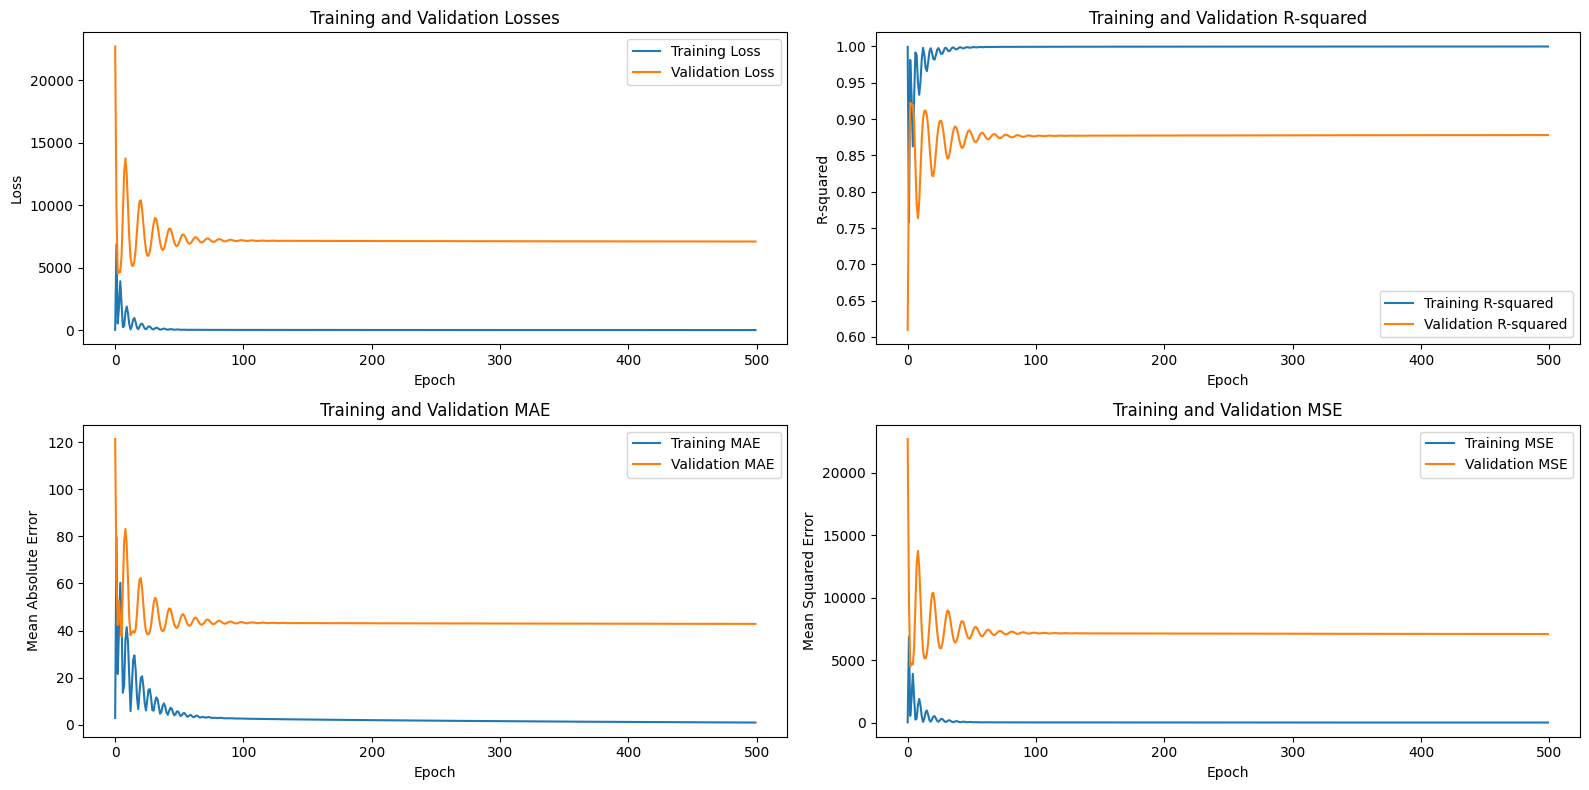

Test Loss: 616.5806884765625, Test R-squared: 0.9722057866332707, Test MAE: 15.420174598693848, Test MSE: 616.5806274414062


In [ ]:
from google.colab import drive
import os
import torch
import joblib
from torch_geometric.nn import SAGEConv
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
model_filename = 'pegnn_model_Paris.pth'  # Custom filename used previously
model_path = os.path.join(drive_path, model_filename)
study_path = os.path.join(drive_path, 'optuna_study_pegnn_Paris.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_Paris.pkl')

# Function to load the model
def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to load input feature size
def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Reload the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_params = loaded_study.best_params
print("Best parameters: ", best_params)

# Reload the input feature size
input_feature_size = load_input_feature_size(input_size_path)

# Define the PEGNN model class
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Assuming train_coords_pegnn, val_coords_pegnn, test_coords_pegnn, train_features_pegnn, val_features_pegnn, and test_features_pegnn are defined
d_model = 128

def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

def position_encoding(coords, d_model):
    pe = torch.zeros((coords.shape[0], d_model))
    for i in range(coords.shape[0]):
        for j in range(d_model // 2):
            pe[i, 2 * j] = torch.sin(coords[i, 0] / (10000 ** (2 * j / d_model)))
            pe[i, 2 * j + 1] = torch.cos(coords[i, 1] / (10000 ** (2 * j / d_model)))
    return pe

edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)
y_train = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn.values, dtype=torch.float).view(-1, 1)

# Load the model with the best hyperparameters
loaded_model = load_model(PEGNN, model_path, input_feature_size, best_params['hidden_channels'], 1)

# Set the model to evaluation mode
loaded_model.eval()

# Create the optimizer and loss function
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

# Train the model and compute metrics
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

loaded_model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = loaded_model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    loaded_model.eval()
    with torch.no_grad():
        out_val = loaded_model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')
    loaded_model.train()

# Save the final model
# save_model(loaded_model, model_path)  # Uncomment if you want to save the model again

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

loaded_model.eval()
with torch.no_grad():
    out_test = loaded_model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')



extra reporting metrics


Test Loss: 0.09898356348276138, Test R-squared: 0.9605978572309665, Test MAE: 0.11511142551898956, Test MSE: 0.09898356348276138


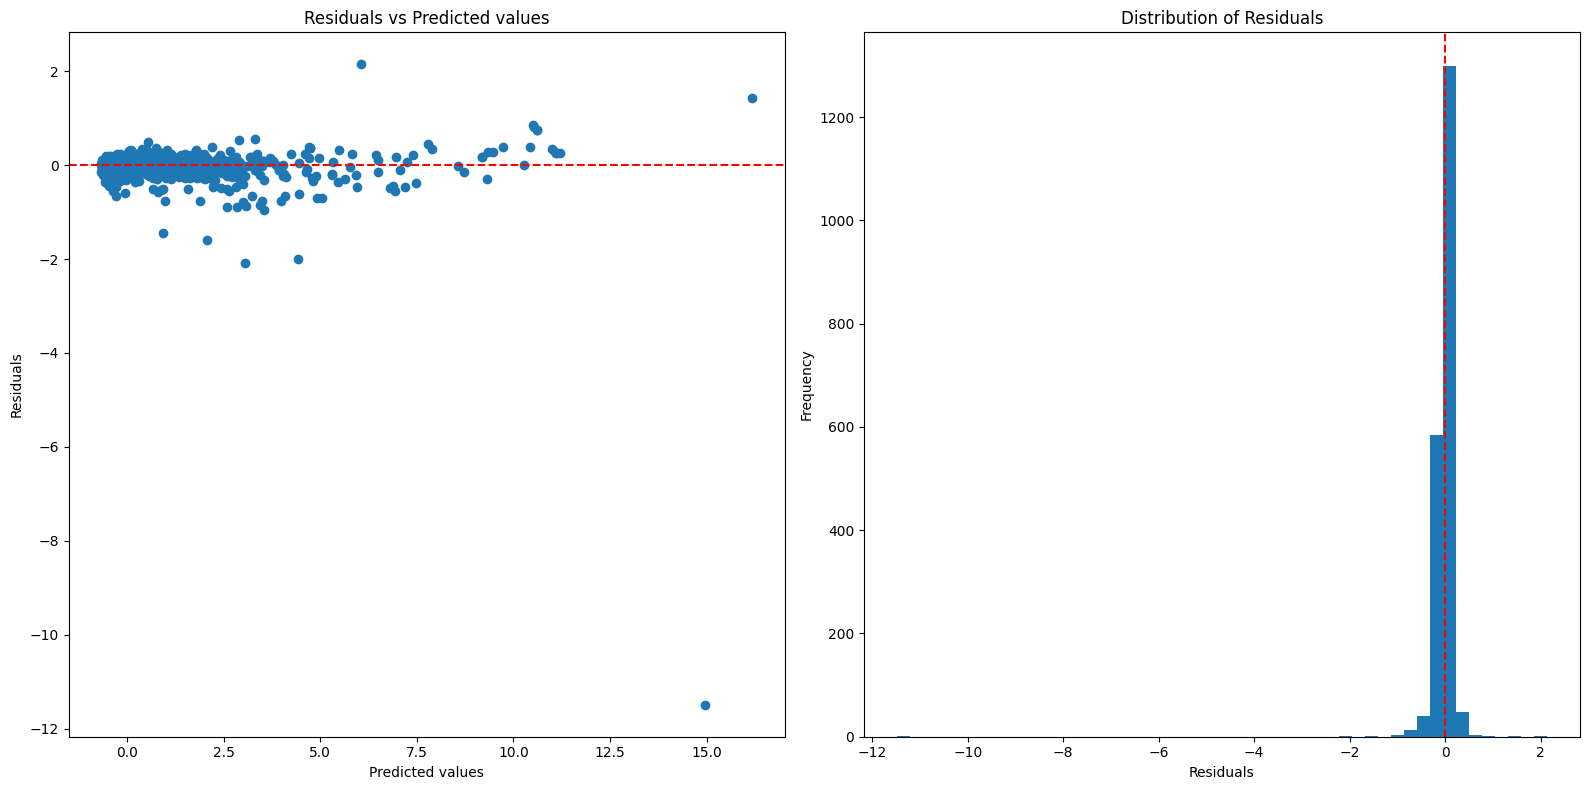

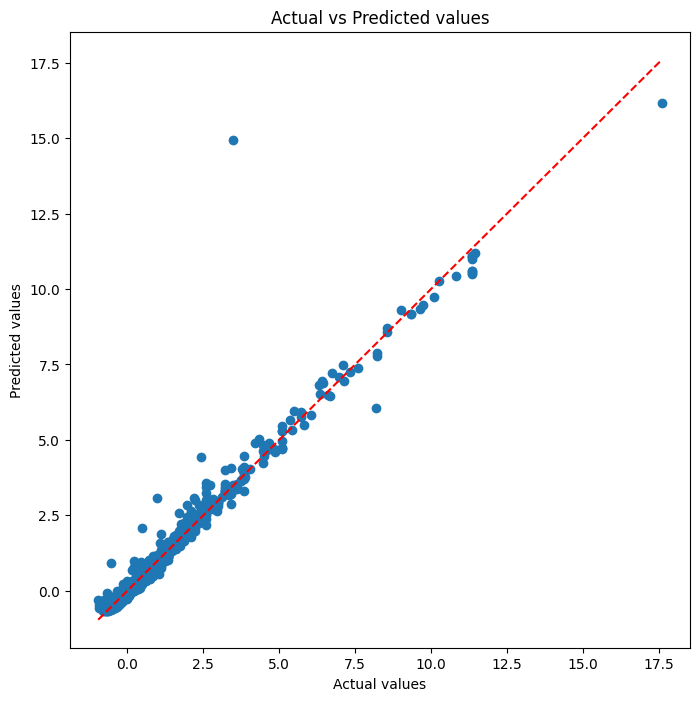

In [90]:
# Plotting residuals
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Plotting residuals
residuals = y_test_np - out_test_np
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(out_test_np, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_np, out_test_np)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')
plt.show()


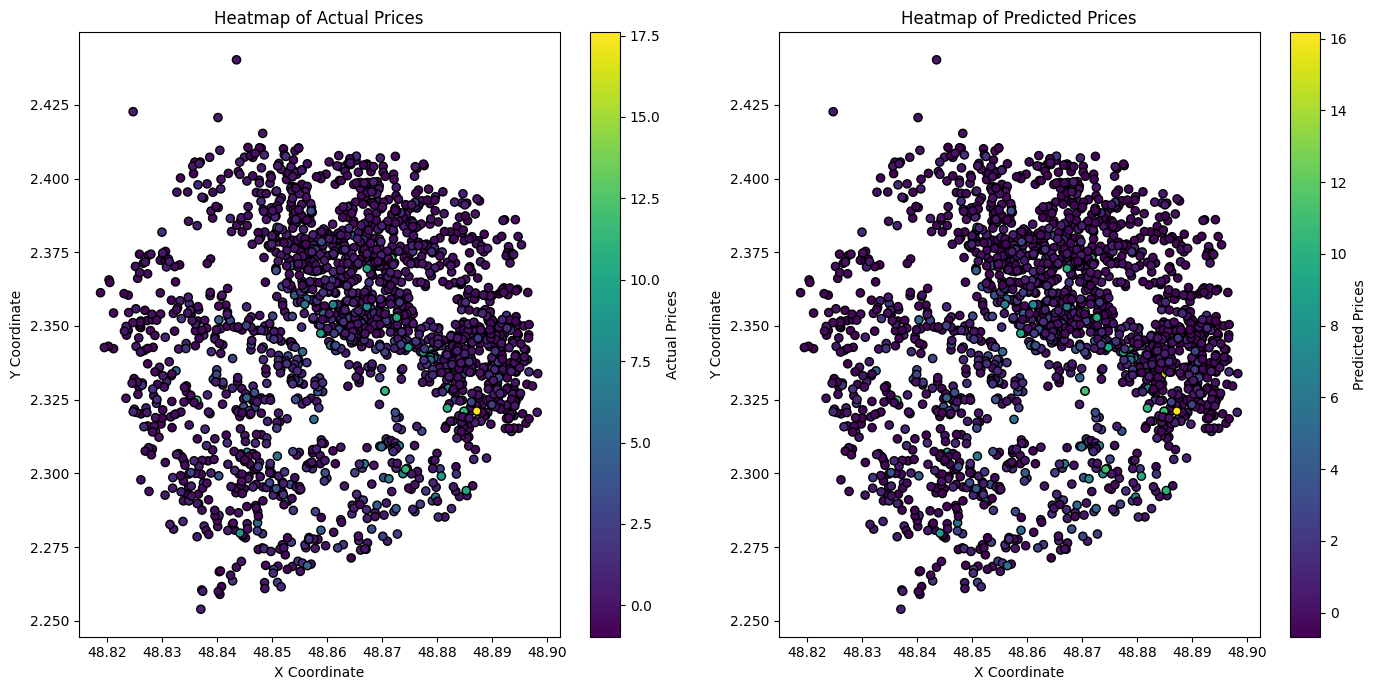

In [91]:
import seaborn as sns

# Plotting heatmaps of actual prices, predicted prices, and residuals
coords_np = np.array(test_coords_pegnn)

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_np, cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_np, cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


plt.tight_layout()
plt.show()



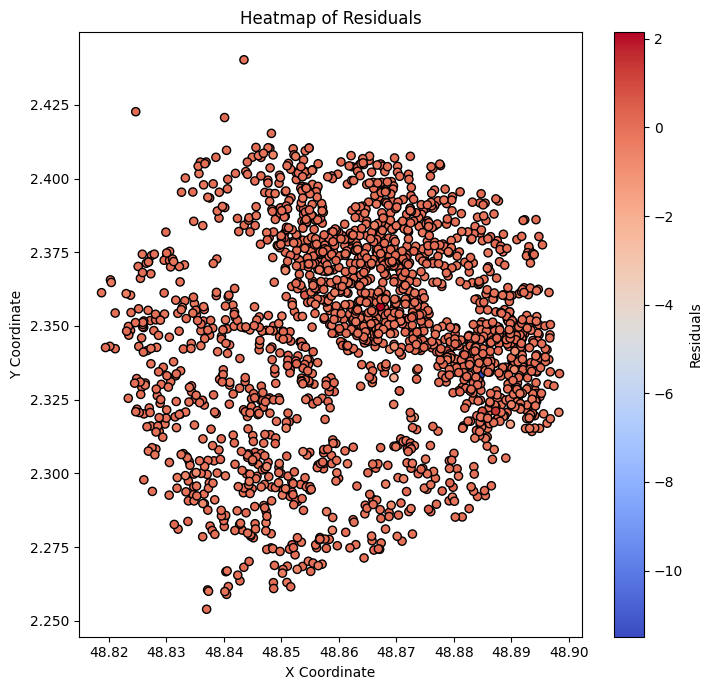

In [92]:
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals, cmap='coolwarm', s=35, edgecolor='k')
plt.colorbar(label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()

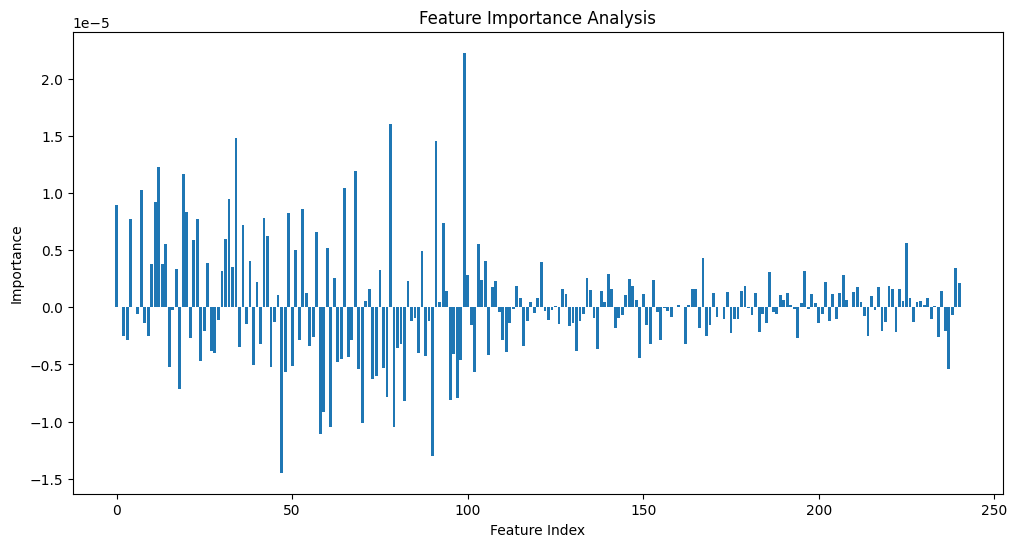

In [93]:
def feature_importance_analysis(model, x_test, edge_index_test, y_test, perturbation=0.01):
    model.eval()
    baseline_preds = model(x_test, edge_index_test).detach().numpy()
    baseline_mse = mean_squared_error(y_test.numpy(), baseline_preds)

    feature_importances = []

    for i in range(x_test.shape[1]):
        x_test_perturbed = x_test.clone()
        x_test_perturbed[:, i] += perturbation

        perturbed_preds = model(x_test_perturbed, edge_index_test).detach().numpy()
        perturbed_mse = mean_squared_error(y_test.numpy(), perturbed_preds)

        importance = perturbed_mse - baseline_mse
        feature_importances.append(importance)

    return feature_importances

# Perform feature importance analysis
feature_importances = feature_importance_analysis(model, x_test, edge_index_test, y_test)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(x_test.shape[1]), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance Analysis')
plt.show()


ik ga nog aanpassen dat de feature names hier bij komen te staan

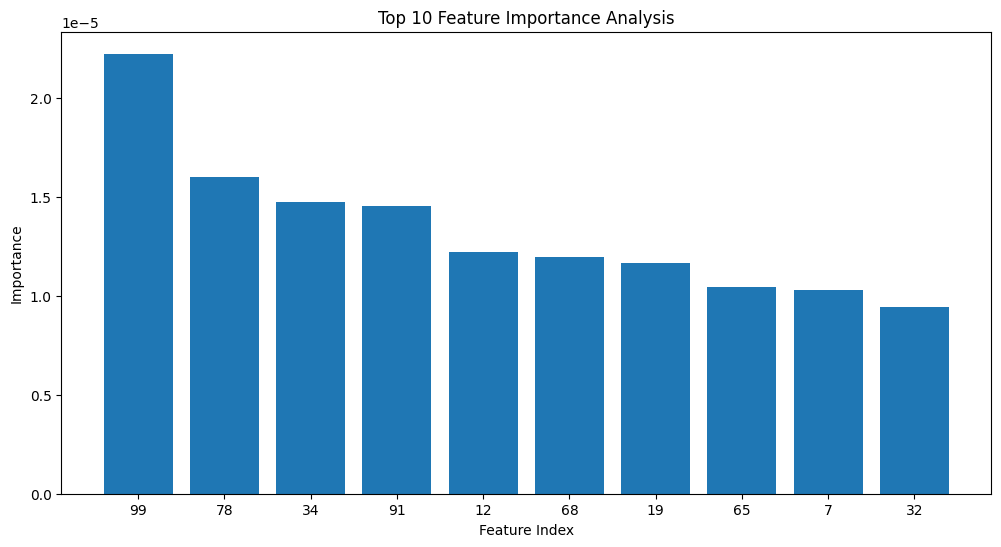

Feature Index: 99, Importance: 2.2254884243011475e-05
Feature Index: 78, Importance: 1.599639654159546e-05
Feature Index: 34, Importance: 1.4759600162506104e-05
Feature Index: 91, Importance: 1.455843448638916e-05
Feature Index: 12, Importance: 1.2248754501342773e-05
Feature Index: 68, Importance: 1.195073127746582e-05
Feature Index: 19, Importance: 1.1675059795379639e-05
Feature Index: 65, Importance: 1.0468065738677979e-05
Feature Index: 7, Importance: 1.0289251804351807e-05
Feature Index: 32, Importance: 9.462237358093262e-06


In [94]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def feature_importance_analysis(model, x_test, edge_index_test, y_test, perturbation=0.01):
    model.eval()
    baseline_preds = model(x_test, edge_index_test).detach().numpy()
    baseline_mse = mean_squared_error(y_test.numpy(), baseline_preds)

    feature_importances = []

    for i in range(x_test.shape[1]):
        x_test_perturbed = x_test.clone()
        x_test_perturbed[:, i] += perturbation

        perturbed_preds = model(x_test_perturbed, edge_index_test).detach().numpy()
        perturbed_mse = mean_squared_error(y_test.numpy(), perturbed_preds)

        importance = perturbed_mse - baseline_mse
        feature_importances.append((i, importance))

    return feature_importances

# Perform feature importance analysis
feature_importances = feature_importance_analysis(model, x_test, edge_index_test, y_test)

# Sort features by importance
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Get top 10 features
top_features = feature_importances[:10]
top_indices = [x[0] for x in top_features]
top_importances = [x[1] for x in top_features]

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(10), top_importances, tick_label=top_indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance Analysis')
plt.show()

# Print top 10 features and their importances
for idx, importance in top_features:
    print(f'Feature Index: {idx}, Importance: {importance}')


In [95]:
train_features_pegnn.shape

(6000, 113)